## Predicción de Churn en Telecom X - Miguel Acuña


# **INDICE**

0. CARGA DE DATOS
1. DESCRIPCION DEL PROYECTO
2. ANALISIS EXPLORATORIO
3. PREPARACION DE LOS DATOS
4. MODELAMIENTO  

*Nota: Se aplica la metodologia CRISP-DM*

# **0. CARGA DE DATOS**

## **0.1 LIBRERIAS**

In [1]:
pip install xgboost lightgbm

In [63]:
#Importando la biblioteca Pandas
import pandas as pd

#Importando el módulo JSON
import json

# Import requests to fetch data from URL
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io


# import para modelos
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

import numpy as np
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, f1_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc



from sklearn.model_selection import GridSearchCV, StratifiedKFold

import xgboost as xgb
from lightgbm import LGBMClassifier




## **0.2 DATASET**

In [3]:
# DIRECCION:
path = 'https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/TelecomX_Data.json'

# Fetch the data from the URL
response = requests.get(path)
data = json.loads(response.text)

# Normalize the JSON data
df_normalized = pd.json_normalize(data)

# Display the first few rows of the normalized DataFrame
display(df_normalized.head())

customerID Churn customer.gender  customer.SeniorCitizen customer.Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer.Dependents  customer.tenure phone.PhoneService phone.MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4                  No                3                Yes                  No   

  internet.InternetService  ... internet.OnlineBackup  \
0                      DSL  ...                   Yes   
1                      DSL  ...                    No   
2              Fiber optic  ...                    No   
3              Fiber optic  ...                   Yes   
4              Fiber optic  ...                    No   

  internet.DeviceProtection internet.TechSupport internet.StreamingTV  \
0                        No                  Yes                  Yes   
1                        No                   No                   No   
2                       Yes                   No                   No   
3                       Yes                   No                  Yes   
4                        No                  Yes                  Yes   

  internet.StreamingMovies account.Contract account.PaperlessBilling  \
0                       No         One year                      Yes   
1                      Yes   Month-to-month                       No   
2                       No   Month-to-month                      Yes   
3                      Yes   Month-to-month                      Yes   
4                       No   Month-to-month                      Yes   

  account.PaymentMethod account.Charges.Monthly  account.Charges.Total  
0          Mailed check                    65.6                  593.3  
1          Mailed check                    59.9                  542.4  
2      Electronic check                    73.9                 280.85  
3      Electronic check                    98.0                1237.85  
4          Mailed check                    83.9                  267.4  

[5 rows x 21 columns]

# **1. DESCRIPCION DEL PROYECTO**

## **1.1 DESCRIPCION DEL PROBLEMA**

Telecom X, una empresa de telecomunicaciones, está experimentando una alta tasa de cancelación de clientes (churn). Esta pérdida de clientes representa un desafío significativo para la rentabilidad y el crecimiento de la empresa. Actualmente, no se comprenden claramente los factores subyacentes que impulsan a los clientes a abandonar los servicios. La falta de esta comprensión impide a la empresa desarrollar estrategias de retención efectivas y proactivas, lo que resulta en una continua erosión de su base de clientes.

## **1.2 Objetivo Principal del Proyecto:**

Identificar y reducir a los clientes con alta probabilidad de abandonar el servicio, permitiendo así intervenciones proactivas.


## **1.3 Objetivo de Ciencia de Datos:**

Este es un problema de clasificación binaria.

Nuestro objetivo principal es predecir si un cliente "dejará" o "no dejará" la empresa. La variable Churn tiene dos categorías posibles (sí/no, 1/0), lo que la convierte en una tarea de clasificación binaria. La meta final es construir un modelo que clasifique a los clientes en estas dos categorías. Para ello se utlizara:

* Realizar un tratamiento ETL sobre el dataset.
* Realizar una exploracion descriptiva de los datos.

# **2. ANALISIS EXPLORATORIO DE LOS DATOS**

## **2.1 DESCRIPCION DEL DATASET**

Los datos para este proyecto de análisis de churn de clientes en Telecom X se obtendrán a través de una API (Interfaz de Programación de Aplicaciones). Esta API proporciona acceso estructurado a la información de los clientes, incluyendo detalles demográficos, servicios contratados, historial de pagos y, crucialmente, el estado de churn de cada cliente.

Se observa que esta almecenado informacion y cuentas del usuarios y ademas el servicio que esta utilizando.

* La seccion customer se refiere a informacion de usuario.

* La seccion account se refiere a informacion de las cuentas y metodos de pago de los usuarios.

* Servicios que ofrecen:

  * Servicio telefonico: Ofrecen un linea telefonica o varias lineas telefonicas. `PhoneService` y `MultipleLines`.

  * Servicio de internet: Ofrecen servicio de internet:

    * 1. Supcripcion a internet.
    * 2. Servicio de seguridad online.
    * 3. Servivio de respaldo adicional.
    * 4. Servicio de proteccion de dispositivos.
    * 5. Servicio de soporte tecnico.
    * 6. Servicio de television por cable.
    * 7. Servicio de streaming de peliculas.

## **2.2 Variable Objetivo y Variables de Entrada**

**Variable Objetivo:**

Churn: Indica si un cliente ha cancelado su servicio (Yes/No). Esta es la variable que queremos predecir o explicar.

**Variables de Entrada:**

Estas son las variables que utilizaremos para entender y, eventualmente, predecir el churn.

Incluyen:

* customerID: Identificador único del cliente (útil para seguimiento, pero no como predictor directo).
* gender: Género del cliente.
* SeniorCitizen: Si el cliente es un ciudadano de la tercera edad.
* Partner: Si el cliente tiene pareja.
* Dependents: Si el cliente tiene dependientes.
* tenure: Meses de contrato del cliente.
* PhoneService: Si tiene servicio telefónico.
* MultipleLines: Si tiene múltiples líneas telefónicas.
* InternetService: Tipo de servicio de internet.
* OnlineSecurity: Si tiene seguridad en línea.
* OnlineBackup: Si tiene respaldo en línea.
* DeviceProtection: Si tiene protección de dispositivo.
* TechSupport: Si tiene soporte técnico.
* StreamingTV: Si tiene servicio de streaming de TV.
* StreamingMovies: Si tiene servicio de streaming de películas.
* Contract: Tipo de contrato.
* PaperlessBilling: Si tiene facturación sin papel.
* PaymentMethod: Método de pago.
* Charges.Monthly: Cargos mensuales.
* Charges.Total: Cargos totales.

## **2.3 CARACTERIZACION DEL DATASET**

El dataset cuenta con un total de 7267 registros y posee 21 columnas.

In [4]:
df_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

In [5]:
df_normalized.describe()

customer.SeniorCitizen  customer.tenure  account.Charges.Monthly
count             7267.000000      7267.000000              7267.000000
mean                 0.162653        32.346498                64.720098
std                  0.369074        24.571773                30.129572
min                  0.000000         0.000000                18.250000
25%                  0.000000         9.000000                35.425000
50%                  0.000000        29.000000                70.300000
75%                  0.000000        55.000000                89.875000
max                  1.000000        72.000000               118.750000

### **2.3.1 Clasificacion de las columnas segun su natureleza**

Se categoriazan las columnas en una lista de acuerdo a su natureleza.


La columna customerID es de tipo object es un variable tipo entero.

La columna customer.SeniorCitizen se muestra que es de tipo entero y esta columna es de tipo object. Es un columna de tipo categorica.

La columna account.Charges.Total se observa que es de tipo de object pero un es un variable tipo float ya que representa el costo total de un cliente.

In [6]:
columns_integer = ['customerID', 'customer.tenure', ]
columns_categoricas = ['customer.gender', 'phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup',
                       'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies',
                       'account.Contract', 'account.PaymentMethod' ]

Columns_binarias = ['Churn', 'customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents', 'phone.PhoneService', 'account.PaperlessBilling' ]
columns_float = ['account.Charges.Monthly', 'account.Charges.Total']

print(len(columns_integer)+len(columns_categoricas)+len(Columns_binarias)+len(columns_float))

21


### 2.3.2 Distribucion de variables categoricas

**Distribucion de variables con mas de un solo elementos unicos**

In [7]:
# Funcion conteo y proporcion de datos
def dist(df,target):
    count= df[target].value_counts(normalize=False)
    prop = df[target].value_counts(normalize=True)*100

    dist = pd.DataFrame({'Freq[N]':count,'Prop[%]':prop.round(3)})
    return dist

In [8]:
# Ver el conteo y la proporción de Class
# columnas_categorias = df.select_dtypes(include='object').columns.tolist()
# print(columnas_categorias)
for i in columns_categoricas:
    print(' '*7,i.upper())
    print(dist(df_normalized,i))
    print("*"*23)

        CUSTOMER.GENDER
                 Freq[N]  Prop[%]
customer.gender                  
Male                3675   50.571
Female              3592   49.429
***********************
        PHONE.MULTIPLELINES
                     Freq[N]  Prop[%]
phone.MultipleLines                  
No                      3495   48.094
Yes                     3065   42.177
No phone service         707    9.729
***********************
        INTERNET.INTERNETSERVICE
                          Freq[N]  Prop[%]
internet.InternetService                  
Fiber optic                  3198   44.007
DSL                          2488   34.237
No                           1581   21.756
***********************
        INTERNET.ONLINESECURITY
                         Freq[N]  Prop[%]
internet.OnlineSecurity                  
No                          3608   49.649
Yes                         2078   28.595
No internet service         1581   21.756
***********************
        INTERNET.ONLINEBACKUP
      

**Variables Nominales (Sin orden inherente):**

* CUSTOMER.GENDER:

  Male, Female.

  Hay un equilibrio en el generos. Esto sugiere que el género, por sí solo, podría no ser un factor diferenciador principal en el churn, pero es importante considerarlo en combinación con otras variables.

* PHONE.MULTIPLELINES:

  No, Yes, No phone service.

  La mayoría de los clientes tienen una sola línea (No con 48.1%) o múltiples líneas (Yes con 42.2%). Un 9.7% de los clientes no tiene servicio telefónico.

**Servicios de internet y sevicios adicionales:**

* INTERNET.INTERNETSERVICE: Fiber optic, DSL, No.

  La fibra óptica es el servicio de internet más popular (44%), seguido por DSL (34.2%). Un 21.8% de los clientes no tiene servicio de internet
  

* INTERNET.ONLINESECURITY: No, Yes, No internet service.

* INTERNET.ONLINEBACKUP: No, Yes, No internet service.

* INTERNET.DEVICEPROTECTION: No, Yes, No internet service.

* INTERNET.TECHSUPPORT: No, Yes, No internet service.

* INTERNET.STREAMINGTV: No, Yes, No internet service.

* INTERNET.STREAMINGMOVIES: No, Yes, No internet service.

* ACCOUNT.PAYMENTMETHOD: Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic). No hay un orden natural entre los métodos de pago.

* ACCOUNT.CONTRACT:

  La gran mayoría de los clientes (55.1%) tiene contratos mes a mes, lo que implica una menor lealtad y un mayor riesgo de 'churn'. Los contratos de dos años (24%) y un año (20.9%) son menos comunes.

**Inferencias**

El 21.8% de los clientes no tiene servicio de internet, y esta categoría se repite consistentemente en todos los servicios adicionales de internet (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies).

Esto es crucial: aproximadamente una quinta parte de la base de clientes no usa internet, **lo que significa que las variables relacionadas con servicios de internet adicionales serán "No internet service" para ellos.**

Servicios Adicionales (Seguridad, Respaldo, Protección, Soporte, Streaming):

Para los clientes que sí tienen internet, la tendencia general es que más clientes no tienen estos servicios adicionales que los que sí los tienen (ej. OnlineSecurity: 49.6% No vs 28.6% Yes). Esto podría indicar una oportunidad para la empresa o, alternativamente, que estos servicios no son percibidos como esenciales por la mayoría. La categoría "No internet service" es una constante en todas estas variables, lo que simplifica su manejo al agrupar a los clientes sin internet.

Esta es una variable crítica para el análisis de churn, ya que los contratos a corto plazo suelen estar asociados con tasas de cancelación más altas.

**Distribucion de variable con dos elementos unicos**

In [9]:
for i in Columns_binarias:
    print(' '*7,i.upper())
    print(dist(df_normalized,i))
    print("*"*23)

        CHURN
       Freq[N]  Prop[%]
Churn                  
No        5174   71.199
Yes       1869   25.719
           224    3.082
***********************
        CUSTOMER.SENIORCITIZEN
                        Freq[N]  Prop[%]
customer.SeniorCitizen                  
0                          6085   83.735
1                          1182   16.265
***********************
        CUSTOMER.PARTNER
                  Freq[N]  Prop[%]
customer.Partner                  
No                   3749   51.589
Yes                  3518   48.411
***********************
        CUSTOMER.DEPENDENTS
                     Freq[N]  Prop[%]
customer.Dependents                  
No                      5086   69.988
Yes                     2181   30.012
***********************
        PHONE.PHONESERVICE
                    Freq[N]  Prop[%]
phone.PhoneService                  
Yes                    6560   90.271
No                      707    9.729
***********************
        ACCOUNT.PAPERLESSBILLIN

Descripcion:

* CHURN (Variable Objetivo):

  Observamos un desequilibrio de clases significativo: la mayoría de los clientes (más del 71%) no han hecho churn, mientras que solo un 25.7% sí lo ha hecho. 224 registros (3.08%) sin una categoría clara. Se debe de revisar la calidad de estos datos.


* CUSTOMER.SENIORCITIZEN:

  La gran mayoría de los clientes de Telecom X no son ciudadanos de la tercera edad. Solo un 16.3% de la base de clientes entra en esta categoría.

  *Verificar impacto sobre CHURN*

* CUSTOMER.PARTNER

  La distribución entre clientes con y sin pareja es casi equitativa.

  *Verificar impacto sobre CHURN*

* CUSTOMER.DEPENDENTS

  La mayoría de los clientes no tienen dependientes (70%). Solo un 30% sí los tiene.

  *Verificar impacto sobre CHURN*

* PHONE.PHONESERVICE

  La mayoría de los clientes (más del 90%) tiene servicio telefónico. Esto es esperable en una empresa de telecomunicaciones. El grupo sin servicio telefónico es minoritario, pero su comportamiento de churn podría ser distinto.

* ACCOUNT.PAPERLESSBILLING

  La facturación en linea es la opción preferida por la mayoría de los clientes (casi el 60%).
  
  *Verificar impacto sobre CHURN*



#### **2.3.2.1 Eliminacion de valores null en la variable objetivo**

Se observa que espacios vacios en la variable este valor representa solo el 3% del total de los datos.

In [10]:
# Eliminar filas donde la columna 'Churn' es una cadena vacía
df_cleaned = df_normalized[df_normalized['Churn'] != ''].copy()

# Verificar el número de instancias en el DataFrame limpio
print(f"Número de instancias antes de eliminar: {len(df_normalized)}")
print(f"Número de instancias después de eliminar: {len(df_cleaned)}")

# Mostrar el conteo de valores para la columna 'Churn' en el DataFrame limpio
print("\nConteo de valores para 'Churn' después de eliminar valores vacíos:")
display(df_cleaned['Churn'].value_counts())

Número de instancias antes de eliminar: 7267
Número de instancias después de eliminar: 7043

Conteo de valores para 'Churn' después de eliminar valores vacíos:


Churn
No     5174
Yes    1869
Name: count, dtype: int64

Se realiza un transformacion para poder interpretar mas facilmente los graficos

In [11]:
df_cleaned['customer.SeniorCitizen'] = df_cleaned['customer.SeniorCitizen'].map({0: 'No', 1: 'Yes'})

#### **2.3.2.2 Graficos de distribucion de las columnas categoricas sobre Churn**

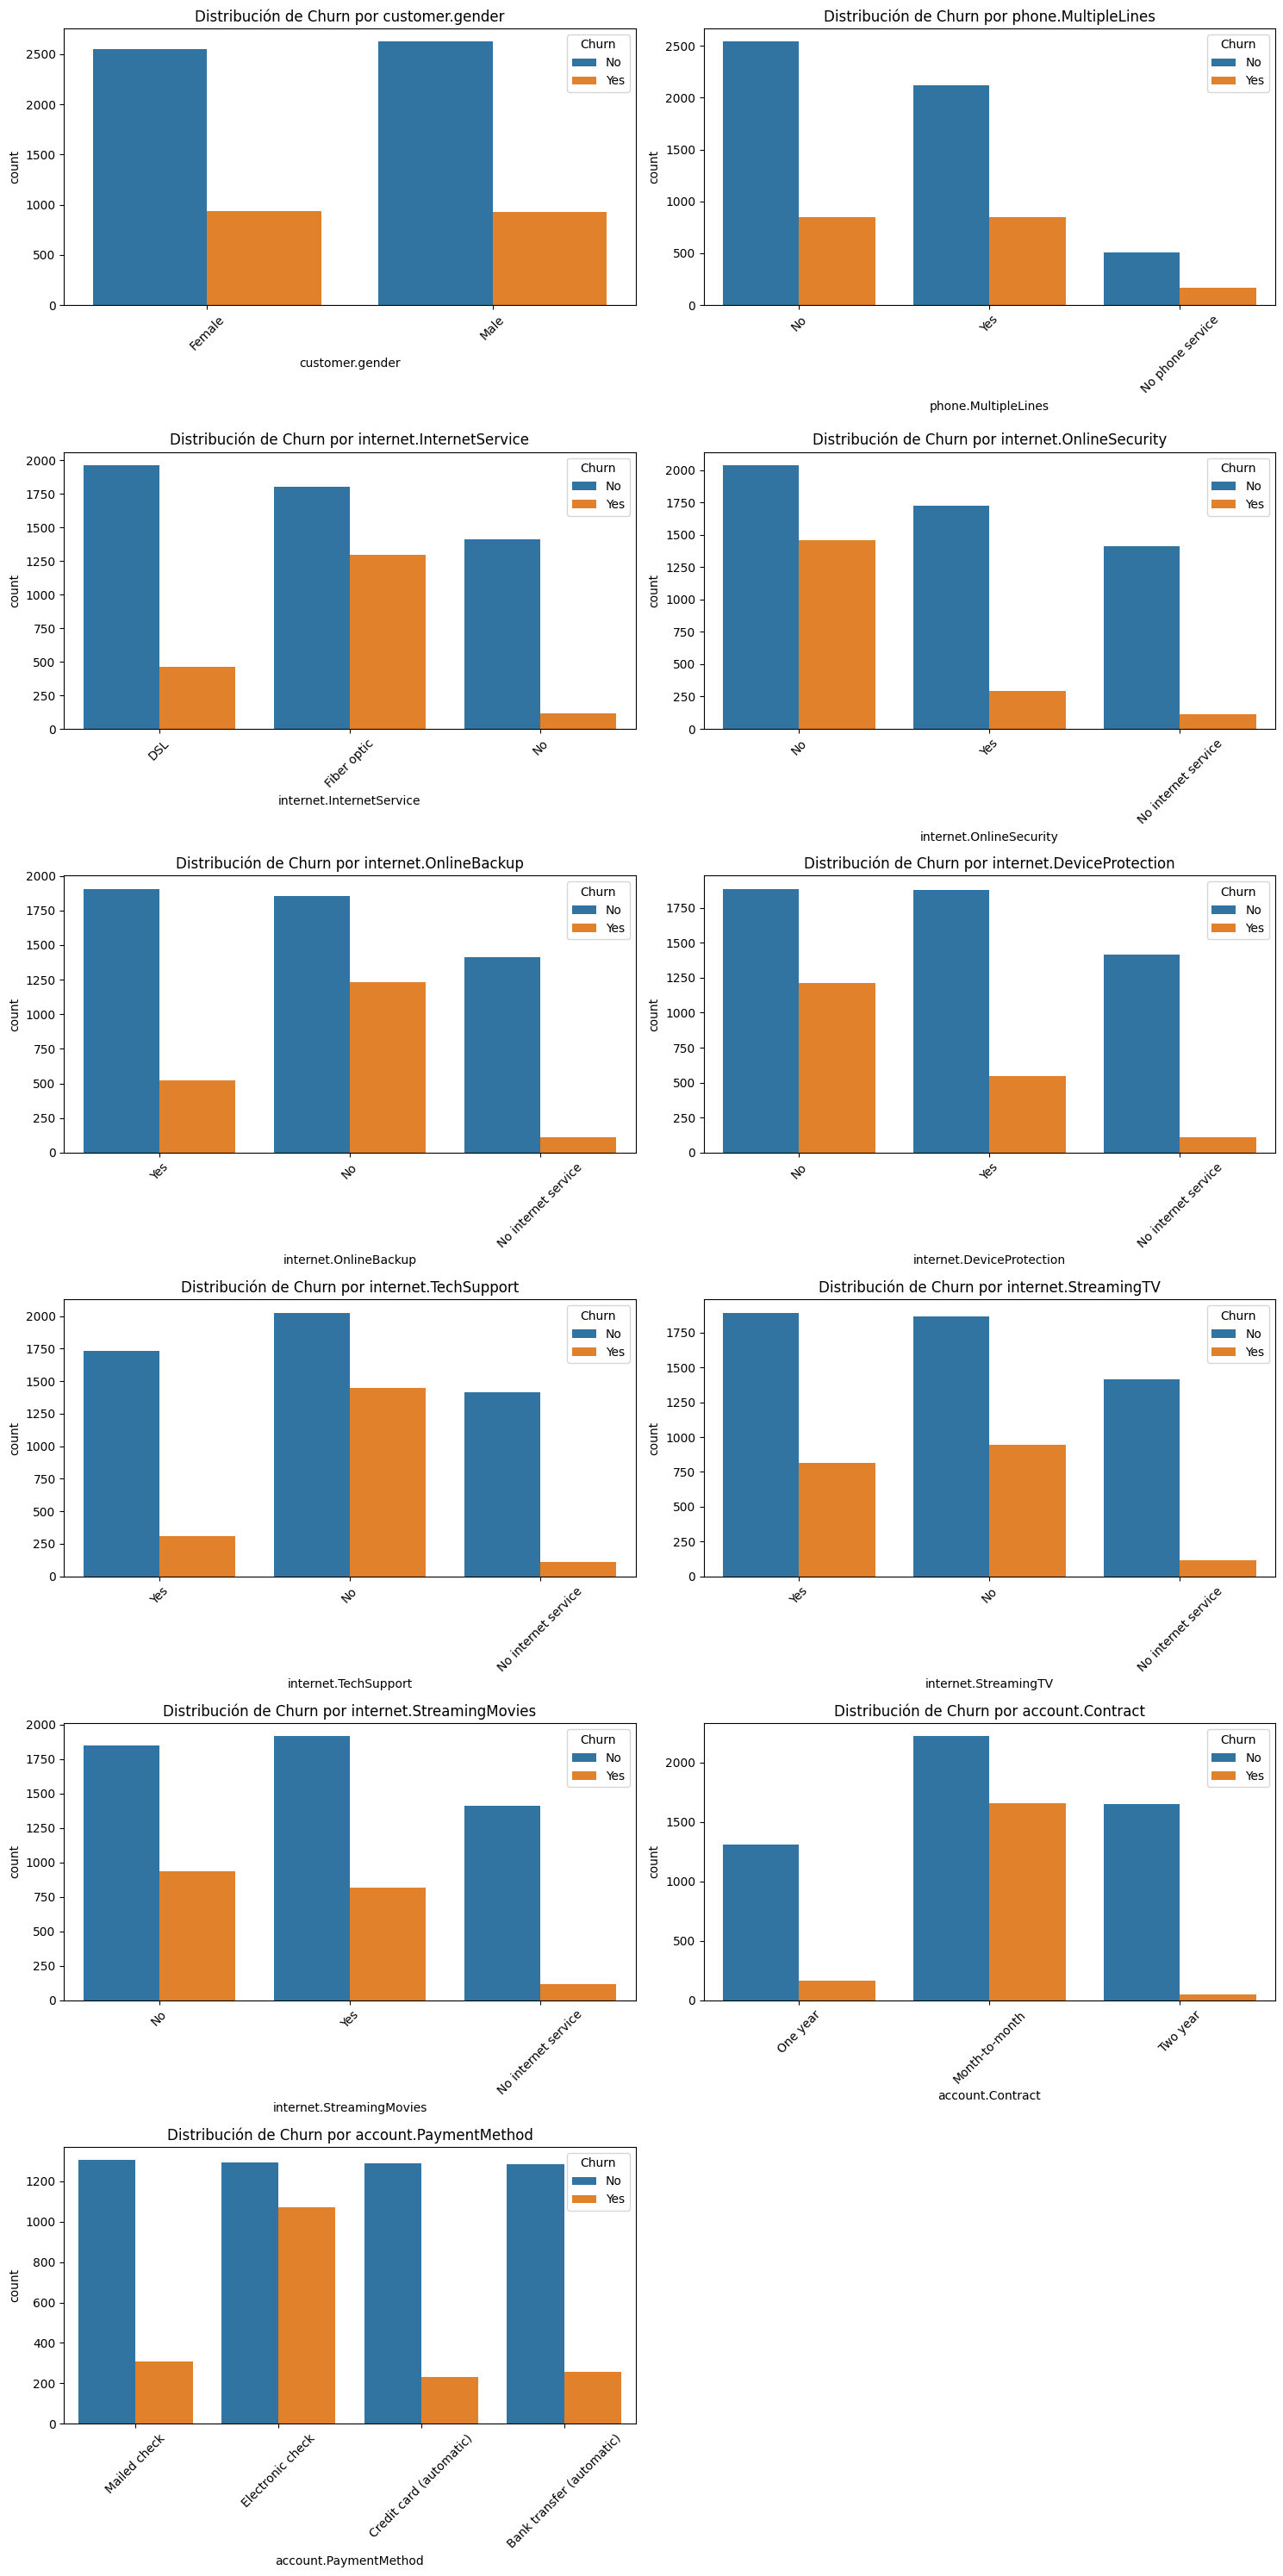

In [12]:
# Se obtiene el listado de variables categóricas (excluyendo 'Churn')
categorical_columns = [col for col in columns_categoricas if col != 'Churn']

# Determinar el número de filas y columnas para la cuadrícula de subplots
n_cols = 2
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols

# Crear subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten() # Aplanar el array 2D de ejes para facilitar la iteración

# Crear un countplot para cada columna categórica
for i, col in enumerate(categorical_columns):
    sns.countplot(data=df_cleaned, x=col, hue='Churn', ax=axes[i])
    axes[i].set_title(f'Distribución de Churn por {col}')
    axes[i].tick_params(axis='x', rotation=45) # Rotar las etiquetas del eje x para mejor legibilidad

# Ocultar cualquier subplot no utilizado
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Inferencias:

* customer.gender:
  
  El género no parece tener un impacto significativo en la tasa de churn, ya que las proporciones de clientes que se van ('Yes') y se quedan ('No') son muy similares entre hombres y mujeres.

* phone.MultipleLines:

  Las proporciones entre los clientes con múltiples líneas telefónicas ('Yes') y los que no tienen múltiples líneas ('No') muestran proprocion similar en la tase de churn. Los que no tienen servicio telefónico ('No phone service') tienen una tasa de churn baja.

* internet.InternetService:

  Los clientes con servicio de 'Fiber optic' presentan una tasa de churn notablemente mayor que aquellos con servicio 'DSL'. Los clientes sin servicio de internet ('No') tienen una tasa de churn muy baja, lo cual es esperable ya que no están utilizando un servicio propenso a la cancelación.

* internet.OnlineSecurity, internet.OnlineBackup, internet.
DeviceProtection, internet.TechSupport:

  Para todos estos servicios adicionales de internet, los clientes que NO tienen el servicio ('No') muestran una tasa de churn significativamente más alta que aquellos que sí lo tienen ('Yes'). Esto sugiere que ofrecer y utilizar estos servicios adicionales puede ser un factor importante en la retención de clientes. Los clientes sin servicio de internet ('No internet service') tienen, como se mencionó antes, una baja tasa de churn.

* internet.StreamingTV, internet.StreamingMovies:
  
  Similar a los servicios adicionales anteriores, los clientes que NO tienen servicios de streaming ('No') tienden a tener una tasa de churn más alta que aquellos que sí los tienen ('Yes').

* account.Contract:

  El tipo de contrato es un predictor muy fuerte de churn. Los clientes con contratos 'Month-to-month' tienen una tasa de churn muchísimo más alta que aquellos con contratos de 'One year' o 'Two year'. Los contratos a largo plazo están claramente asociados con una mayor retención.

* account.PaymentMethod:
  
  El método de pago 'Electronic check' muestra una tasa de churn considerablemente más alta en comparación con otros métodos como 'Mailed check', 'Bank transfer (automatic)' y 'Credit card (automatic)'.

#### **2.3.2.3 Graficos de distribucion de las columnas categoricas binarias sobre Churn**

Inferencias:

* customer.gender:
  
  El género no parece tener un impacto significativo en la tasa de churn, ya que las proporciones de clientes que se van ('Yes') y se quedan ('No') son muy similares entre hombres y mujeres.

* phone.MultipleLines:

  Las proporciones entre los clientes con múltiples líneas telefónicas ('Yes') y los que no tienen múltiples líneas ('No') muestran proprocion similar en la tase de churn. Los que no tienen servicio telefónico ('No phone service') tienen una tasa de churn baja.

* internet.InternetService:

  Los clientes con servicio de 'Fiber optic' presentan una tasa de churn notablemente mayor que aquellos con servicio 'DSL'. Los clientes sin servicio de internet ('No') tienen una tasa de churn muy baja, lo cual es esperable ya que no están utilizando un servicio propenso a la cancelación.

* internet.OnlineSecurity, internet.OnlineBackup, internet.
DeviceProtection, internet.TechSupport:

  Para todos estos servicios adicionales de internet, los clientes que NO tienen el servicio ('No') muestran una tasa de churn significativamente más alta que aquellos que sí lo tienen ('Yes'). Esto sugiere que ofrecer y utilizar estos servicios adicionales puede ser un factor importante en la retención de clientes. Los clientes sin servicio de internet ('No internet service') tienen, como se mencionó antes, una baja tasa de churn.

* internet.StreamingTV, internet.StreamingMovies:
  
  Similar a los servicios adicionales anteriores, los clientes que NO tienen servicios de streaming ('No') tienden a tener una tasa de churn más alta que aquellos que sí los tienen ('Yes').

* account.Contract:

  El tipo de contrato es un predictor muy fuerte de churn. Los clientes con contratos 'Month-to-month' tienen una tasa de churn muchísimo más alta que aquellos con contratos de 'One year' o 'Two year'. Los contratos a largo plazo están claramente asociados con una mayor retención.

* account.PaymentMethod:
  
  El método de pago 'Electronic check' muestra una tasa de churn considerablemente más alta en comparación con otros métodos como 'Mailed check', 'Bank transfer (automatic)' y 'Credit card (automatic)'.

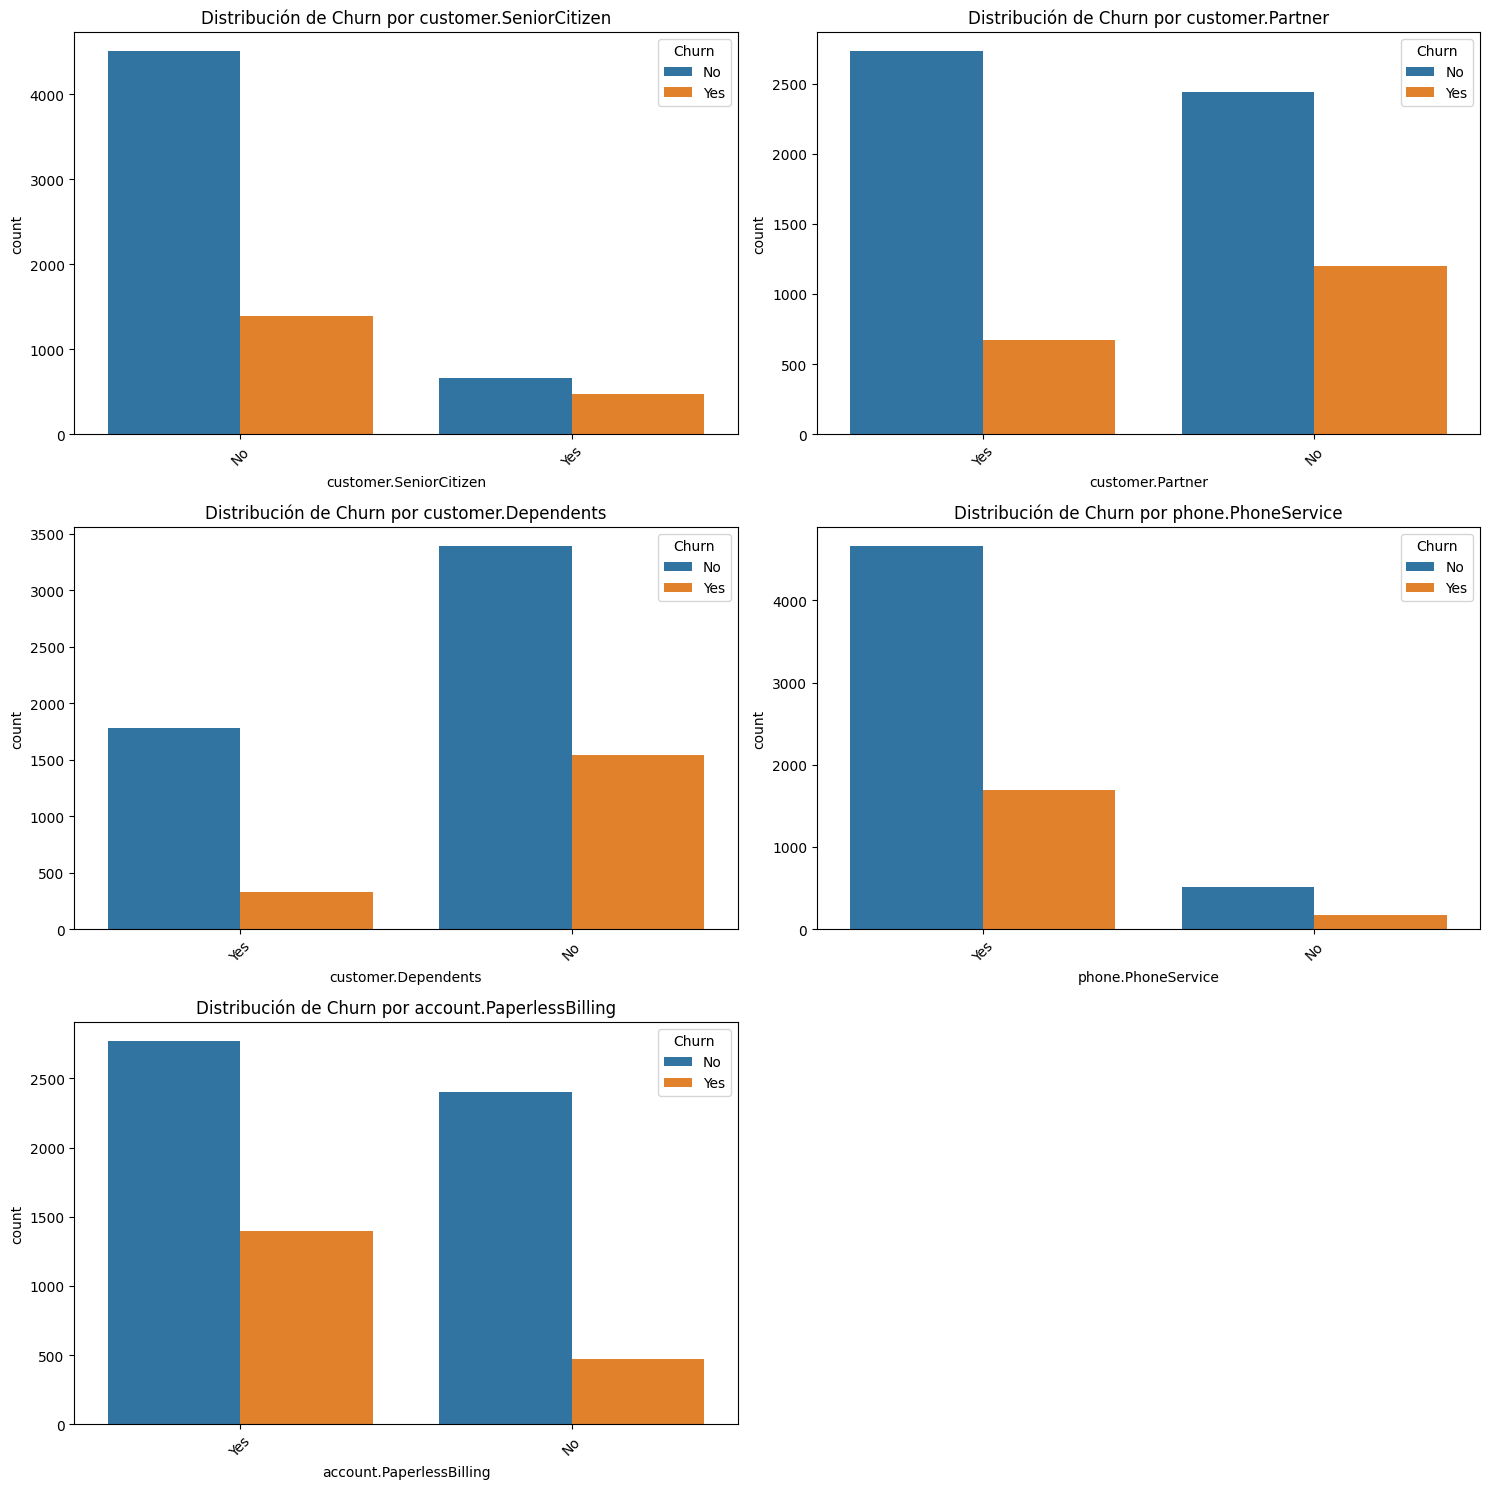

In [13]:
# Obtener la lista de columnas categóricas (excluyendo 'Churn')
categorical_columns = [col for col in Columns_binarias if col != 'Churn']

# Determinar el número de filas y columnas para la cuadrícula de subplots
n_cols = 2
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols

# Crear subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten() # Aplanar el array 2D de ejes para facilitar la iteración

# Crear un countplot para cada columna categórica
for i, col in enumerate(categorical_columns):
    sns.countplot(data=df_cleaned, x=col, hue='Churn', ax=axes[i])
    axes[i].set_title(f'Distribución de Churn por {col}')
    axes[i].tick_params(axis='x', rotation=45) # Rotar las etiquetas del eje x para mejor legibilidad

# Ocultar cualquier subplot no utilizado
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

* customer.SeniorCitizen:

  Se observa que los cliente que no son de la tecera edad tiene presenta un mayor cantidad de Churn en comparacion de que si son de la tercera edad. No obstante, los clientes que son ciudadanos de la tercera edad ('Yes') que son una minoria tienen una tasa de churn notablemente más alta en comparación con los que no lo son ('No'). Esto sugiere que la edad avanzada podría ser un factor de riesgo para el churn.

* customer.Partner:

  Los clientes sin pareja ('No') muestran una tasa de churn más alta que aquellos con pareja ('Yes'). Tener pareja parece estar asociado con una mayor retención.

* customer.Dependents:

  Los clientes sin dependientes ('No') tienen una tasa de churn significativamente mayor que aquellos con dependientes ('Yes'). Tener dependientes parece estar relacionado con una menor probabilidad de churn.

* phone.PhoneService:
  
  Aunque la gran mayoría de los clientes tiene servicio telefónico ('Yes'), la cantidad de churn es mayor para aquellos que sí tienen el servicio en comparación con el pequeño grupo que no lo tiene ('No').

* account.PaperlessBilling:
  
  Los clientes que tienen facturación electronica ('Yes') presentan una tasa de churn considerablemente más alta que aquellos que no la tienen ('No'). Esto podría indicar que la facturación electronica está asociada con clientes más propensos a cancelar.

### **2.3.3 Distribucion de variables numericas**

Se observa que la columna 'account.Charges.Total' es de tipo object, se realiza cambio variable numerica.

#### 2.3.3.1 Tratamiento y eliminacion de variable costos

In [14]:
# Inspeccionar valores únicos en 'account.Charges.Total' para entender por qué es un objeto
print("Valores únicos en 'account.Charges.Total':")
print(df_cleaned['account.Charges.Total'].unique())

Valores únicos en 'account.Charges.Total':
['593.3' '542.4' '280.85' ... '742.9' '4627.65' '3707.6']


In [15]:
# Convertir 'account.Charges.Total' a numérico, forzando errores
df_cleaned['account.Charges.Total'] = pd.to_numeric(df_cleaned['account.Charges.Total'], errors='coerce')

In [16]:
# Verificar si se introdujeron valores NaN por la coerción
nan_count = df_cleaned['account.Charges.Total'].isnull().sum()
print(f"\nNúmero de valores NaN en 'account.Charges.Total' después de la conversión: {nan_count}")


Número de valores NaN en 'account.Charges.Total' después de la conversión: 11


Dado que los valores nulos son 11 se pueden eliminar del dataset. Esta cantidad no representa más del 1%.

In [17]:
df_cleaned.dropna(subset=['account.Charges.Total'], inplace=True)

In [18]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7032 non-null   object 
 1   Churn                      7032 non-null   object 
 2   customer.gender            7032 non-null   object 
 3   customer.SeniorCitizen     7032 non-null   object 
 4   customer.Partner           7032 non-null   object 
 5   customer.Dependents        7032 non-null   object 
 6   customer.tenure            7032 non-null   int64  
 7   phone.PhoneService         7032 non-null   object 
 8   phone.MultipleLines        7032 non-null   object 
 9   internet.InternetService   7032 non-null   object 
 10  internet.OnlineSecurity    7032 non-null   object 
 11  internet.OnlineBackup      7032 non-null   object 
 12  internet.DeviceProtection  7032 non-null   object 
 13  internet.TechSupport       7032 non-null   object 
 1

#### **2.3.3.2 Graficos de distribucion de las columnas numericas sobre Churn**

**Histogramas**

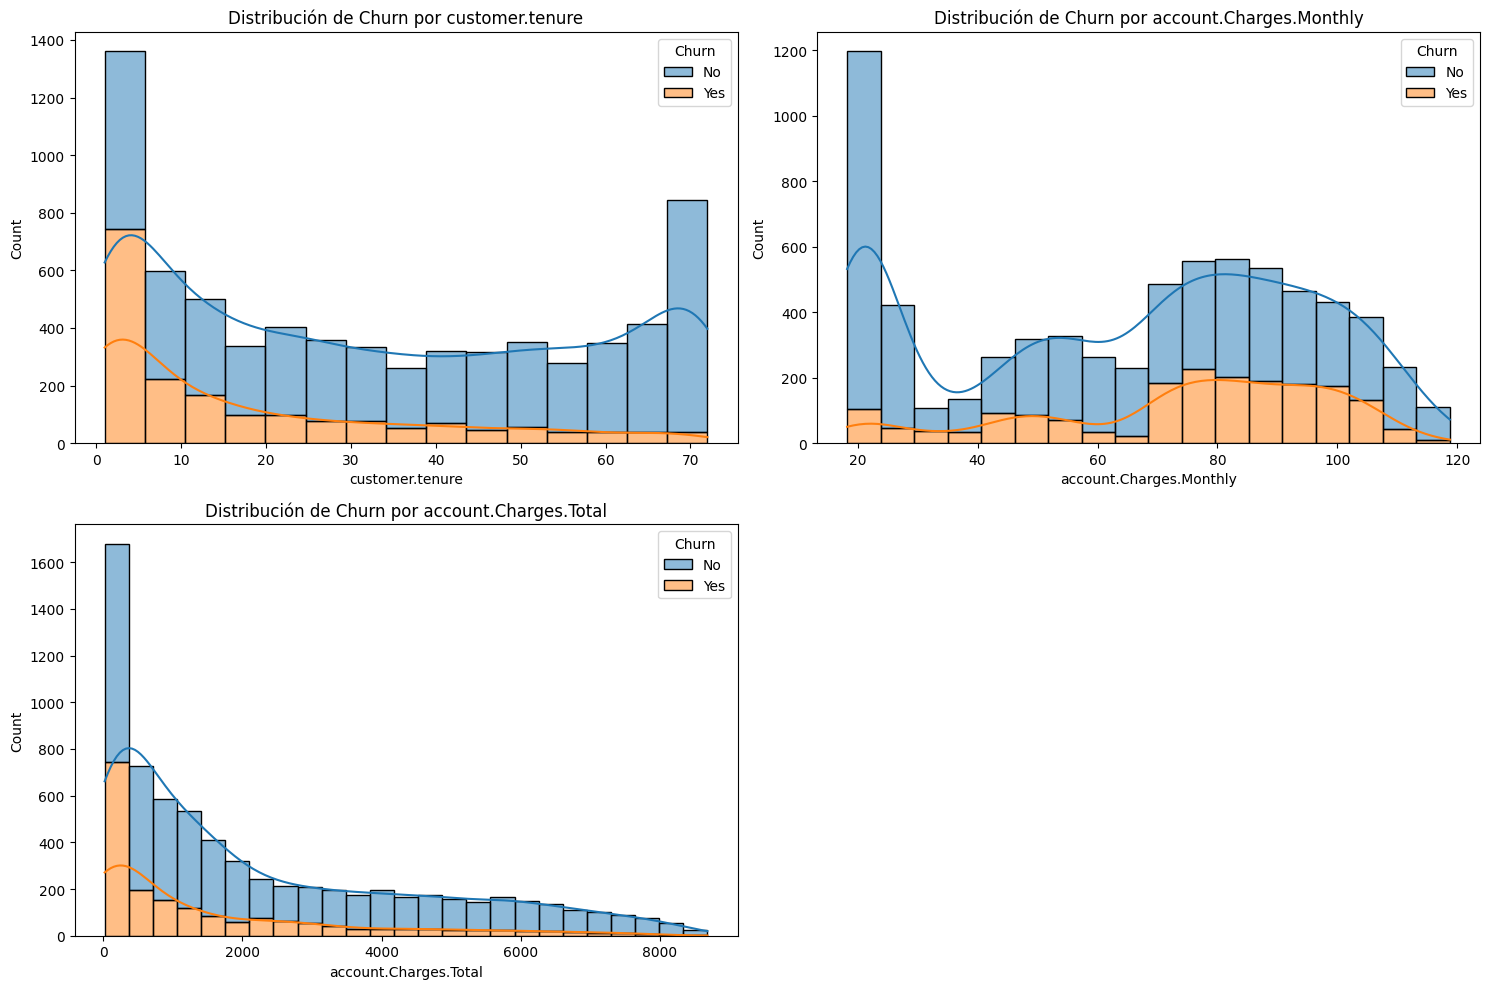

In [19]:
# Combinar columnas numéricas y remover 'customerID'
numerical_columns = [col for col in columns_integer + columns_float if col != 'customerID']

# Determinar el número de filas y columnas para la cuadrícula de subplots
n_cols = 2
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols

# Crear subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten() # Aplanar el array 2D de ejes para facilitar la iteración

# Crear un histograma para cada columna numérica
for i, col in enumerate(numerical_columns):
    sns.histplot(data=df_cleaned, x=col, hue='Churn', multiple='stack', ax=axes[i], kde=True)
    axes[i].set_title(f'Distribución de Churn por {col}')

# Ocultar cualquier subplot no utilizado
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Inferencias:

* customer.tenure:

  Se observa una clara tendencia: los clientes con menor antigüedad (tenure baja) tienen una tasa de churn significativamente más alta. A medida que la antigüedad del cliente aumenta, la proporción de churn disminuye drásticamente. Esto indica que los clientes de larga data son mucho menos propensos a cancelar su servicio.

* account.Charges.Monthly:

  Los clientes con cargos mensuales más altos ('account.Charges.Monthly') tienden a tener una mayor probabilidad de churn, especialmente en el rango de cargos más elevados. La distribución de los clientes que hacen churn está más concentrada en los valores de cargos mensuales más altos en comparación con los clientes que no hacen churn.

* account.Charges.Total:
  
  Los clientes con cargos totales más bajos ('account.Charges.Total') muestran una mayor proporción de churn. Esto está relacionado con la antigüedad (tenure), ya que los clientes con poca antigüedad tendrán cargos totales más bajos y, como vimos, son más propensos al churn. A medida que los cargos totales aumentan (lo que generalmente se correlaciona con una mayor antigüedad), la proporción de clientes que no hacen churn es mucho mayor.

**Boxplot**

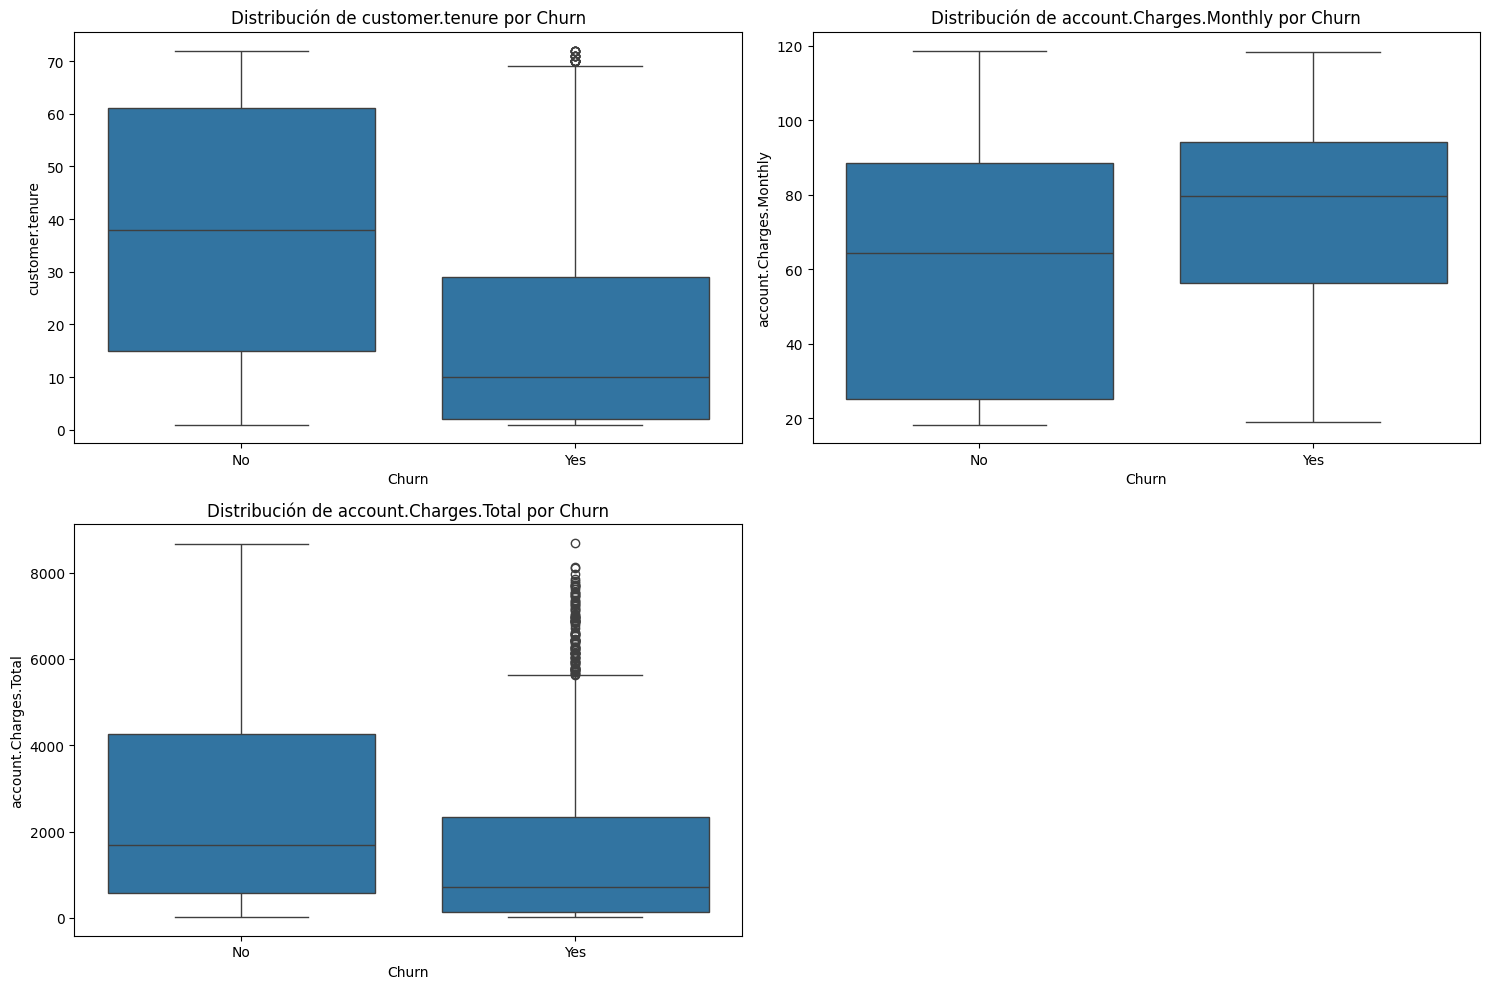

In [20]:
# Combine numerical columns and remove 'customerID'
numerical_columns = [col for col in columns_integer + columns_float if col != 'customerID']

# Determine the number of rows and columns for the subplot grid
n_cols = 2
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Create a boxplot for each numerical column
for i, col in enumerate(numerical_columns):
    sns.boxplot(data=df_cleaned, x='Churn', y=col, ax=axes[i])
    axes[i].set_title(f'Distribución de {col} por Churn')
    axes[i].set_xlabel('Churn')
    axes[i].set_ylabel(col)

# Hide any subplot not used
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

* customer.tenure:

  El gráfico de cajas para 'customer.tenure' muestra claramente que los clientes que no hicieron churn ('No') tienen una mediana de antigüedad significativamente más alta y una distribución que se extiende a valores mucho mayores de tenure en comparación con los clientes que sí hicieron churn ('Yes'). Los clientes que hicieron churn tienden a concentrarse en valores de tenure más bajos, con una mediana considerablemente menor. Esto refuerza la idea de que la antigüedad es un fuerte predictor de churn.
* account.Charges.Monthly:

  Para 'account.Charges.Monthly', el gráfico de cajas revela que los clientes que hicieron churn ('Yes') tienden a tener cargos mensuales más altos en promedio que los clientes que no hicieron churn ('No'). La mediana de los cargos mensuales es más alta para el grupo de churn, y la distribución se inclina hacia valores más altos.

* account.Charges.Total:
  
  El gráfico de cajas para 'account.Charges.Total' muestra que los clientes que no hicieron churn ('No') tienen una mediana y una distribución de cargos totales mucho más altas que los clientes que sí hicieron churn ('Yes'). Esto es coherente con el hallazgo de 'tenure', ya que los clientes con más antigüedad (y menos propensos al churn) habrán acumulado cargos totales mayores. Los clientes que hicieron churn tienen cargos totales mucho más bajos, lo cual es esperable dado que cancelaron su servicio antes.

#### **2.3.3.3 Grafico de correlacion entre variable numericas**

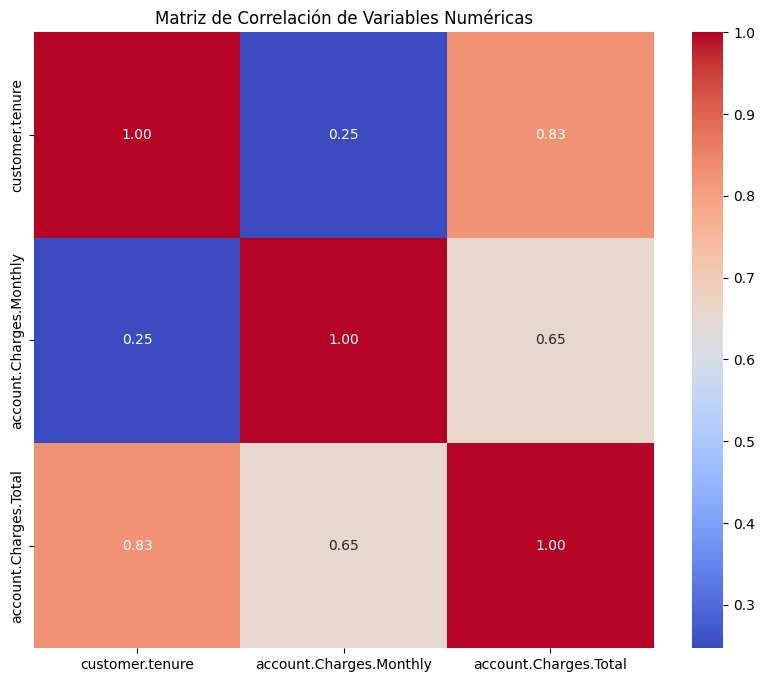

In [21]:
# Calcular la matriz de correlación
# Seleccionar solo las columnas numéricas para el cálculo de correlación
numerical_df = df_cleaned.select_dtypes(include=np.number)
correlation_matrix = numerical_df.corr()

# Crear un mapa de calor para visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

**Inferencias:**

* **customer.tenure y account.Charges.Total:** Se observa una correlación positiva fuerte (aproximadamente 0.83) entre la antigüedad del cliente (customer.tenure) y los cargos totales (account.Charges.Total). Esto es lógico, ya que los clientes que han estado más tiempo con la empresa habrán acumulado mayores cargos totales.

* **account.Charges.Monthly y account.Charges.Total:** Existe una correlación positiva moderada a fuerte (aproximadamente 0.65) entre los cargos mensuales (account.Charges.Monthly) y los cargos totales (account.Charges.Total). Esto también es esperable, ya que los cargos totales son la suma de los cargos mensuales a lo largo del tiempo.

* **customer.tenure y account.Charges.Monthly:** La correlación entre la antigüedad del cliente (customer.tenure) y los cargos mensuales (account.Charges.Monthly) es positiva pero más débil (aproximadamente 0.25). Esto sugiere que, si bien los clientes más antiguos pueden tener cargos mensuales ligeramente más altos en promedio, no es una relación tan directa como con los cargos totales.

Las variables numéricas customer.tenure y account.Charges.Total están fuertemente relacionadas entre sí, lo cual es una relación esperada. account.Charges.Monthly tiene una relación más moderada con ambas. Es importante tener en cuenta estas correlaciones entre account.Charges.Monthl y account.Charges.Total para evitar la multicolinealidad.

## **2.4 ANALISIS SEGMENTADO**

En este analisis se busca dividir un conjunto de datos en grupos o segmentos más pequeños y homogéneos basados en ciertas características:

* Segmentar servicios por telofonia, internet y ambos (telofonia-internet).

* Segmentar servicios por cambinaciones de servicios.

### **2.4.1 Segmentar servicios por telofonia, internet y ambos (telofonia-internet).**

In [22]:
# Crear una nueva columna agrupada para Internet Service
df = df_cleaned.copy()
df['internet_grouped'] = df_cleaned['internet.InternetService'].map({
    'DSL': 'Con Internet',
    'Fiber optic': 'Con Internet',
    'No': 'Sin Internet'
})

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7032 non-null   object 
 1   Churn                      7032 non-null   object 
 2   customer.gender            7032 non-null   object 
 3   customer.SeniorCitizen     7032 non-null   object 
 4   customer.Partner           7032 non-null   object 
 5   customer.Dependents        7032 non-null   object 
 6   customer.tenure            7032 non-null   int64  
 7   phone.PhoneService         7032 non-null   object 
 8   phone.MultipleLines        7032 non-null   object 
 9   internet.InternetService   7032 non-null   object 
 10  internet.OnlineSecurity    7032 non-null   object 
 11  internet.OnlineBackup      7032 non-null   object 
 12  internet.DeviceProtection  7032 non-null   object 
 13  internet.TechSupport       7032 non-null   object 
 1

In [24]:
# Crea nueva columna 'categoria_servicio'
df['categoria_servicio'] = 'Otros' # Initialize with a default value

# Assign 'Solo Teléfonia' to rows meeting the criteria (only phone, no internet)
df.loc[
    (df['internet.InternetService'] == "No") &
    (df['phone.PhoneService'] == "Yes") & (df['phone.MultipleLines'] == "No"),
    'categoria_servicio'
] = 'Solo Teléfonia'

df.loc[
    (df['internet.InternetService'] == "No") &
    (df['phone.PhoneService'] == "Yes") & (df['phone.MultipleLines'] == "Yes"),
    'categoria_servicio'
] = 'Teléfonia+Multi-lineas'



# Solo Internet si los demas servicios de internet
df.loc[
    (df['internet_grouped'] == "Con Internet") &
    (df['phone.PhoneService'] == "No") &
    (df['internet.OnlineSecurity'] == "No") &
    (df['internet.OnlineBackup'] == "No") &
    (df['internet.DeviceProtection'] == "No") &
    (df['internet.TechSupport'] == "No") &
    (df['internet.StreamingTV'] == "No") &
    (df['internet.StreamingMovies'] == "No"),
    'categoria_servicio'
] = 'Solo Internet'

# Assign 'Solo Serv_Internet' to rows meeting the criteria (only internet, no phone)
df.loc[
    (df['internet_grouped'] == "Con Internet") &
    ((df['phone.PhoneService'] == "No") & (df['categoria_servicio'] != "Solo Internet")),
    'categoria_servicio'
] = 'Solo Serv_Internet'

# Assign 'Ambos Servicios' to rows meeting the criteria (both internet and phone)
df.loc[
    (df['internet_grouped'] == "Con Internet") &
    (df['phone.PhoneService'] == "Yes"),
    'categoria_servicio'
] = 'Ambos Servicios'

# Verify the new column and its distribution
print("Distribución de la nueva columna 'categoria_servicio':")
print(df['categoria_servicio'].value_counts())
print("\n")
print(df['categoria_servicio'].value_counts().sum())

Distribución de la nueva columna 'categoria_servicio':
categoria_servicio
Ambos Servicios           4832
Solo Teléfonia            1180
Solo Serv_Internet         600
Teléfonia+Multi-lineas     340
Solo Internet               80
Name: count, dtype: int64


7032


#### **2.4.1.1 Influenicia demografica**

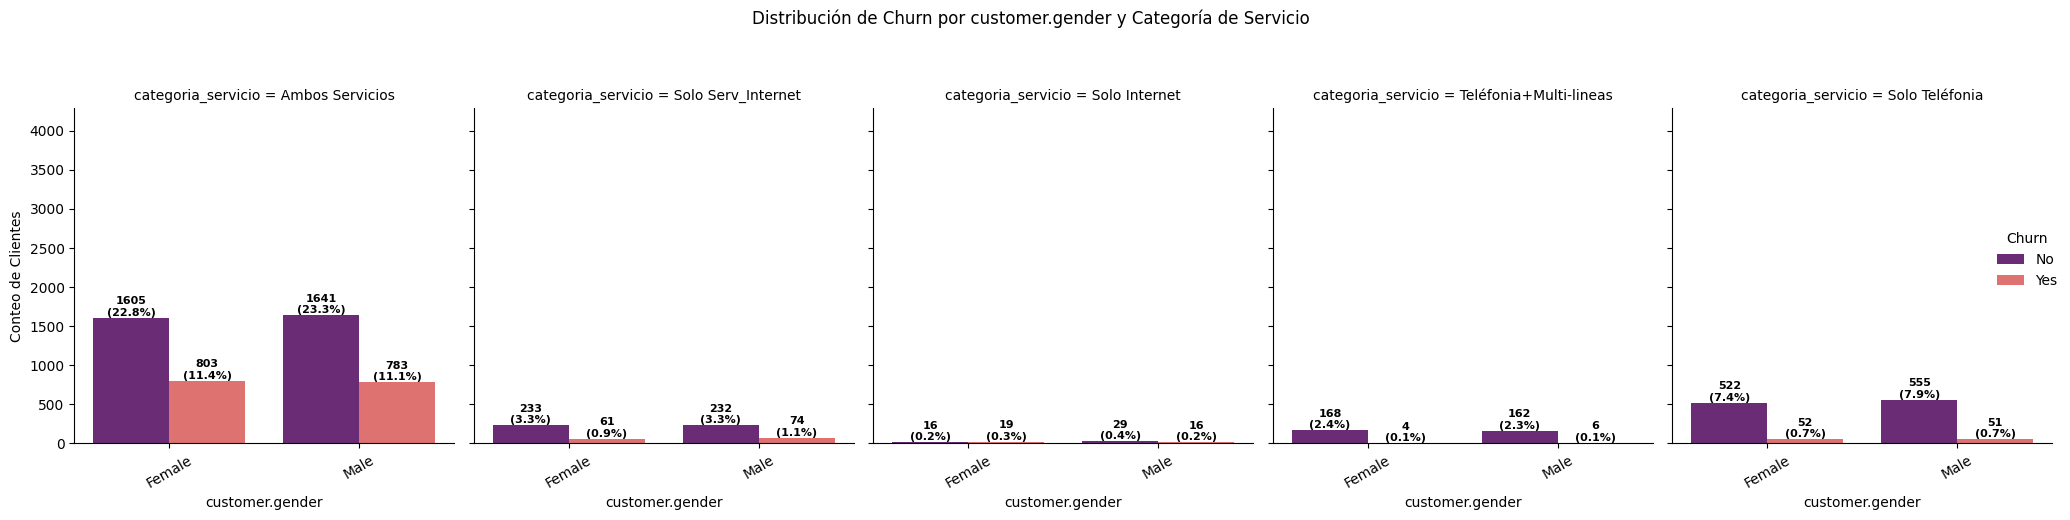

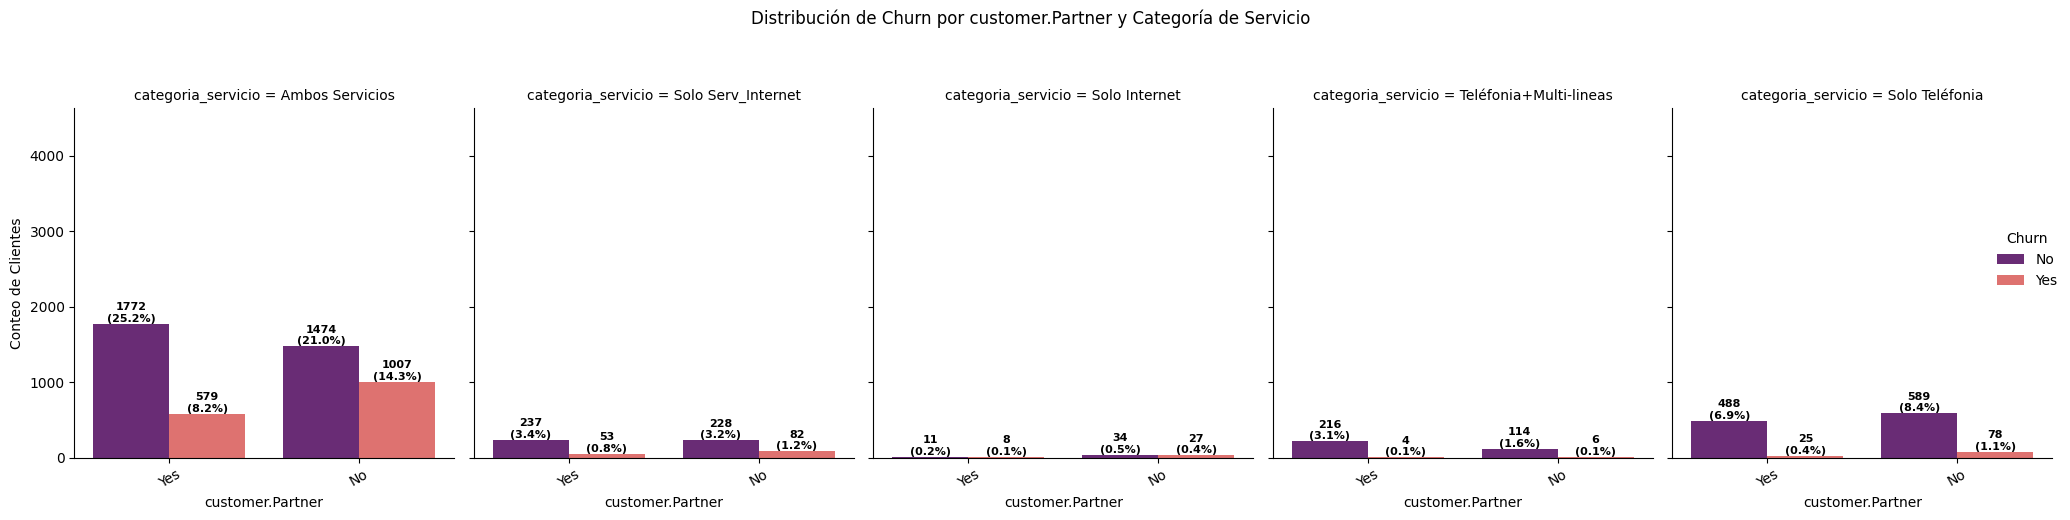

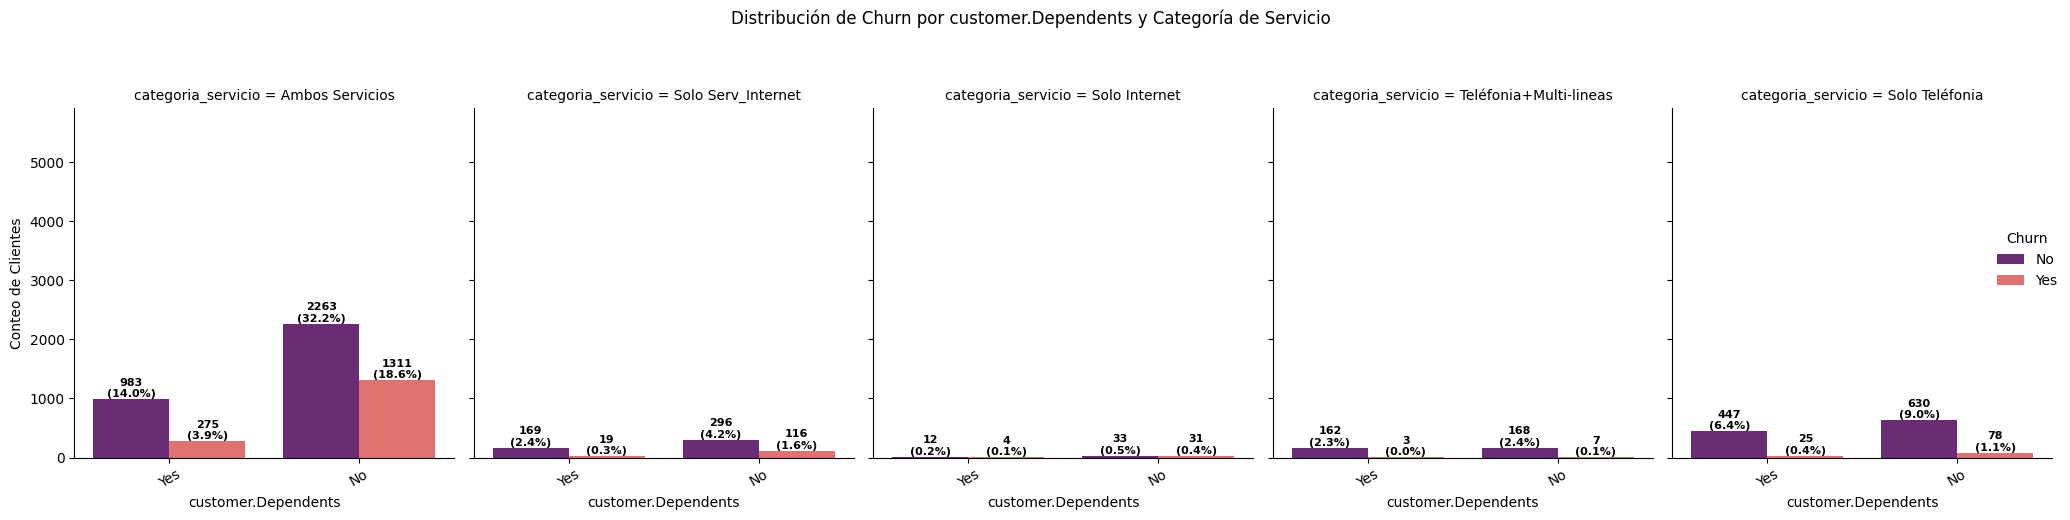

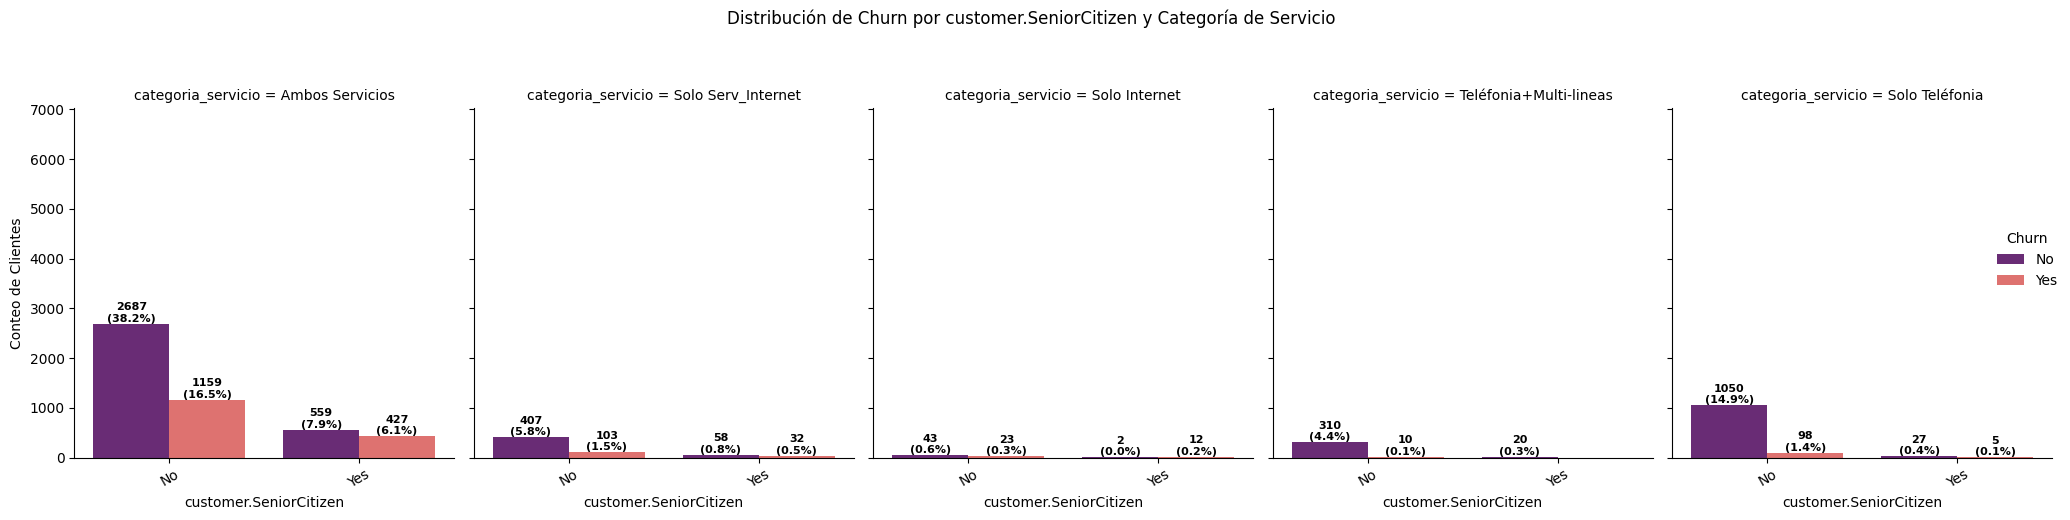

In [25]:
# Lista de columnas demográficas
categoria_demografica = [
    'customer.gender',
    'customer.Partner',
    'customer.Dependents',
    'customer.SeniorCitizen'
]

# Total de registros para calcular porcentajes (usando el df de ejemplo)
total_records = len(df)

# Iteramos sobre cada columna demográfica para crear un gráfico
for col in categoria_demografica:
    # Usamos catplot para crear subplots por 'categoria_servicio'
    g = sns.catplot(
        data= df,
        x=col,
        hue='Churn',
        col='categoria_servicio', # Esto crea los subplots
        kind='count',
        palette='magma',
        height=5,
        aspect=0.8
    )

    # Título general para la figura
    g.fig.suptitle(f'Distribución de Churn por {col} y Categoría de Servicio', y=1.03)
    g.set_xticklabels(rotation=30)
    g.set_xlabels(f'{col}')
    g.set_ylabels('Conteo de Clientes')

    # ── Anotaciones de conteo y porcentaje ───────────────────────────
    # Iteramos sobre cada subplot (ax) en la figura
    for ax in g.axes.flat:
        # Iteramos sobre cada barra (patch) en el subplot
        for patch in ax.patches:
            count = int(patch.get_height())
            if count == 0:
                continue
            pct = 100 * count / total_records
            ax.annotate(
                f'{count}\n({pct:.1f}%)',
                (patch.get_x() + patch.get_width() / 2, patch.get_height()),
                ha='center', va='bottom',
                fontsize=8, fontweight='bold'
            )
        # Ajustar límites del eje Y para dar espacio a las etiquetas
        if ax.get_ylim()[1] > 0: # Solo si hay datos
            y_max = ax.get_ylim()[1]
            ax.set_ylim(0, y_max * 1.20)

    plt.tight_layout(rect=[0, 0, 1, 0.97]) # Ajustar para el suptitle
    plt.show()

**Inferencia:**

El **genero":** no tiene efecto en la decision de seguir con los servicios de la empresa, dado que los porcentajes son similares las tres categorias de servicios.

**La segmentacion de ambos servicio:**

* tener pareja, dependientes, y tercera edad es un influyente para dejar de usar los servicios de la empresa de internet o la combinacion de ambos.

#### **2.4.1.2 Influencia por servicios adicionales**

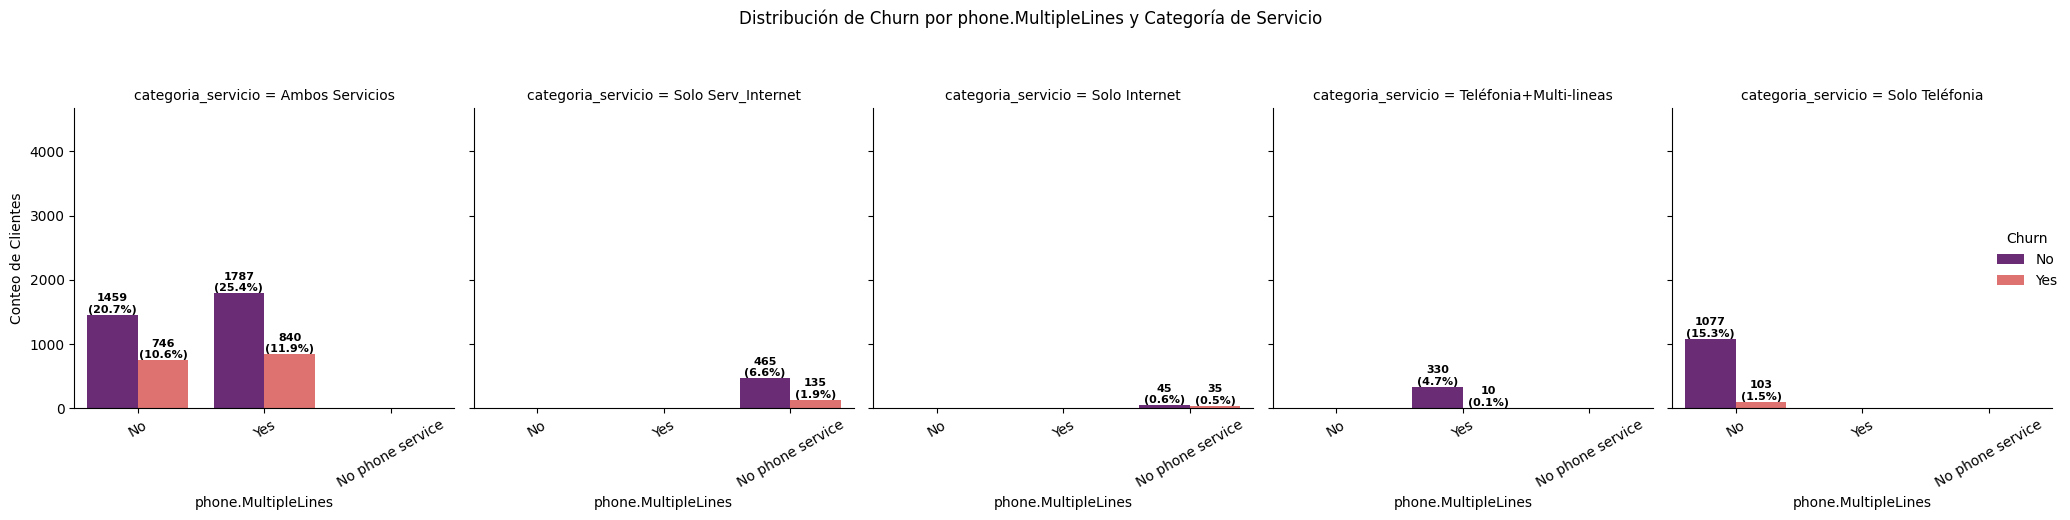

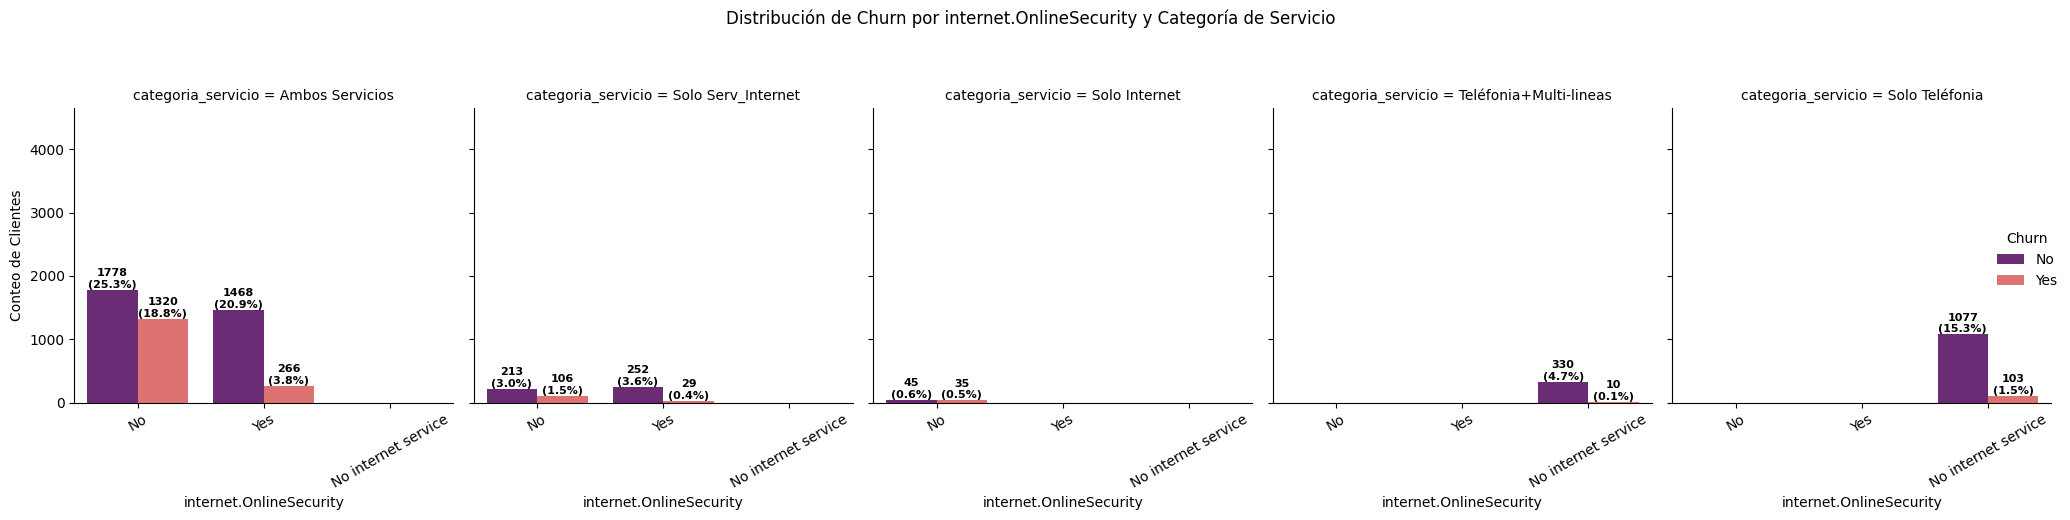

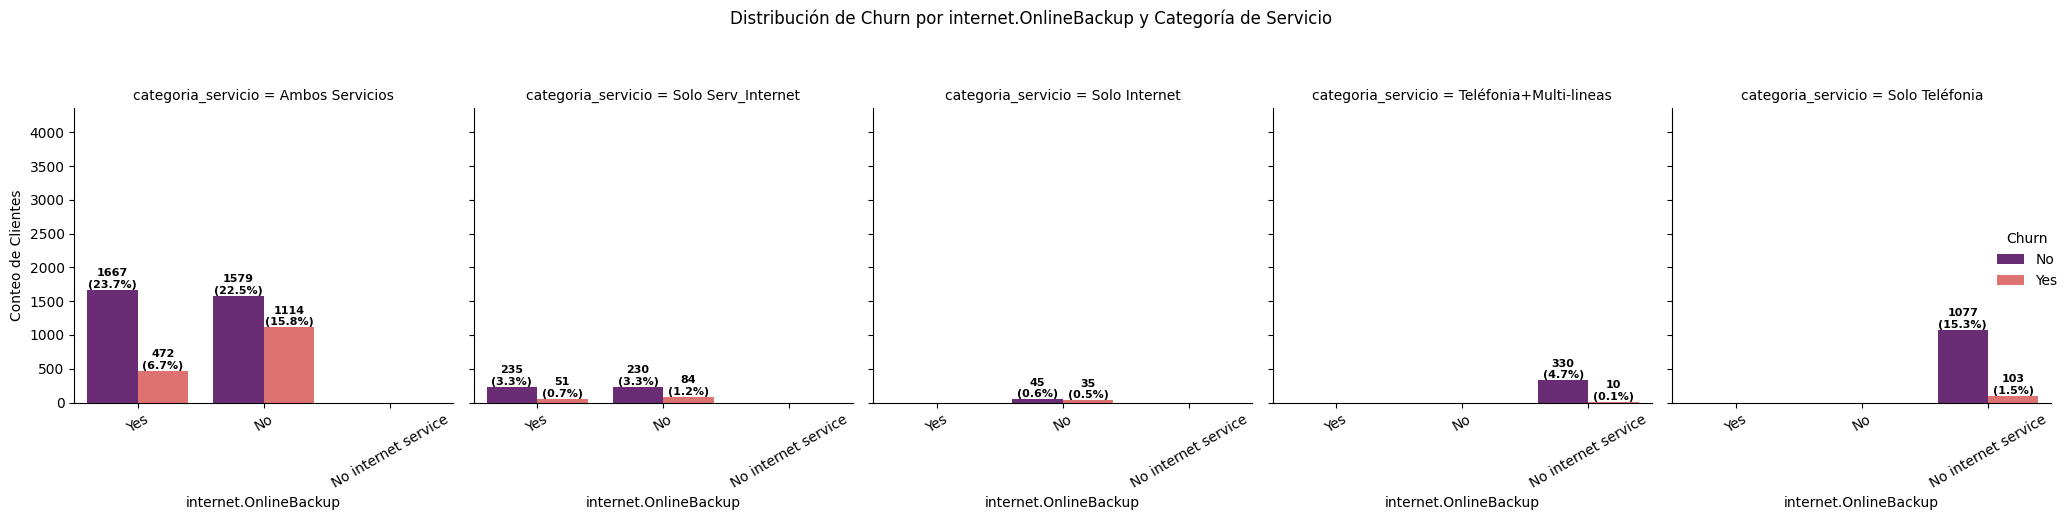

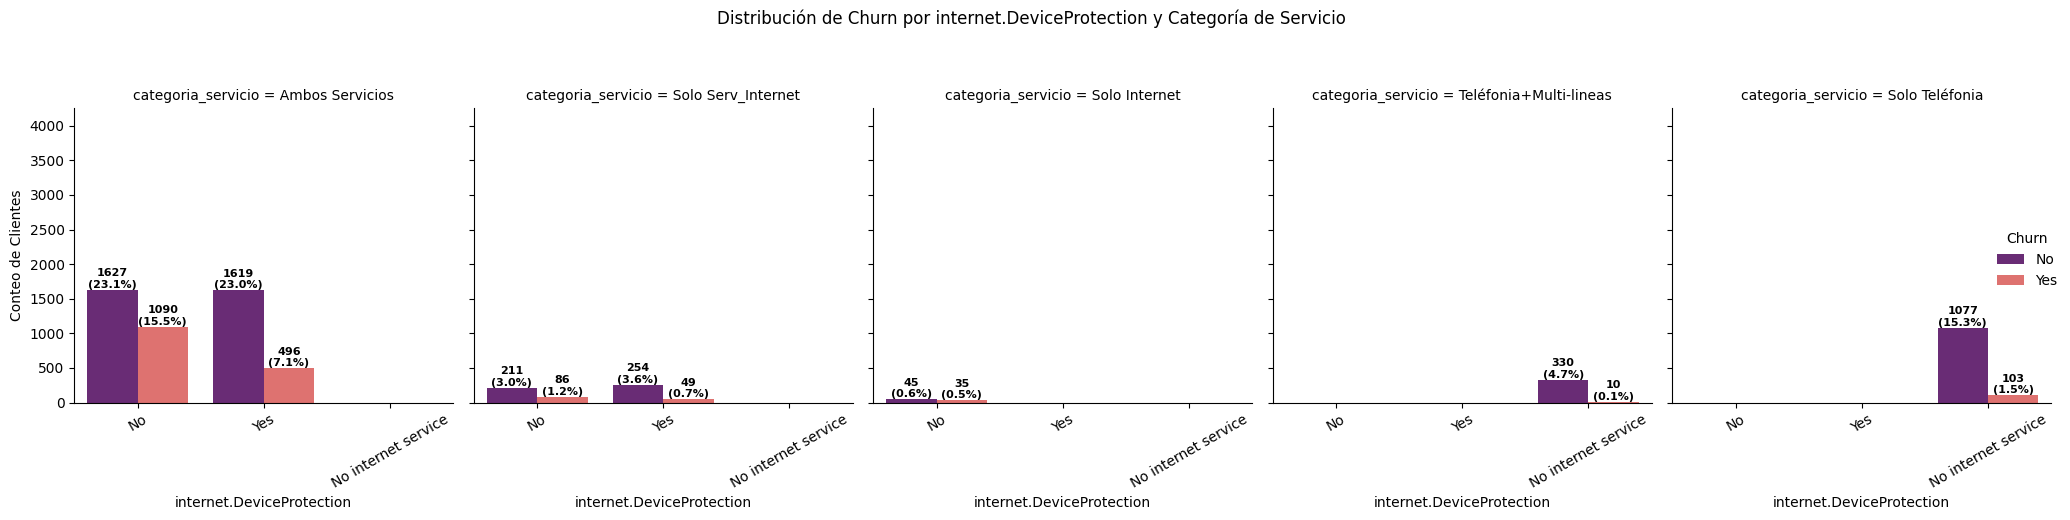

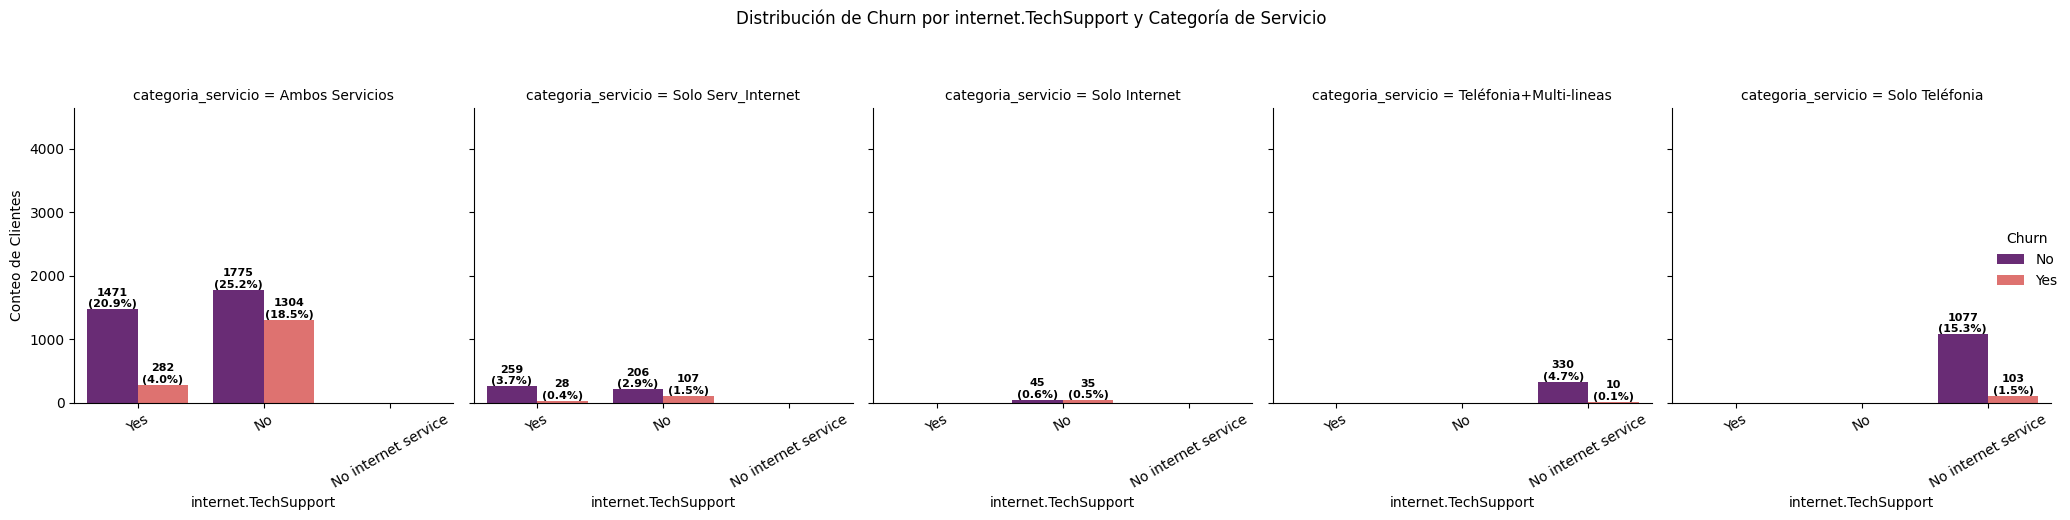

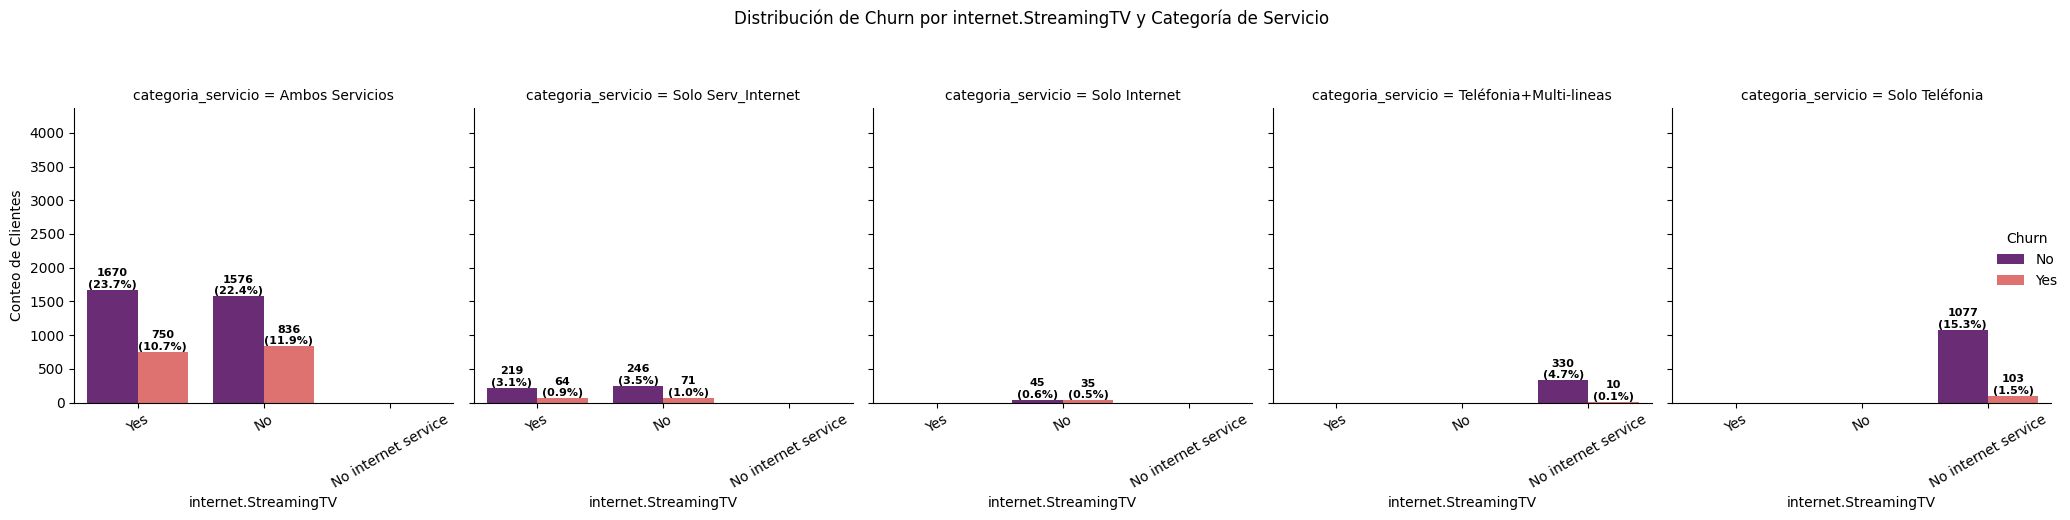

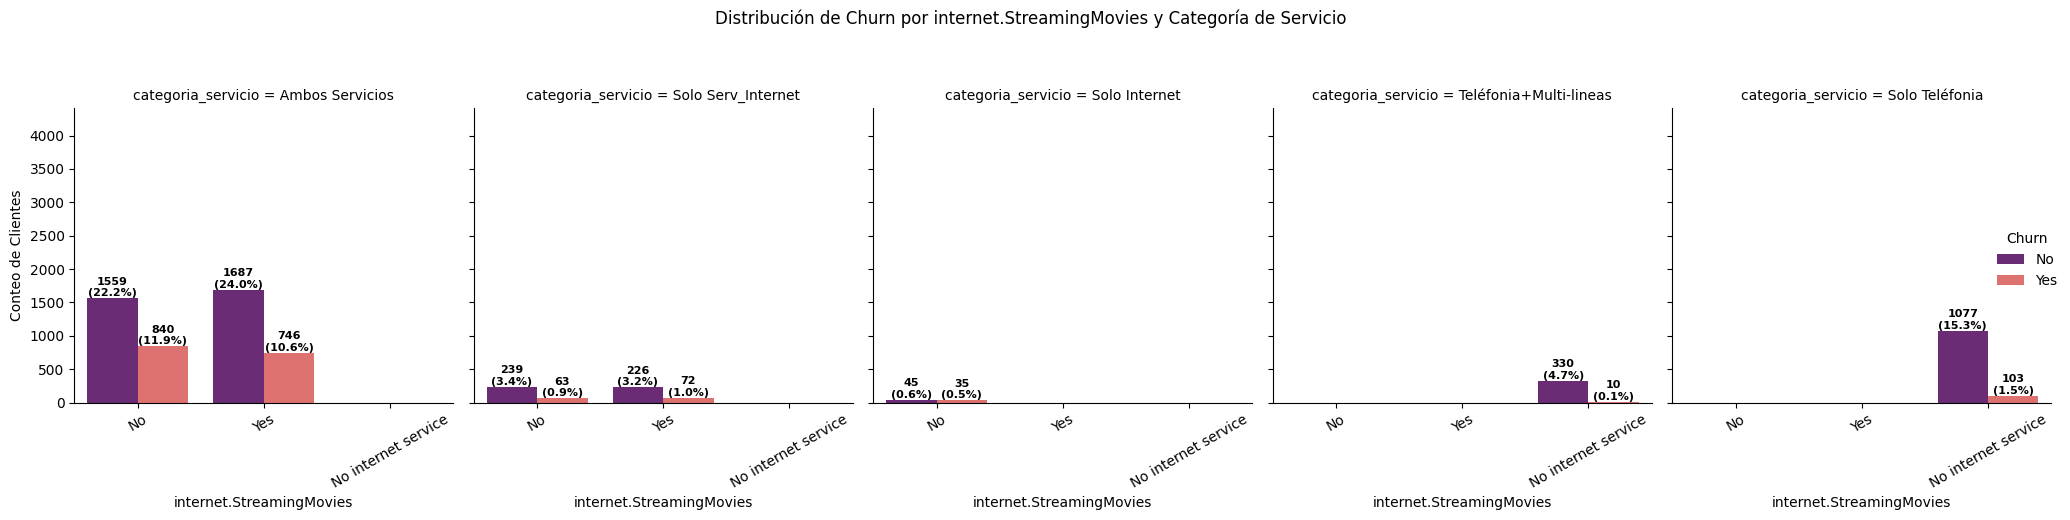

In [26]:
# Lista de columnas demográficas
categoria_servicos = [
    'phone.MultipleLines',
    'internet.OnlineSecurity',
    'internet.OnlineBackup',
    'internet.DeviceProtection',
    'internet.TechSupport',
    'internet.StreamingTV',
    'internet.StreamingMovies'
]

# Total de registros para calcular porcentajes (usando el df de ejemplo)
total_records = len(df)

# Iteramos sobre cada columna demográfica para crear un gráfico
for col in categoria_servicos:
    # Usamos catplot para crear subplots por 'categoria_servicio'
    g = sns.catplot(
        data= df,
        x=col,
        hue='Churn',
        col='categoria_servicio', # Esto crea los subplots
        kind='count',
        palette='magma',
        height=5,
        aspect=0.8
    )

    # Título general para la figura
    g.fig.suptitle(f'Distribución de Churn por {col} y Categoría de Servicio', y=1.03)
    g.set_xticklabels(rotation=30)
    g.set_xlabels(f'{col}')
    g.set_ylabels('Conteo de Clientes')

    # ── Anotaciones de conteo y porcentaje ───────────────────────────
    # Iteramos sobre cada subplot (ax) en la figura
    for ax in g.axes.flat:
        # Iteramos sobre cada barra (patch) en el subplot
        for patch in ax.patches:
            count = int(patch.get_height())
            if count == 0:
                continue
            pct = 100 * count / total_records
            ax.annotate(
                f'{count}\n({pct:.1f}%)',
                (patch.get_x() + patch.get_width() / 2, patch.get_height()),
                ha='center', va='bottom',
                fontsize=8, fontweight='bold'
            )
        # Ajustar límites del eje Y para dar espacio a las etiquetas
        if ax.get_ylim()[1] > 0: # Solo si hay datos
            y_max = ax.get_ylim()[1]
            ax.set_ylim(0, y_max * 1.20)

    plt.tight_layout(rect=[0, 0, 1, 0.97]) # Ajustar para el suptitle
    plt.show()

**Inferencias:**

* Tener multiples lineas no se observa influencia sobre la decision de cancelar los servicios.

* La variable streamingTV no se observa influencia sobre la decision de cancelar los servicios.

* Se observa que no adquirir los servicio incrementa la probabilidad de retiro.

#### **2.4.1.3 Influencia por compartamiento del usuario**

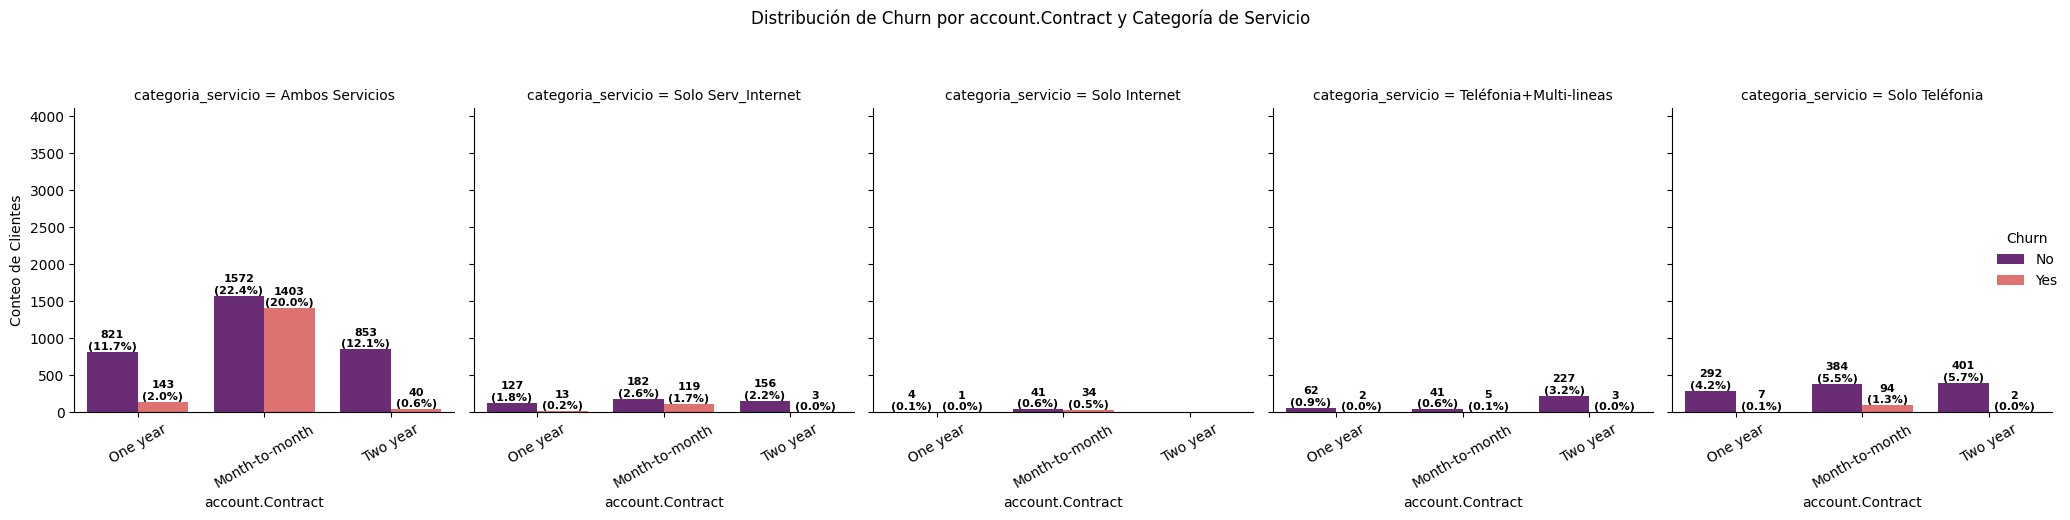

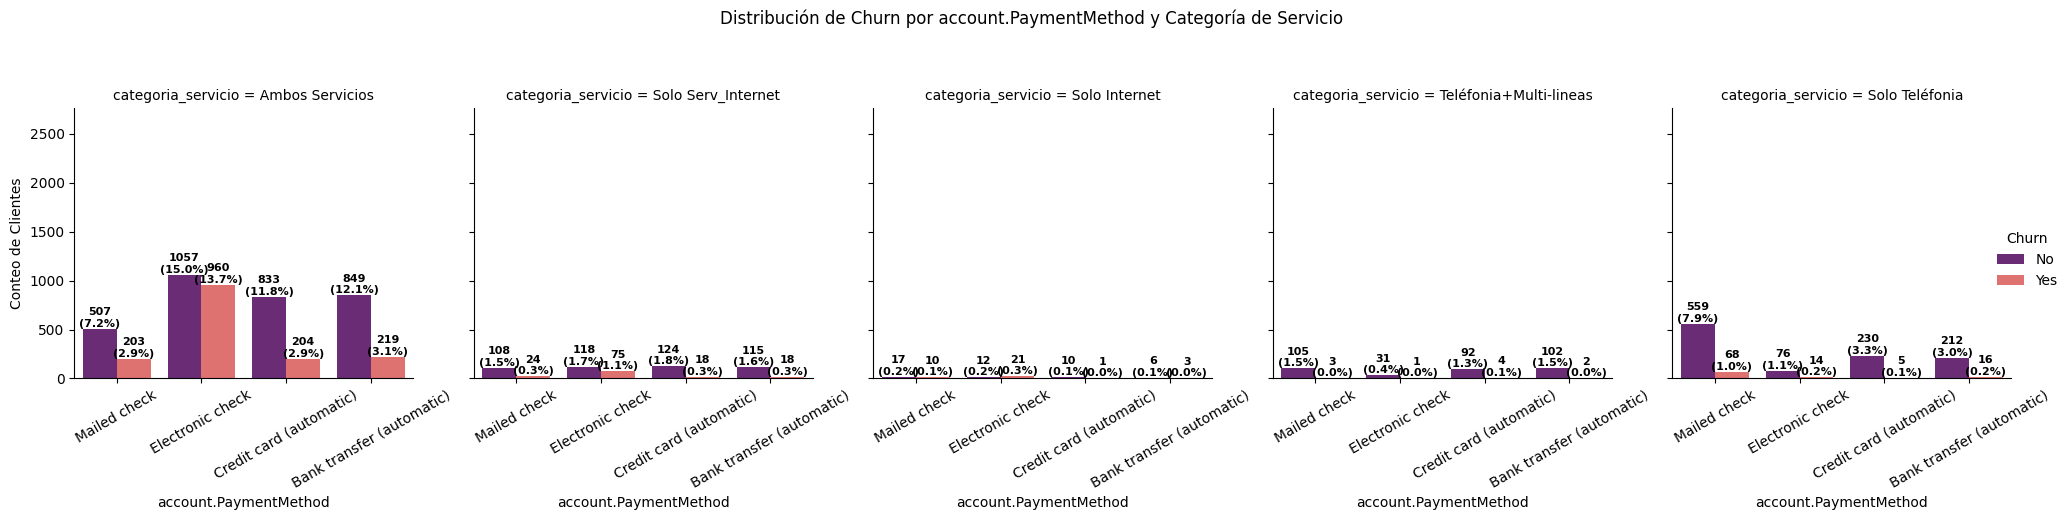

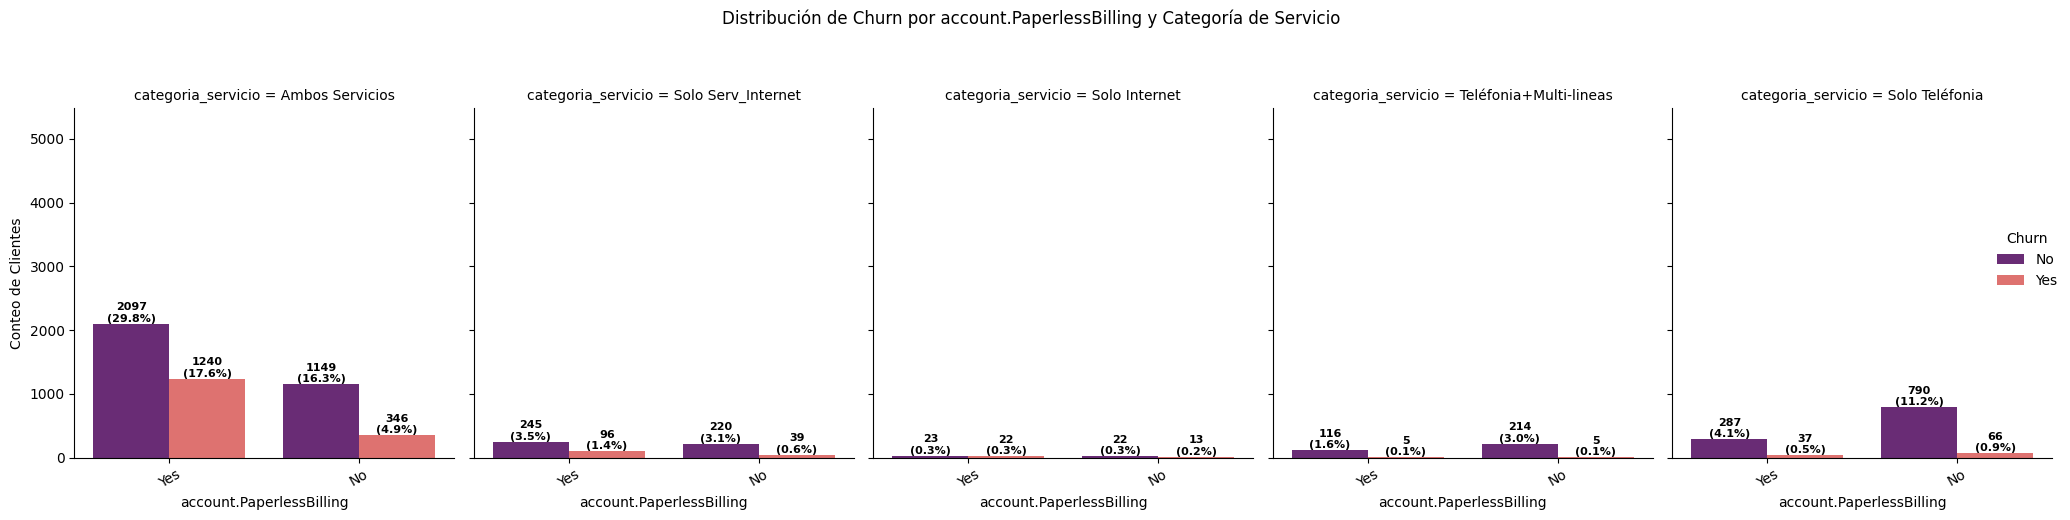

In [27]:
# Lista de columnas demográficas
categoria_comportamiento=['account.Contract',
    'account.PaymentMethod',
    'account.PaperlessBilling']


# Total de registros para calcular porcentajes (usando el df de ejemplo)
total_records = len(df)

# Iteramos sobre cada columna demográfica para crear un gráfico
for col in categoria_comportamiento:
    # Usamos catplot para crear subplots por 'categoria_servicio'
    g = sns.catplot(
        data= df,
        x=col,
        hue='Churn',
        col='categoria_servicio', # Esto crea los subplots
        kind='count',
        palette='magma',
        height=5,
        aspect=0.8
    )

    # Título general para la figura
    g.fig.suptitle(f'Distribución de Churn por {col} y Categoría de Servicio', y=1.03)
    g.set_xticklabels(rotation=30)
    g.set_xlabels(f'{col}')
    g.set_ylabels('Conteo de Clientes')

    # ── Anotaciones de conteo y porcentaje ───────────────────────────
    # Iteramos sobre cada subplot (ax) en la figura
    for ax in g.axes.flat:
        # Iteramos sobre cada barra (patch) en el subplot
        for patch in ax.patches:
            count = int(patch.get_height())
            if count == 0:
                continue
            pct = 100 * count / total_records
            ax.annotate(
                f'{count}\n({pct:.1f}%)',
                (patch.get_x() + patch.get_width() / 2, patch.get_height()),
                ha='center', va='bottom',
                fontsize=8, fontweight='bold'
            )
        # Ajustar límites del eje Y para dar espacio a las etiquetas
        if ax.get_ylim()[1] > 0: # Solo si hay datos
            y_max = ax.get_ylim()[1]
            ax.set_ylim(0, y_max * 1.20)

    plt.tight_layout(rect=[0, 0, 1, 0.97]) # Ajustar para el suptitle
    plt.show()

**Inferencias:**

* En la segmentacion de ambos servicios y solo internet se observa que el contrato mes-mes, cheque electronico y recibir facturacion electronica tiene mayor influencia sobre churn.

/tmp/ipython-input-4196103880.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Churn', y='customer.tenure', palette='magma') # Changed x and y for a better boxplot representation


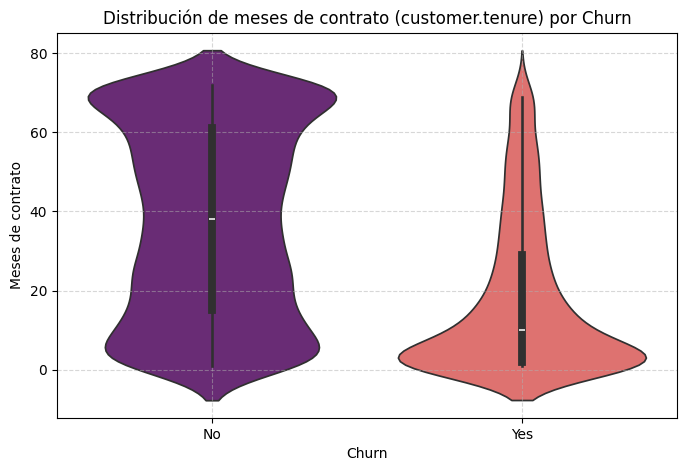

In [28]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, x='Churn', y='customer.tenure', palette='magma') # Changed x and y for a better boxplot representation
plt.title('Distribución de meses de contrato (customer.tenure) por Churn')
plt.xlabel('Churn')
plt.ylabel('Meses de contrato')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**Inferencias:**

* Se observa que hay una proporcion en la distribucion de personas que realizan churn a meses tempranos.

#### **2.4.1.4 Influencia por compartamiento del economico**

/tmp/ipython-input-3478537744.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(


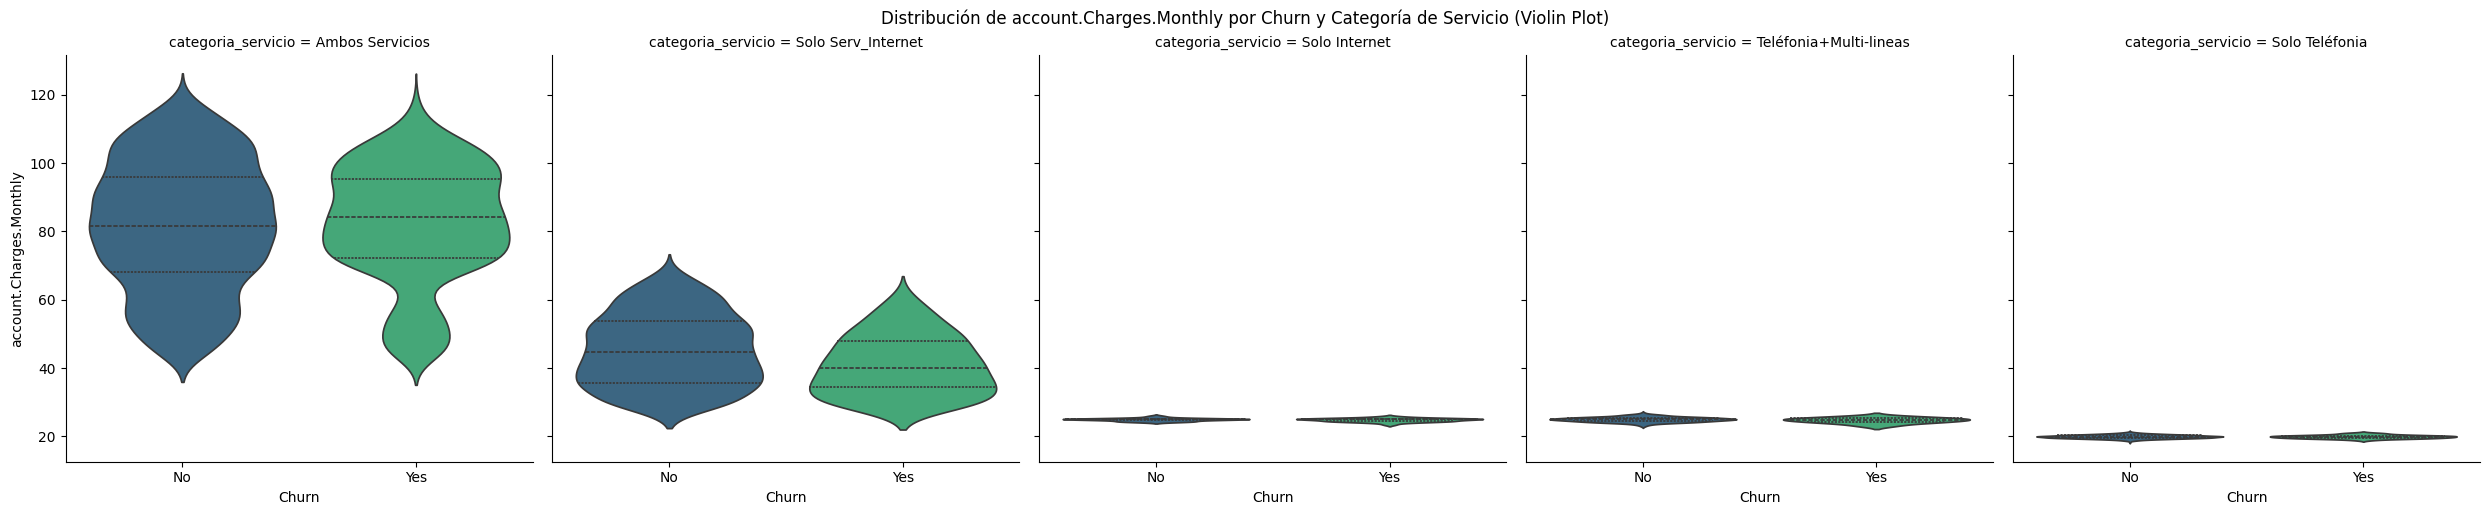

/tmp/ipython-input-3478537744.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(


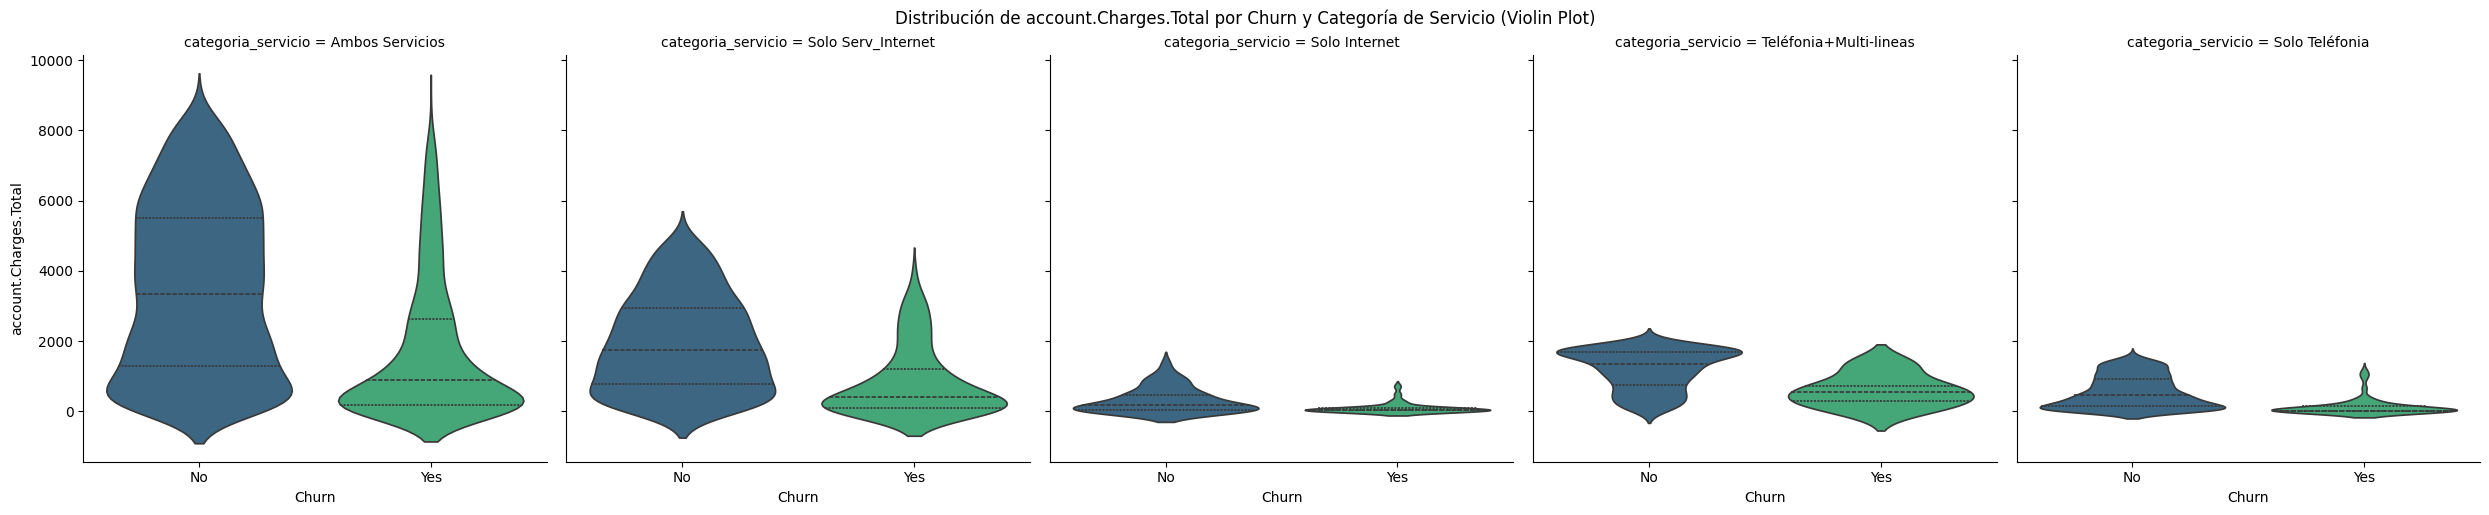

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io



columns_numeric = ['account.Charges.Monthly', 'account.Charges.Total']

for col_num in columns_numeric:
    sns.catplot(
        data=df,
        x='Churn',
        y=col_num,
        col='categoria_servicio',
        kind='violin', # Aquí está el cambio a 'violin'
        palette='viridis',
        inner='quartile' # Muestra las líneas de los cuartiles dentro del violín
    )
    plt.suptitle(f'Distribución de {col_num} por Churn y Categoría de Servicio (Violin Plot)', y=1.02)
    plt.show()

**Inferencias:**

* Se observa que solo usar telefonia es mucho mas economico y se realiza menor churn.

* Cuando se abquiere servicios de solo intenernet sin telofonia se observa que a cargos mensuales y totales bajos se realiza churn.

* Por otra parte cuando se usan los servicios de telofonia e internet precios mensual altos generan mas churn y precios totales bajos generan mayor churn.

### **2.4.2 Segmentar servicios por cambinaciones de servicios.**

Este análisis profundiza en la relación entre los servicios activos que contratan nuestros clientes y su propensión a la fuga (churn). Se han identificado 194 combinaciones únicas de servicios en el dataset, con un total de 7,032 clientes.

In [30]:
# 1. Crear las combinaciones respetando las reglas de negocio
def get_active_services_with_rules(row):
    services = []

    # Servicios de teléfono
    if str(row['phone.PhoneService']).strip().lower() == 'yes':
        services.append('Phone')
        if str(row['phone.MultipleLines']).strip().lower() == 'yes':
            services.append('MultiLine')

    # Servicios de internet
    if str(row['internet_grouped']).strip().lower() == 'con internet':
        services.append('Internet')

        # Solo agregar servicios de internet si tiene internet
        internet_services = {
            'internet.OnlineSecurity': 'Security',
            'internet.OnlineBackup': 'Backup',
            'internet.DeviceProtection': 'DeviceProtection',
            'internet.TechSupport': 'TechSupport',
            'internet.StreamingTV': 'StreamingTV',
            'internet.StreamingMovies': 'StreamingMovies'
        }

        for col, name in internet_services.items():
            if str(row[col]).strip().lower() == 'yes':
                services.append(name)

    return '-'.join(services) if services else 'NoServices'

# 2. Aplicar la función
df['combo_servicios'] = df.apply(get_active_services_with_rules, axis=1)

# 3. Analizar las combinaciones
combo_analysis = df['combo_servicios'].value_counts()

print(f"Total de combinaciones únicas: {len(combo_analysis)}")
print(f"Total de clientes: {len(df)}")
print("\n=== TOP 20 COMBINACIONES ===")
print(combo_analysis.head(23))

# 4. Analizar la distribución por número de servicios
df['num_servicios'] = df['combo_servicios'].apply(lambda x: len(x.split('-')) if x != 'NoServices' else 0)

print("\n=== DISTRIBUCIÓN POR NÚMERO DE SERVICIOS ===")
num_services_dist = df['num_servicios'].value_counts().sort_index()
for num, count in num_services_dist.items():
    pct = 100 * count / len(df)
    print(f"{num} servicios: {count} clientes ({pct:.1f}%)")

# 5. Ver ejemplos de combinaciones por número de servicios
print("\n=== EJEMPLOS POR NÚMERO DE SERVICIOS ===")
for num in sorted(df['num_servicios'].unique()):
    examples = df[df['num_servicios'] == num]['combo_servicios'].value_counts().head(3)
    print(f"\n{num} servicios - Top 3 combinaciones:")
    for combo, count in examples.items():
        pct = 100 * count / len(df)
        print(f"  {combo}: {count} clientes ({pct:.1f}%)")

# 6. Analizar churn por número de servicios
print("\n=== CHURN POR NÚMERO DE SERVICIOS ===")
churn_by_num = df.groupby('num_servicios')['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
for num, churn_rate in churn_by_num.items():
    print(f"{num} servicios: {churn_rate:.1f}% de churn")

Total de combinaciones únicas: 194
Total de clientes: 7032

=== TOP 20 COMBINACIONES ===
combo_servicios
Phone                                                                                                1180
Phone-Internet                                                                                        403
Phone-MultiLine                                                                                       340
Phone-MultiLine-Internet                                                                              210
Phone-MultiLine-Internet-Security-Backup-DeviceProtection-TechSupport-StreamingTV-StreamingMovies     208
Phone-MultiLine-Internet-Backup-DeviceProtection-StreamingTV-StreamingMovies                          148
Phone-MultiLine-Internet-StreamingTV-StreamingMovies                                                  115
Phone-MultiLine-Internet-Backup-DeviceProtection-TechSupport-StreamingTV-StreamingMovies              114
Phone-MultiLine-Internet-DeviceProtection-Strea

**Tasa de Churn por Número de Servicios Activos:**

El análisis de la tasa de churn (porcentaje de clientes que se van dentro de cada grupo) revela un patrón crítico:

* Bajo Churn en Extremos: Los clientes con 1 servicio (11.0% de churn) y aquellos con 8-9 servicios (12.4% y 5.3% de churn respectivamente) muestran las tasas de fuga más bajas. Esto sugiere que los clientes con una oferta muy básica o, por el contrario, una oferta muy completa y robusta, tienden a ser más leales.

* Pico de Churn en Servicios Intermedios: La tasa de churn es significativamente más alta en los clientes con 2 a 4 servicios, alcanzando un máximo del 44.9% en el grupo de 3 servicios. Este segmento representa un punto de inflexión donde los clientes, habiendo contratado varios servicios, aún no están lo suficientemente fidelizados o encuentran motivos para abandonar.

#### **2.4.2.1 Distribución de Churn (Yes/No) por Combinación de Servicios**

In [31]:
import plotly.express as px

# Agrupar por combinación de servicios y churn
combo_churn = (
    df
    .groupby(['combo_servicios', 'Churn'])
    .size()
    .reset_index(name='Cantidad')
)

# Ordenar las combinaciones por el total de clientes (para que el gráfico sea más legible)
orden = (
    combo_churn.groupby('combo_servicios')['Cantidad']
    .sum()
    .sort_values(ascending=False)
    .index
)
combo_churn['combo_servicios'] = pd.Categorical(combo_churn['combo_servicios'], categories=orden, ordered=True)

# Gráfico de barras horizontal apilado
fig = px.bar(
    combo_churn,
    y='combo_servicios',
    x='Cantidad',
    color='Churn',
    orientation='h',
    title='Distribución de Churn (Yes/No) por Combinación de Servicios',
    labels={'combo_servicios': 'Combinación de servicios', 'Cantidad': 'Cantidad de clientes'},
    color_discrete_map={'Yes': 'crimson', 'No': 'teal'}
)

fig.update_layout(
    yaxis={'categoryorder':'total ascending'},
    height=max(800, len(orden) * 25),  # Altura dinámica según número de combinaciones
    barmode='stack'
)

fig.show()

#### **2.4.2.2 Distribución de Churn (Yes/No) por Número de Servicios Activos**

In [32]:
import plotly.express as px

# Agrupar por número de servicios y churn
servicios_churn = (
    df
    .groupby(['num_servicios', 'Churn'])
    .size()
    .reset_index(name='Cantidad')
    .sort_values('num_servicios')
)

# Convertir num_servicios a string para mejor visualización en el eje Y
servicios_churn['num_servicios'] = servicios_churn['num_servicios'].astype(str)

# Gráfico de barras horizontal apilado
fig = px.bar(
    servicios_churn,
    y='num_servicios',
    x='Cantidad',
    color='Churn',
    orientation='h',
    title='Distribución de Churn (Yes/No) por Número de Servicios Activos',
    labels={'num_servicios': 'Número de servicios activos', 'Cantidad': 'Cantidad de clientes'},
    color_discrete_map={'Yes': 'crimson', 'No': 'teal'}
)

fig.update_layout(
    yaxis={'categoryorder':'category ascending'},
    height=600,
    barmode='stack'
)

fig.show()

In [33]:
# Contar cuántas combinaciones únicas hay por número de servicios
combinaciones_por_num = df.groupby('num_servicios')['combo_servicios'].nunique()

print("=== DIVERSIDAD DE COMBINACIONES POR NÚMERO DE SERVICIOS ===")
for num, count in combinaciones_por_num.items():
    total_clientes = (df['num_servicios'] == num).sum()
    print(f"{num} servicios: {count} combinaciones únicas ({total_clientes} clientes total)")

=== DIVERSIDAD DE COMBINACIONES POR NÚMERO DE SERVICIOS ===
1 servicios: 2 combinaciones únicas (1260 clientes total)
2 servicios: 8 combinaciones únicas (857 clientes total)
3 servicios: 22 combinaciones únicas (846 clientes total)
4 servicios: 41 combinaciones únicas (965 clientes total)
5 servicios: 50 combinaciones únicas (921 clientes total)
6 servicios: 41 combinaciones únicas (906 clientes total)
7 servicios: 22 combinaciones únicas (674 clientes total)
8 servicios: 7 combinaciones únicas (395 clientes total)
9 servicios: 1 combinaciones únicas (208 clientes total)


Diversidad y Distribución de Combinaciones de Servicios
Observamos que la mayoría de nuestros clientes se agrupan en combinaciones con un número limitado de servicios, aunque la diversidad de combinaciones aumenta en los niveles intermedios:

  * 1 Servicio (17.9% de clientes): Predominan las combinaciones "Phone" (1,180 clientes) e "Internet" (80 clientes).
  * 2 Servicios (12.2% de clientes): Las combinaciones "Phone-Internet" (403 clientes) y "Phone-MultiLine" (340 clientes) son las más comunes.
  * 3 a 7 Servicios (61.4% de clientes): Estos grupos muestran la mayor variedad de combinaciones, con un número significativo de clientes en cada nivel.
  * 8 y 9 Servicios (8.6% de clientes): Representan un segmento más pequeño de clientes, pero con combinaciones de servicios muy completas y específicas.

#### **2.4.2.3 Distribución de Churn por Combinación y numeros Servicio(s)**

In [34]:
import plotly.express as px
import plotly.graph_objects as go

# Función para crear gráfico por número de servicios
def crear_grafico_churn_por_servicios(num_servicios):
    # Filtrar datos para el número específico de servicios
    datos_filtrados = df[df['num_servicios'] == num_servicios]

    if len(datos_filtrados) == 0:
        print(f"No hay datos para {num_servicios} servicios")
        return

    # Agrupar por combinación y churn
    combo_churn = (
        datos_filtrados
        .groupby(['combo_servicios', 'Churn'])
        .size()
        .reset_index(name='Cantidad')
    )

    # Ordenar combinaciones por total de clientes (mayor a menor)
    orden = (
        combo_churn.groupby('combo_servicios')['Cantidad']
        .sum()
        .sort_values(ascending=False)
        .index
    )
    combo_churn['combo_servicios'] = pd.Categorical(combo_churn['combo_servicios'], categories=orden, ordered=True)

    # Crear gráfico
    fig = px.bar(
        combo_churn,
        y='combo_servicios',
        x='Cantidad',
        color='Churn',
        orientation='h',
        title=f'Distribución de Churn por Combinación - {num_servicios} Servicio(s)',
        labels={'combo_servicios': 'Combinación de servicios', 'Cantidad': 'Cantidad de clientes'},
        color_discrete_map={'Yes': 'crimson', 'No': 'teal'}
    )

    fig.update_layout(
        yaxis={'categoryorder':'total ascending'},
        height=max(400, len(orden) * 40),
        barmode='stack',
        showlegend=True
    )

    fig.show()

# Generar gráficos para 1 a 7 servicios
print("\n=== GENERANDO GRÁFICOS DE CHURN POR COMBINACIÓN ===")
for i in range(1, 8):
    print(f"\nGenerando gráfico para {i} servicio(s)...")
    crear_grafico_churn_por_servicios(i)


=== GENERANDO GRÁFICOS DE CHURN POR COMBINACIÓN ===

Generando gráfico para 1 servicio(s)...



Generando gráfico para 2 servicio(s)...



Generando gráfico para 3 servicio(s)...



Generando gráfico para 4 servicio(s)...



Generando gráfico para 5 servicio(s)...



Generando gráfico para 6 servicio(s)...



Generando gráfico para 7 servicio(s)...


In [35]:

# Función para crear gráfico por número de servicios con porcentajes
def crear_grafico_churn_por_servicios(df, num_servicios):
    # Filtrar datos para el número específico de servicios
    datos_filtrados = df[df['num_servicios'] == num_servicios]

    if len(datos_filtrados) == 0:
        print(f"No hay datos para {num_servicios} servicios")
        return

    # Agrupar por combinación y churn
    combo_churn = (
        datos_filtrados
        .groupby(['combo_servicios', 'Churn'])
        .size()
        .reset_index(name='Cantidad')
    )

    # Calcular totales por combinación
    totales_combo = combo_churn.groupby('combo_servicios')['Cantidad'].sum().reset_index()
    totales_combo.columns = ['combo_servicios', 'Total']

    # Merge para obtener totales
    combo_churn = combo_churn.merge(totales_combo, on='combo_servicios')

    # Calcular porcentajes
    combo_churn['Porcentaje'] = (combo_churn['Cantidad'] / combo_churn['Total'] * 100).round(2)

    # Calcular porcentaje de churn por combinación
    churn_porcentajes = combo_churn[combo_churn['Churn'] == 'Yes'].copy()
    churn_porcentajes = churn_porcentajes[['combo_servicios', 'Porcentaje', 'Total']].rename(columns={'Porcentaje': 'Porcentaje_Churn'})

    # Mostrar tabla de porcentajes de churn
    print(f"\n--- PORCENTAJES DE CHURN PARA {num_servicios} SERVICIO(S) ---")
    churn_ordenado = churn_porcentajes.sort_values('Porcentaje_Churn', ascending=False)
    for _, row in churn_ordenado.iterrows():
        print(f"{row['combo_servicios']}: {row['Porcentaje_Churn']:.1f}% de churn ({int(row['Total'])} clientes)")

    # Ordenar combinaciones por total de clientes (mayor a menor)
    orden = (
        combo_churn.groupby('combo_servicios')['Total']
        .first()
        .sort_values(ascending=False)
        .index
    )
    combo_churn['combo_servicios'] = pd.Categorical(combo_churn['combo_servicios'], categories=orden, ordered=True)

    # Crear gráfico con porcentajes en hover
    fig = px.bar(
        combo_churn,
        y='combo_servicios',
        x='Cantidad',
        color='Churn',
        orientation='h',
        title=f'Distribución de Churn por Combinación - {num_servicios} Servicio(s)',
        labels={'combo_servicios': 'Combinación de servicios', 'Cantidad': 'Cantidad de clientes'},
        color_discrete_map={'Yes': 'crimson', 'No': 'teal'},
        hover_data={'Porcentaje': ':.1f'}
    )

    # Añadir anotaciones con porcentajes de churn
    for combo in churn_porcentajes['combo_servicios']:
        porcentaje = churn_porcentajes[churn_porcentajes['combo_servicios'] == combo]['Porcentaje_Churn'].iloc[0]
        total_combo = combo_churn[combo_churn['combo_servicios'] == combo]['Total'].iloc[0]

        fig.add_annotation(
            y=combo,
            x=total_combo + total_combo * 0.02,  # Posición ligeramente a la derecha
            text=f"{porcentaje:.1f}%",
            showarrow=False,
            font=dict(size=10, color="black"),
            xanchor="left"
        )

    fig.update_layout(
        yaxis={'categoryorder':'total ascending'},
        height=max(400, len(orden) * 40),
        barmode='stack',
        showlegend=True,
        margin=dict(r=80)  # Más margen derecho para las anotaciones
    )

    fig.show()
    return churn_porcentajes

# Generar gráficos para 1 a 7 servicios
print("\n=== GENERANDO GRÁFICOS DE CHURN POR COMBINACIÓN CON PORCENTAJES ===")
for i in range(1, 8):
    print(f"\nGenerando gráfico para {i} servicio(s)...")
    crear_grafico_churn_por_servicios(df, i)


=== GENERANDO GRÁFICOS DE CHURN POR COMBINACIÓN CON PORCENTAJES ===

Generando gráfico para 1 servicio(s)...

--- PORCENTAJES DE CHURN PARA 1 SERVICIO(S) ---
Internet: 43.8% de churn (80 clientes)
Phone: 8.7% de churn (1180 clientes)



Generando gráfico para 2 servicio(s)...

--- PORCENTAJES DE CHURN PARA 2 SERVICIO(S) ---
Internet-StreamingMovies: 72.2% de churn (18 clientes)
Internet-StreamingTV: 58.3% de churn (12 clientes)
Phone-Internet: 51.6% de churn (403 clientes)
Internet-DeviceProtection: 45.5% de churn (11 clientes)
Internet-Backup: 38.7% de churn (31 clientes)
Internet-TechSupport: 28.6% de churn (21 clientes)
Internet-Security: 23.8% de churn (21 clientes)
Phone-MultiLine: 2.9% de churn (340 clientes)



Generando gráfico para 3 servicio(s)...

--- PORCENTAJES DE CHURN PARA 3 SERVICIO(S) ---
Internet-DeviceProtection-StreamingTV: 71.4% de churn (7 clientes)
Internet-DeviceProtection-StreamingMovies: 66.7% de churn (6 clientes)
Phone-Internet-StreamingTV: 65.6% de churn (93 clientes)
Phone-Internet-StreamingMovies: 57.8% de churn (83 clientes)
Internet-Backup-StreamingTV: 57.1% de churn (7 clientes)
Phone-MultiLine-Internet: 56.7% de churn (210 clientes)
Phone-Internet-DeviceProtection: 47.8% de churn (69 clientes)
Internet-StreamingTV-StreamingMovies: 47.6% de churn (21 clientes)
Internet-Security-StreamingMovies: 40.0% de churn (5 clientes)
Internet-TechSupport-StreamingTV: 40.0% de churn (5 clientes)
Phone-Internet-Backup: 38.7% de churn (93 clientes)
Phone-Internet-Security: 30.9% de churn (97 clientes)
Internet-Backup-StreamingMovies: 25.0% de churn (8 clientes)
Phone-Internet-TechSupport: 24.6% de churn (57 clientes)
Internet-Backup-DeviceProtection: 22.2% de churn (9 clientes)
I


Generando gráfico para 4 servicio(s)...

--- PORCENTAJES DE CHURN PARA 4 SERVICIO(S) ---
Phone-MultiLine-Internet-StreamingMovies: 70.2% de churn (84 clientes)
Phone-Internet-StreamingTV-StreamingMovies: 56.1% de churn (82 clientes)
Phone-MultiLine-Internet-StreamingTV: 56.1% de churn (66 clientes)
Phone-Internet-Backup-StreamingMovies: 48.0% de churn (25 clientes)
Phone-Internet-TechSupport-StreamingTV: 41.2% de churn (17 clientes)
Phone-MultiLine-Internet-DeviceProtection: 40.9% de churn (44 clientes)
Phone-MultiLine-Internet-Backup: 40.0% de churn (85 clientes)
Internet-TechSupport-StreamingTV-StreamingMovies: 40.0% de churn (5 clientes)
Internet-DeviceProtection-StreamingTV-StreamingMovies: 39.1% de churn (23 clientes)
Internet-Backup-StreamingTV-StreamingMovies: 38.9% de churn (18 clientes)
Internet-Backup-DeviceProtection-StreamingMovies: 37.5% de churn (8 clientes)
Phone-Internet-DeviceProtection-StreamingTV: 37.0% de churn (27 clientes)
Phone-Internet-Security-StreamingTV: 35.


Generando gráfico para 5 servicio(s)...

--- PORCENTAJES DE CHURN PARA 5 SERVICIO(S) ---
Phone-MultiLine-Internet-StreamingTV-StreamingMovies: 65.2% de churn (115 clientes)
Phone-Internet-DeviceProtection-StreamingTV-StreamingMovies: 51.9% de churn (52 clientes)
Phone-Internet-Security-StreamingTV-StreamingMovies: 50.0% de churn (18 clientes)
Phone-MultiLine-Internet-Backup-StreamingTV: 47.2% de churn (36 clientes)
Phone-MultiLine-Internet-DeviceProtection-StreamingMovies: 46.9% de churn (32 clientes)
Phone-MultiLine-Internet-Backup-DeviceProtection: 46.1% de churn (26 clientes)
Phone-MultiLine-Internet-TechSupport-StreamingTV: 44.4% de churn (18 clientes)
Phone-MultiLine-Internet-Backup-StreamingMovies: 43.8% de churn (32 clientes)
Phone-Internet-Backup-StreamingTV-StreamingMovies: 37.5% de churn (32 clientes)
Phone-Internet-Backup-TechSupport-StreamingMovies: 35.7% de churn (14 clientes)
Phone-MultiLine-Internet-DeviceProtection-TechSupport: 35.3% de churn (17 clientes)
Phone-Intern


Generando gráfico para 6 servicio(s)...

--- PORCENTAJES DE CHURN PARA 6 SERVICIO(S) ---
Phone-MultiLine-Internet-DeviceProtection-StreamingTV-StreamingMovies: 52.6% de churn (114 clientes)
Phone-MultiLine-Internet-Backup-StreamingTV-StreamingMovies: 50.6% de churn (77 clientes)
Phone-MultiLine-Internet-TechSupport-StreamingTV-StreamingMovies: 39.0% de churn (41 clientes)
Phone-MultiLine-Internet-Security-StreamingTV-StreamingMovies: 37.1% de churn (35 clientes)
Phone-Internet-Backup-DeviceProtection-TechSupport-StreamingTV: 33.3% de churn (12 clientes)
Phone-Internet-Backup-DeviceProtection-StreamingTV-StreamingMovies: 31.2% de churn (32 clientes)
Phone-MultiLine-Internet-Backup-DeviceProtection-StreamingTV: 28.1% de churn (32 clientes)
Phone-Internet-DeviceProtection-TechSupport-StreamingTV-StreamingMovies: 25.0% de churn (40 clientes)
Phone-MultiLine-Internet-Security-Backup-StreamingMovies: 25.0% de churn (28 clientes)
Phone-Internet-Backup-TechSupport-StreamingTV-StreamingMovies:


Generando gráfico para 7 servicio(s)...

--- PORCENTAJES DE CHURN PARA 7 SERVICIO(S) ---
Phone-MultiLine-Internet-Backup-DeviceProtection-StreamingTV-StreamingMovies: 41.9% de churn (148 clientes)
Phone-MultiLine-Internet-DeviceProtection-TechSupport-StreamingTV-StreamingMovies: 36.4% de churn (66 clientes)
Phone-MultiLine-Internet-Security-DeviceProtection-StreamingTV-StreamingMovies: 31.1% de churn (45 clientes)
Phone-MultiLine-Internet-Security-Backup-StreamingTV-StreamingMovies: 29.2% de churn (24 clientes)
Phone-MultiLine-Internet-Security-TechSupport-StreamingTV-StreamingMovies: 26.7% de churn (15 clientes)
Phone-Internet-Security-Backup-TechSupport-StreamingTV-StreamingMovies: 24.0% de churn (25 clientes)
Phone-MultiLine-Internet-Security-Backup-DeviceProtection-StreamingTV: 22.7% de churn (22 clientes)
Phone-MultiLine-Internet-Backup-DeviceProtection-TechSupport-StreamingMovies: 20.0% de churn (10 clientes)
Phone-Internet-Security-Backup-DeviceProtection-StreamingTV-StreamingM

In [36]:
# Resumen ejecutivo de las combinaciones más problemáticas
print("\n=== RESUMEN EJECUTIVO: TOP COMBINACIONES CON MÁS CHURN ===")

# Calcular churn absoluto por combinación
churn_por_combo = (
    df[df['Churn'] == 'Yes']
    .groupby(['combo_servicios', 'num_servicios'])
    .size()
    .reset_index(name='Churn_Count')
    .sort_values('Churn_Count', ascending=False)
)

print("Top 10 combinaciones con más churn absoluto:")
for idx, row in churn_por_combo.head(10).iterrows():
    print(f"  {row['combo_servicios']} ({row['num_servicios']} servicios): {row['Churn_Count']} clientes con churn")


=== RESUMEN EJECUTIVO: TOP COMBINACIONES CON MÁS CHURN ===
Top 10 combinaciones con más churn absoluto:
  Phone-Internet (2 servicios): 208 clientes con churn
  Phone-MultiLine-Internet (3 servicios): 119 clientes con churn
  Phone (1 servicios): 103 clientes con churn
  Phone-MultiLine-Internet-StreamingTV-StreamingMovies (5 servicios): 75 clientes con churn
  Phone-MultiLine-Internet-Backup-DeviceProtection-StreamingTV-StreamingMovies (7 servicios): 62 clientes con churn
  Phone-Internet-StreamingTV (3 servicios): 61 clientes con churn
  Phone-MultiLine-Internet-DeviceProtection-StreamingTV-StreamingMovies (6 servicios): 60 clientes con churn
  Phone-MultiLine-Internet-StreamingMovies (4 servicios): 59 clientes con churn
  Phone-Internet-StreamingMovies (3 servicios): 48 clientes con churn
  Phone-Internet-StreamingTV-StreamingMovies (4 servicios): 46 clientes con churn


**Identificación de Combinaciones con Mayor Churn Absoluto:**

Al analizar las combinaciones que contribuyen con el mayor número de clientes que abandonan el servicio, se destacan las siguientes:

* "Phone-Internet" (2 servicios): Con 208 clientes en churn, esta combinación es la que más contribuye a la fuga en términos absolutos.
* "Phone-MultiLine-Internet" (3 servicios): Registra 119 clientes en churn.
* "Phone" (1 servicio): A pesar de ser una combinación básica, contribuye con 103 clientes en churn.
Otras combinaciones con un alto número de churn incluyen servicios de streaming, backup y protección de dispositivos, lo que sugiere que la complejidad o el tipo de servicios adicionales pueden influir en la decisión de irse.

#### **2.4.2.4 Distribución de Churn por numeros Servicio(s) y cargo mensual-total**

In [37]:
# Stripplot para Cargo mensual
fig1 = px.strip(
    df,
    x='num_servicios',
    y='account.Charges.Monthly',
    color='Churn',
    title='Stripplot: Cargo Mensual vs Número de Servicios y Churn',
    labels={'num_servicios': 'Número de servicios', 'account.Charges.Monthly': 'Cargo mensual'},
    stripmode='overlay',  # para que los puntos se superpongan con jitter
)
fig1.show()

# Stripplot para Cargo total
fig2 = px.strip(
    df,
    x='num_servicios',
    y='account.Charges.Total',
    color='Churn',
    title='Stripplot: Cargo Total vs Número de Servicios y Churn',
    labels={'num_servicios': 'Número de servicios', 'account.Charges.Total': 'Cargo total'},
    stripmode='overlay',
)
fig2.show()

In [38]:
# Density heatmap para Cargo mensual vs Número de servicios, separado por churn
fig = px.density_heatmap(
    df,
    x='num_servicios',
    y='account.Charges.Monthly',
    facet_col='Churn',
    nbinsx=9,  # número de servicios de 1 a 9
    nbinsy=30,  # ajusta según tu rango de cargos
    color_continuous_scale='Viridis',
    title='Densidad de Cargo Mensual vs Número de Servicios, por Churn'
)
fig.show()

In [39]:
# Density heatmap para Cargo mensual vs Número de servicios, separado por churn
fig = px.density_heatmap(
    df,
    x='num_servicios',
    y='account.Charges.Total',
    facet_col='Churn',
    nbinsx=9,  # número de servicios de 1 a 9
    nbinsy=30,  # ajusta según tu rango de cargos
    color_continuous_scale='Viridis',
    title='Densidad de Cargo Total vs Número de Servicios, por Churn'
)
fig.show()

**Inferencias:**

* Se observa que segmentar los usuarios por numero de servicios presenta agrupacion de usuarios que relizan churn

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7032 non-null   object 
 1   Churn                      7032 non-null   object 
 2   customer.gender            7032 non-null   object 
 3   customer.SeniorCitizen     7032 non-null   object 
 4   customer.Partner           7032 non-null   object 
 5   customer.Dependents        7032 non-null   object 
 6   customer.tenure            7032 non-null   int64  
 7   phone.PhoneService         7032 non-null   object 
 8   phone.MultipleLines        7032 non-null   object 
 9   internet.InternetService   7032 non-null   object 
 10  internet.OnlineSecurity    7032 non-null   object 
 11  internet.OnlineBackup      7032 non-null   object 
 12  internet.DeviceProtection  7032 non-null   object 
 13  internet.TechSupport       7032 non-null   object 
 1

# **3. PREPROCESAMIENTO DEL DATASET**

## **3.1 Seleccion de caracteristicas**

Se elimina la columna 'custemerID' debido a que es numero consecutivo y no tiene influencia sobre la variable objetivo

In [41]:
df.drop('customerID', axis=1, inplace=True)
df.drop('customer.gender', axis=1, inplace=True)

In [42]:
df.sample(16)

Churn customer.SeniorCitizen customer.Partner customer.Dependents  \
6685    No                     No              Yes                  No   
3975    No                     No               No                  No   
6145    No                     No              Yes                 Yes   
2015   Yes                     No              Yes                 Yes   
1084    No                     No               No                  No   
6551    No                    Yes              Yes                  No   
5908    No                     No              Yes                 Yes   
6091   Yes                    Yes              Yes                  No   
862     No                     No               No                  No   
4897    No                     No              Yes                  No   
3530    No                     No              Yes                  No   
2811    No                     No              Yes                 Yes   
5851   Yes                    Yes               No                  No   
490    Yes                     No              Yes                  No   
6153    No                     No               No                 Yes   
5936    No                     No               No                  No   

      customer.tenure phone.PhoneService phone.MultipleLines  \
6685               63                Yes                 Yes   
3975                2                Yes                  No   
6145               15                Yes                 Yes   
2015               14                Yes                 Yes   
1084                1                Yes                  No   
6551               72                Yes                 Yes   
5908               67                 No    No phone service   
6091               43                Yes                 Yes   
862                 9                Yes                 Yes   
4897               70                Yes                  No   
3530               56                Yes                  No   
2811               24                Yes                 Yes   
5851                1                Yes                  No   
490                53                Yes                  No   
6153               66                Yes                  No   
5936               12                Yes                 Yes   

     internet.InternetService internet.OnlineSecurity internet.OnlineBackup  \
6685                      DSL                     Yes                   Yes   
3975              Fiber optic                      No                    No   
6145                       No     No internet service   No internet service   
2015              Fiber optic                      No                    No   
1084                      DSL                      No                    No   
6551              Fiber optic                      No                   Yes   
5908                      DSL                     Yes                    No   
6091              Fiber optic                      No                    No   
862               Fiber optic                      No                    No   
4897                      DSL                     Yes                   Yes   
3530              Fiber optic                      No                    No   
2811                       No     No internet service   No internet service   
5851              Fiber optic                      No                    No   
490               Fiber optic                      No                    No   
6153                      DSL                      No                   Yes   
5936              Fiber optic                     Yes                    No   

      ... internet.StreamingMovies account.Contract account.PaperlessBilling  \
6685  ...                      Yes         One year                      Yes   
3975  ...                       No   Month-to-month                       No   
6145  ...      No internet service   Month-to-month                      

## 3.2 Division caracteristicas y variable objetivo

In [43]:
X = df.drop('Churn', axis=1)
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [44]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer.SeniorCitizen     7032 non-null   object 
 1   customer.Partner           7032 non-null   object 
 2   customer.Dependents        7032 non-null   object 
 3   customer.tenure            7032 non-null   int64  
 4   phone.PhoneService         7032 non-null   object 
 5   phone.MultipleLines        7032 non-null   object 
 6   internet.InternetService   7032 non-null   object 
 7   internet.OnlineSecurity    7032 non-null   object 
 8   internet.OnlineBackup      7032 non-null   object 
 9   internet.DeviceProtection  7032 non-null   object 
 10  internet.TechSupport       7032 non-null   object 
 11  internet.StreamingTV       7032 non-null   object 
 12  internet.StreamingMovies   7032 non-null   object 
 13  account.Contract           7032 non-null   object 
 1

In [45]:
# ========================================
# PASO 2: CALCULAR VIF INICIAL
# ========================================
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

print("\n=== ANÁLISIS DE MULTICOLINEALIDAD (VIF) ===")

# Select only the numerical columns using select_dtypes
X_numerical = X.select_dtypes(include=np.number)
print(X_numerical.info())

# Calcular VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_numerical.columns
vif_data["VIF"] = [variance_inflation_factor(X_numerical.values, i) for i in range(X_numerical.shape[1])]

# Mostrar variables con VIF problemático
print("Variables con VIF > 10:")
high_vif = vif_data[vif_data['VIF'] > 10]
print(high_vif)


=== ANÁLISIS DE MULTICOLINEALIDAD (VIF) ===
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer.tenure          7032 non-null   int64  
 1   account.Charges.Monthly  7032 non-null   float64
 2   account.Charges.Total    7032 non-null   float64
 3   num_servicios            7032 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 532.7 KB
None
Variables con VIF > 10:
                   feature        VIF
1  account.Charges.Monthly  15.825315
3            num_servicios  22.342499


In [46]:
vif_data

feature        VIF
0          customer.tenure   6.403955
1  account.Charges.Monthly  15.825315
2    account.Charges.Total   9.060950
3            num_servicios  22.342499

In [47]:
X_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer.tenure          7032 non-null   int64  
 1   account.Charges.Monthly  7032 non-null   float64
 2   account.Charges.Total    7032 non-null   float64
 3   num_servicios            7032 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 532.7 KB


In [48]:
X_numerical = X_numerical.drop(columns='account.Charges.Monthly')

In [49]:
# ========================================
# PASO 4: RECALCULAR VIF DESPUÉS DE ELIMINACIÓN
# ========================================

print("\n=== VERIFICACIÓN DE VIF DESPUÉS DE ELIMINACIÓN ===")

# Recalcular VIF
vif_data_final = pd.DataFrame()
vif_data_final["feature"] = X_numerical.columns
vif_data_final["VIF"] = [variance_inflation_factor(X_numerical.values, i) for i in range(X_numerical.shape[1])]

# Mostrar variables que aún tienen VIF alto
print("Variables con VIF > 10 después de eliminación:")
high_vif_final = vif_data_final[vif_data_final['VIF'] > 10]
print(high_vif_final)

print("Variables con VIF > 5 después de eliminación:")
moderate_vif_final = vif_data_final[vif_data_final['VIF'] > 5]
print(moderate_vif_final)


=== VERIFICACIÓN DE VIF DESPUÉS DE ELIMINACIÓN ===
Variables con VIF > 10 después de eliminación:
Empty DataFrame
Columns: [feature, VIF]
Index: []
Variables con VIF > 5 después de eliminación:
                 feature       VIF
0        customer.tenure  6.384607
1  account.Charges.Total  8.992101


In [50]:
vif_data_final

feature       VIF
0        customer.tenure  6.384607
1  account.Charges.Total  8.992101
2          num_servicios  4.745234

In [51]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer.SeniorCitizen     7032 non-null   object 
 1   customer.Partner           7032 non-null   object 
 2   customer.Dependents        7032 non-null   object 
 3   customer.tenure            7032 non-null   int64  
 4   phone.PhoneService         7032 non-null   object 
 5   phone.MultipleLines        7032 non-null   object 
 6   internet.InternetService   7032 non-null   object 
 7   internet.OnlineSecurity    7032 non-null   object 
 8   internet.OnlineBackup      7032 non-null   object 
 9   internet.DeviceProtection  7032 non-null   object 
 10  internet.TechSupport       7032 non-null   object 
 11  internet.StreamingTV       7032 non-null   object 
 12  internet.StreamingMovies   7032 non-null   object 
 13  account.Contract           7032 non-null   object 
 1

Eliminacion

Las siguiente variables son eliminidas debido a su multi-colinelidad

In [52]:
X.drop('internet_grouped', axis=1, inplace=True)
X.drop('combo_servicios', axis=1, inplace=True)
X.drop('account.Charges.Monthly', axis=1, inplace=True)
X.drop('categoria_servicio', axis=1, inplace=True)

## **3.3 Transformacion de las caracteristicas**

In [53]:
# Selecciono las características binarias (definidas manualmente)
binary_cols = ['customer.SeniorCitizen', 'customer.Partner', 'phone.PhoneService',
               'customer.Dependents', 'account.PaperlessBilling']



# Columnas numéricas (excluyendo las binarias si se superponen)
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in binary_cols] # Aseguramos que no haya duplicados

# Columnas categóricas (las que no son ni binarias ni numéricas)
categorical_cols = [col for col in X.columns
                   if col not in binary_cols + numerical_cols]

print("Columnas numéricas:", numerical_cols)
print("Columnas categóricas:", categorical_cols)
print("Columnas binarias:", binary_cols)

# 2. Aplico LabelEncoder a las columnas binarias (si no son 0/1)
for col in binary_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])


# ========================================
# PASO 3: CREACIÓN DEL PREPROCESSOR SIMPLIFICADO
# ========================================

# Creo transformadores para estandarizar variables numéricas con StandardScaler
# y categóricas con OneHotEncoder.
# Las binarias las pasamos directamente, asumiendo que ya están en formato 0/1 o True/False.
# Si necesitas LabelEncoder para las binarias, lo añadiríamos aquí.

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
        ('bin', 'passthrough', binary_cols) # Las binarias pasan sin cambios
    ],
    remainder='drop' # Elimina columnas no especificadas, más seguro que 'passthrough'
)


print("\nPreprocessor creado exitosamente con transformadores para numéricas, categóricas y binarias.")

Columnas numéricas: ['customer.tenure', 'account.Charges.Total', 'num_servicios']
Columnas categóricas: ['phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract', 'account.PaymentMethod']
Columnas binarias: ['customer.SeniorCitizen', 'customer.Partner', 'phone.PhoneService', 'customer.Dependents', 'account.PaperlessBilling']

Preprocessor creado exitosamente con transformadores para numéricas, categóricas y binarias.


## **3.4 División del dataset en datos de entrenamiento y datos de test**

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=42, stratify=y)

X_balanceado = X_train
y_balanceado = y_train

X_train_processed = preprocessor.fit_transform(X_balanceado)
X_test_processed = preprocessor.transform(X_test)

In [55]:
type(X_train_processed)

numpy.ndarray

In [56]:
X_train_processed.shape

(5484, 29)

# **4. MODELAMIENTO**

Se comprueba las dimensiones del data frame caracteristicas

In [57]:
# Mostrar las dimensiones de los conjuntos resultantes
print("Dimensiones de los conjuntos después de la división:")
print(f"X_train: {X_train_processed.shape}")
print(f"X_test: {X_test_processed.shape}")
print(f"y_train: {y_balanceado.shape}")
print(f"y_test: {y_test.shape}")

# Verificar la proporción de Churn en los conjuntos (debería ser similar)
print("\nProporción de Churn en el conjunto original:")
display(y.value_counts(normalize=True))

print("\nProporción de Churn en el conjunto de entrenamiento:")
display(y_balanceado.value_counts(normalize=True))

print("\nProporción de Churn en el conjunto de prueba:")
display(y_test.value_counts(normalize=True))

Dimensiones de los conjuntos después de la división:
X_train: (5484, 29)
X_test: (1548, 29)
y_train: (5484,)
y_test: (1548,)

Proporción de Churn en el conjunto original:


Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


Proporción de Churn en el conjunto de entrenamiento:


Churn
0    0.734136
1    0.265864
Name: proportion, dtype: float64


Proporción de Churn en el conjunto de prueba:


Churn
0    0.734496
1    0.265504
Name: proportion, dtype: float64

## 4.1 Random Forest

Para optimizar el rendimiento del modelo y abordar el posible desbalance de clases en nuestros datos, hemos configurado el parámetro class_weight='balanced' en el RandomForestClassifier.

Además, se utiliza GridSearchCV para realizar una búsqueda exhaustiva de los hiperparámetros óptimos (`n_estimators`, `max_depth`, `max_features`, `min_samples_split`, `min_samples_leaf`). Este proceso de validación cruzada (cv=5) nos permite evaluar el modelo de manera robusta y seleccionar la combinación de hiperparámetros que maximiza la métrica ROC AUC, asegurando así un modelo bien ajustado y generalizable.

In [58]:

# --- Definir el modelo Random Forest ---
# Usaremos class_weight='balanced' para manejar el desbalance de clases directamente en RF
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# --- Definir la cuadrícula de hiperparámetros para Random Forest ---
param_grid_rf = {
    'n_estimators': [250, 270, 290],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [8, 10],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]
}

# --- Configurar GridSearchCV para Random Forest ---
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)



In [59]:
print("\nIniciando búsqueda de hiperparámetros para Random Forest...")
grid_search_rf.fit(X_train_processed, y_balanceado)


Iniciando búsqueda de hiperparámetros para Random Forest...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [8, 10], 'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [250, 270, 290]},
             scoring='roc_auc', verbose=2)


--- Resultados de la Búsqueda de Hiperparámetros para Random Forest---
Mejor AUC-ROC encontrado: 0.8451
Mejores Hiperparámetros: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}

--- Evaluación del Mejor Modelo Random Forest en el Conjunto de Prueba---

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1137
           1       0.53      0.79      0.64       411

    accuracy                           0.76      1548
   macro avg       0.72      0.77      0.73      1548
weighted avg       0.81      0.76      0.77      1548


--- Matriz de Confusión ---
[[853 284]
 [ 87 324]]

AUC-ROC Final del Mejor Modelo Random Forest: 0.8452


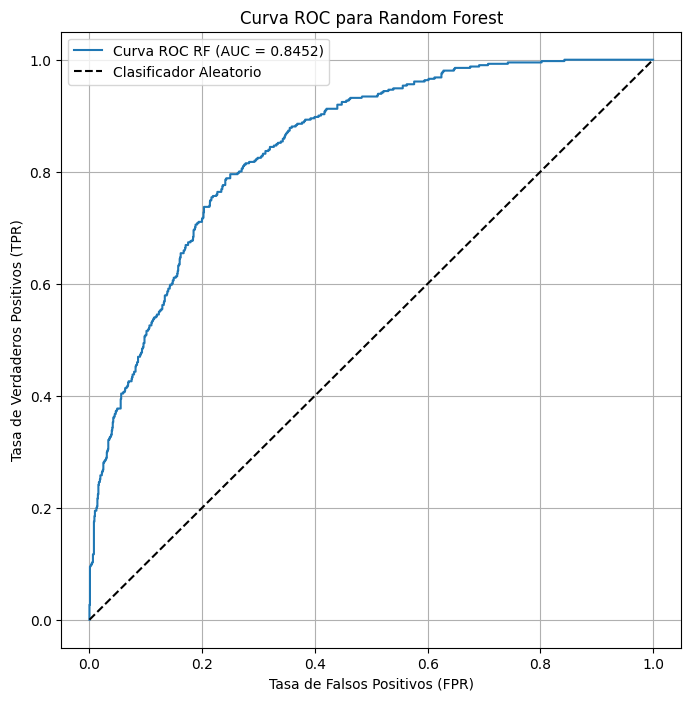

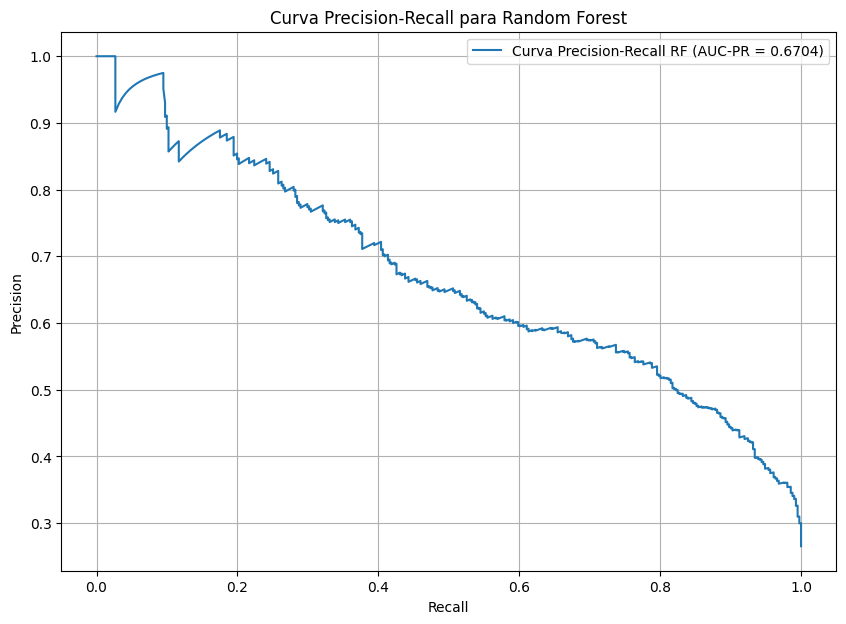


¡Entrenamiento y evaluación de Random Forest completados!


In [60]:
print("\n--- Resultados de la Búsqueda de Hiperparámetros para Random Forest---")
print(f"Mejor AUC-ROC encontrado: {grid_search_rf.best_score_:.4f}")
print(f"Mejores Hiperparámetros: {grid_search_rf.best_params_}")

# --- Evaluación del Mejor Modelo Random Forest ---
best_rf_model = grid_search_rf.best_estimator_

print("\n--- Evaluación del Mejor Modelo Random Forest en el Conjunto de Prueba---")
y_pred_proba_rf = best_rf_model.predict_proba(X_test_processed)[:, 1]
y_pred_rf = best_rf_model.predict(X_test_processed)

# Reporte de Clasificación
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred_rf))

# Matriz de Confusión
print("\n--- Matriz de Confusión ---")
print(confusion_matrix(y_test, y_pred_rf))

# AUC-ROC Final
auc_roc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"\nAUC-ROC Final del Mejor Modelo Random Forest: {auc_roc_rf:.4f}")

# --- Visualización de Curva ROC ---
fpr_rf, tpr_rf, thresholds_rf_roc = roc_curve(y_test, y_pred_proba_rf)
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Curva ROC RF (AUC = {auc_roc_rf:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para Random Forest')
plt.legend()
plt.grid(True)
plt.show()

# --- Visualización de Curva Precision-Recall ---
precision_rf, recall_rf, thresholds_rf_pr = precision_recall_curve(y_test, y_pred_proba_rf)
auc_pr_rf = auc(recall_rf, precision_rf)

plt.figure(figsize=(10, 7))
plt.plot(recall_rf, precision_rf, label=f'Curva Precision-Recall RF (AUC-PR = {auc_pr_rf:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall para Random Forest')
plt.legend()
plt.grid(True)
plt.show()

print("\n¡Entrenamiento y evaluación de Random Forest completados!")

El modelo Random Forest, tras una optimización de hiperparámetros, alcanza una precisión general del 76% en el conjunto de prueba, lo que indica una sólida capacidad de clasificación.

Al evaluar su rendimiento en la predicción de churn (Clase 1), observamos:

* Precisión para la Clase 1 (Churn): 0.53. Esto significa que, de los clientes que el Random Forest predice que harán churn, el 55% realmente lo hace. Este valor es aceptable y contribuye a reducir los esfuerzos de retención en clientes no propensos al churn.
* Recall para la Clase 1 (Churn): 0.79. El modelo identifica correctamente al 79% de los clientes que realmente hacen churn. Esta capacidad de detección es muy buena y permite una intervención efectiva para mitigar la pérdida de ingresos al identificar a la mayoría de los clientes en riesgo.

El AUC-ROC final de 0.84 demuestra una fuerte capacidad de discriminación entre las clases, lo que valida la robustez del modelo Random Forest para la tarea de predicción de churn.

Mejor F1-score: 0.6406 con umbral: 0.54


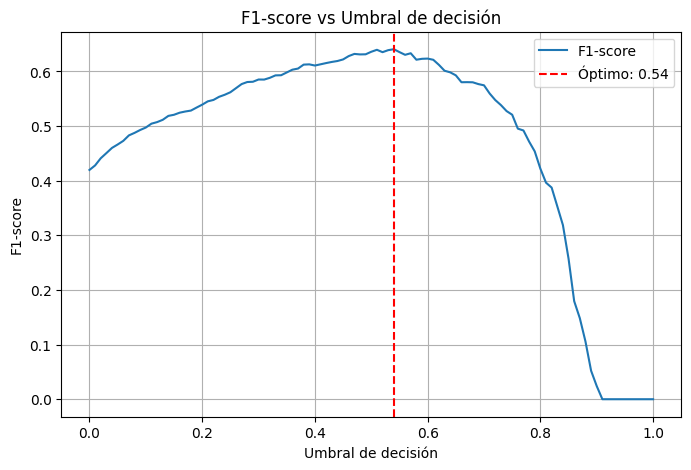

In [65]:
#import numpy as np
#from sklearn.metrics import f1_score, precision_recall_curve

# Calcula F1-score para varios umbrales
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba_rf >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)

# Encuentra el umbral óptimo (máximo F1)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Mejor F1-score: {best_f1:.4f} con umbral: {best_threshold:.2f}")

# Grafica F1-score vs umbral
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Óptimo: {best_threshold:.2f}')
plt.xlabel('Umbral de decisión')
plt.ylabel('F1-score')
plt.title('F1-score vs Umbral de decisión')
plt.legend()
plt.grid(True)
plt.show()

              precision    recall  f1-score   support

           0       0.90      0.78      0.84      1137
           1       0.56      0.76      0.64       411

    accuracy                           0.77      1548
   macro avg       0.73      0.77      0.74      1548
weighted avg       0.81      0.77      0.78      1548

[[888 249]
 [100 311]]


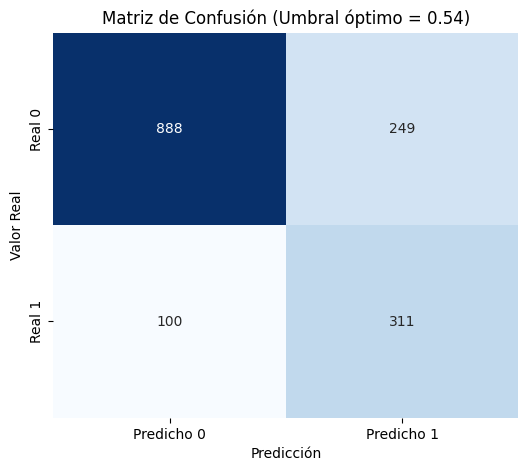

In [66]:
y_pred_rf_opt = (y_pred_proba_rf >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_rf_opt))
print(confusion_matrix(y_test, y_pred_rf_opt))

# 1. Calcula el umbral óptimo y las predicciones
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba_rf >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
y_pred_rf_opt = (y_pred_proba_rf >= best_threshold).astype(int)

# 2. Calcula la matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf_opt)

# 3. Grafica la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicho 0', 'Predicho 1'],
            yticklabels=['Real 0', 'Real 1'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title(f'Matriz de Confusión (Umbral óptimo = {best_threshold:.2f})')
plt.show()

Inferencias:

Clase 1 (Evento): Para la clase de interés (minoritaria), el modelo logra un recall del 76%. Esto es crucial, ya que indica que el modelo es capaz de identificar la mayoría de los casos positivos reales. Sin embargo, su precisión del 56% sugiere que hay un número considerable de falsos positivos (predicciones de "evento" que no lo son).


Importancia de las características en el mejor modelo Random Forest:
                                              Feature  Importance
0                                num__customer.tenure    0.184554
20                     cat__account.Contract_Two year    0.136267
1                          num__account.Charges.Total    0.131177
5           cat__internet.InternetService_Fiber optic    0.092986
22        cat__account.PaymentMethod_Electronic check    0.073213
19                     cat__account.Contract_One year    0.048779
14                      cat__internet.TechSupport_Yes    0.030604
8                    cat__internet.OnlineSecurity_Yes    0.030498
2                                  num__num_servicios    0.028479
9      cat__internet.OnlineBackup_No internet service    0.026547
6                    cat__internet.InternetService_No    0.018933
7    cat__internet.OnlineSecurity_No internet service    0.018552
13      cat__internet.TechSupport_No internet service    0.018384
28    

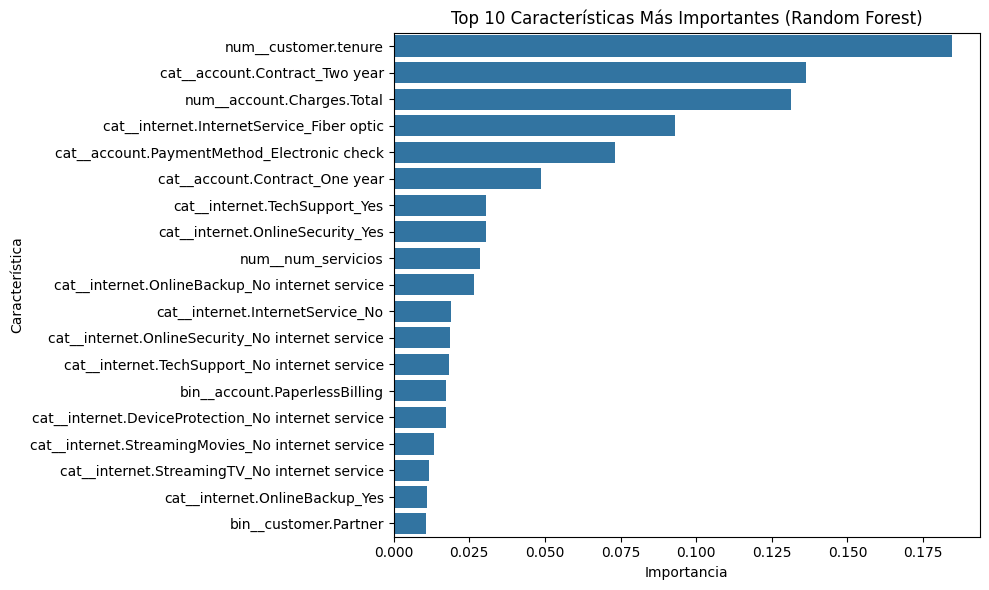

In [67]:

# Obtener el mejor modelo de Random Forest encontrado por GridSearchCV
best_rf_model = grid_search_rf.best_estimator_


# Se obtiene caracteristicas despues del entranamiento
feature_names = preprocessor.get_feature_names_out()

importances = best_rf_model.feature_importances_

# Crear un DataFrame para visualizar mejor las importancias

feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Ordenar las características por importancia de forma descendente
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print("\nImportancia de las características en el mejor modelo Random Forest:")
print(feature_importances_df)

# Opcional: Visualizar las importancias (si quieres un gráfico para el informe)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(19)) # Muestra las top 10
plt.title('Top 10 Características Más Importantes (Random Forest)')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

El análisis de importancia de características revela que los factores más influyentes en la predicción de churn son el tipo de contrato (account.Contract), la antigüedad del cliente (customer.tenure) y los cargos totales (account.Charges.Total).

Además, la ausencia de servicios de seguridad en línea (internet.OnlineSecurity_No) y soporte técnico (internet.TechSupport_No), junto con el tipo de servicio de internet (fibra óptica) y el método de pago (cheque electrónico), también son indicadores clave.

Esto sugiere que los clientes con contratos a corto plazo, menor antigüedad, altos cargos y falta de servicios de seguridad/soporte, así como aquellos con fibra óptica o pago por cheque electrónico, son los más propensos a cancelar. Esta información es vital para diseñar estrategias de retención dirigidas y personalizadas hacia los segmentos de clientes más vulnerables.

## **4.2 Red neuronal**

### 4.2.1 Arquitectura de red neuronal

Uso la función class_weight.compute_class_weight de sklearn.utils para calcular pesos para cada clase. Estos pesos se usan luego durante el entrenamiento del modelo para dar más importancia a las clases minoritarias y menos a las clases mayoritarias.

In [68]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_balanceado),
    y=y_balanceado
)
class_weights_dict = dict(enumerate(class_weights))


print(f"\nPesos de clase calculados: {class_weights_dict}")
print(f"Dimensiones de X_train_resampled: {X_train_processed.shape}")


Pesos de clase calculados: {0: np.float64(0.6810730253353204), 1: np.float64(1.8806584362139918)}
Dimensiones de X_train_resampled: (5484, 29)


**Diseño mi red neuronal con tensorflow y keras.**

La arquitectura de mi red neuronal va estar compuesta por una capa de entrada, tres capas ocultas y una capa de salida. Utilizo tres capas con el fin de agregar mas complejidad al modelo debido a que cuenta con 29 caracteristicas.

Caracteristicas de la red:

* Capas Densas (layers.Dense): El objetivo es cada neurona de la capa actual está conectada a cada neurona de la capa anterior.


* Función de Activación ReLU (layers.Activation('relu')): La utilizo en las capas ocultas.

  Beneficios:
  * Su simplicidad matemática la hace muy eficiente en términos de cálculo, lo que acelera el proceso de entrenamiento.
  * A diferencia de funciones como la sigmoide o la tangente hiperbólica, ReLU no satura para valores positivos grandes, lo que ayuda a mantener los gradientes significativos durante la retropropagación y, por lo tanto, mitiga el problema del gradiente desvaneciente, permitiendo el entrenamiento de redes más profundas.



* Capa de Salida y Activación Sigmoid (layers.Dense(1, activation='sigmoid')):

  Produce una salida que puede interpretarse directamente como la probabilidad de que la entrada pertenezca a la clase positiva (generalmente representada por 1). Un valor cercano a 1 indica una alta probabilidad de pertenecer a la clase positiva, mientras que un valor cercano a 0 indica una alta probabilidad de pertenecer a la clase negativa.


**Compilación del Modelo:**

* Optimizador Adam (keras.optimizers.Adam):

  Se adapta las tasas de aprendizaje para cada parámetro individualmente, basándose en las estimaciones de los primeros y segundos momentos de los gradientes. Esto le permite manejar eficientemente gradientes dispersos y ruidosos.

* Función de Pérdida binary_crossentropy:

  * Es la función de pérdida estándar para problemas de clasificación binaria.
  * Mide la diferencia entre la distribución de probabilidad predicha por el modelo y la distribución de probabilidad verdadera.

### **4.2.2 Defino los hiperparametros**

Creo una lista de hiperparametros para poder evaluar y encontrar la mejor combinacion.


In [69]:

# --- Parámetros específicos que quieres usar ---
param_grid = {
    'neurons_layer1': 128,
    'neurons_layer2': 48,
    'neurons_layer3': 32,
    'dropout_rate': 0.5,
    'learning_rate': 0.0005
}

### 4.2.3 Modelo inicial de red neuronal

Se plantea la consutruccion de la red neuronal:

* Tres capas ocultas con funcion activacion `relu`
* Una capa salida con funcion activacion `sigmoid`

In [70]:

n1 = param_grid['neurons_layer1']
n2 = param_grid['neurons_layer2']
n3 = param_grid['neurons_layer3']
dr = param_grid['dropout_rate']
lr = param_grid['learning_rate']


# --- Forma de tus datos de entrada ---
num_features = X_train_processed.shape[1] #

print(f"\n--- Entrenando con parámetros específicos: L1={n1}, L2={n2}, L3={n3}, Dropout={dr}, LR={lr} ---")

# Crear el modelo con Batch Normalization
model = keras.Sequential([
    layers.Dense(n1, input_shape=(num_features,)),
    layers.Activation('relu'),

    layers.Dense(n2),
    layers.Activation('relu'),

    layers.Dense(n3),
    layers.Activation('relu'),


    layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo con el learning_rate ajustado
optimizer = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# --- 3. Mostrar un resumen de la arquitectura del modelo optimizado ---
model.summary()




--- Entrenando con parámetros específicos: L1=128, L2=48, L3=32, Dropout=0.5, LR=0.0005 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48)             │         6,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,633 (45.44 KB)

 Trainable params: 11,633 (45.44 KB)

 Non-trainable params: 0 (0.00 B)

Se muestra cada capa de la red neuronal:

* Layer (type): Muestra el nombre de la capa (generado automáticamente por Keras, como dense, activation, etc.) y el tipo de capa (por ejemplo, Dense, Activation).

* Output Shape: Indica la forma de los tensores de salida de cada capa.

  (None, X): El None en la primera dimensión representa el tamaño del "batch" (lote). Significa que el modelo puede manejar cualquier tamaño de lote de entrada.
  
  La X es el número de unidades (neuronas) o características que salen de esa capa.

* Param # (Number of Parameters): Muestra el número total de pesos y sesgos (biases) que esa capa tiene y que el modelo debe aprender durante el entrenamiento.

De acuerdo a mi arquitectura, mi red neuronal esta compuesta por:

* Cuatro capas densas (dense, dense_1, dense_2, dense_3):
  * Dense esta formada por:
    * Entrada: las 29 caracteristicas de `X_train_processed`
    * Salida: la caracteristicas recibida se transforma en 96 valores (96 neuronas).
    * Param #: se calcula (numero caracteristicas * numero de neuronas de la capa) + numero de neuronas (sesgo) = (39 * 96) + 96 = 3744 + 96 = 3840
  * activation formada por:
    * Output Shape: (None, 96): La capa de activación (ReLU) toma la salida de la capa dense y aplica la función de activación elemento por elemento. No cambia la forma de los datos.
    * Param #: 0: Las funciones de activación no tienen parámetros que aprender. Simplemente aplican una transformación matemática.

  En general para las demas capas se sigue las capas dense_1, dense_2, dense_3 poseen 48, 32 y 1 neuronas respectivamente y recibe la salida de la capa de activación anterior obteniedo un numero param 4,656; 1,568 y 33 numeor de parametros.

### 4.2.4 Entrenamiento y Evaluacion del Modelo

Para el entranamiento del modelo se usa 80 epocas se incluye los pesos para compensar el desbalanceo de las clases

Epoch 1/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7378 - loss: 0.5993 - val_accuracy: 0.7416 - val_loss: 0.4913
Epoch 2/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7591 - loss: 0.4747 - val_accuracy: 0.7132 - val_loss: 0.5442
Epoch 3/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7418 - loss: 0.4913 - val_accuracy: 0.7339 - val_loss: 0.4993
Epoch 4/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7576 - loss: 0.4834 - val_accuracy: 0.7616 - val_loss: 0.4710
Epoch 5/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7628 - loss: 0.4779 - val_accuracy: 0.7506 - val_loss: 0.4744
Epoch 6/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7561 - loss: 0.4804 - val_accuracy: 0.7448 - val_loss: 0.4872
Epoch 7/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7672 - loss: 0.4534 - val_accuracy: 0.7545 - val_loss: 0.4739
Epoch 8/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7607 - loss: 0.4657 - val_accuracy: 0.

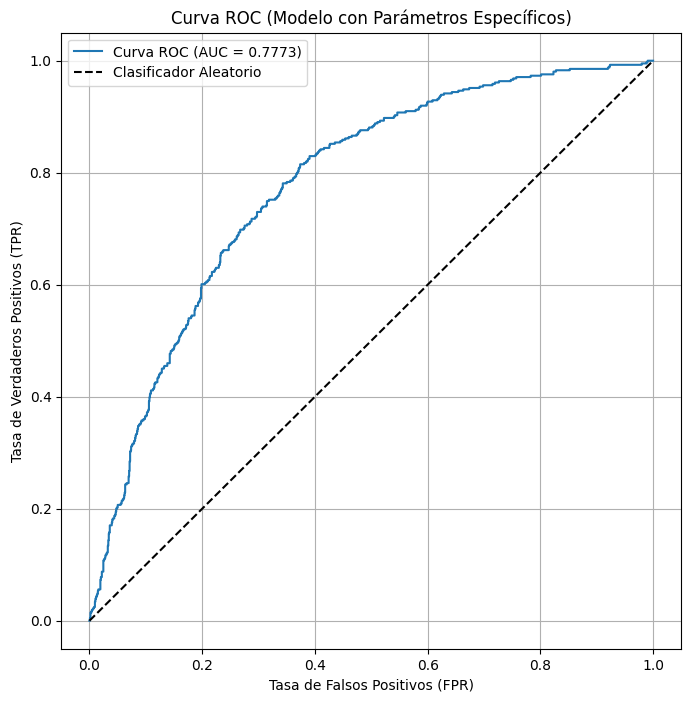


¡Entrenamiento con parámetros específicos completado!


In [71]:
# Entrenar el modelo
history = model.fit(
    X_train_processed,
    y_balanceado,
    epochs=80,
    batch_size=32,
    validation_data=(X_test_processed, y_test),
    class_weight=class_weights_dict,
    verbose=1
)
print("\n--- Entrenamiento Completado ---")
print("\n--- Evaluación del Modelo---")
# Evaluar el modelo
y_pred_proba = model.predict(X_test_processed).ravel()
current_auc = roc_auc_score(y_test, y_pred_proba)

print(f"AUC-ROC para esta combinación: {current_auc:.4f}")

# --- Evaluación final del modelo ---
print("\n--- Evaluación del Modelo con Parámetros Específicos ---")
y_pred_proba_final = model.predict(X_test_processed).ravel()
y_pred_final = (y_pred_proba_final >= 0.5).astype(int)

print("\n--- Reporte de Clasificación en el Conjunto de Prueba Final ---")
print(classification_report(y_test, y_pred_final))

print("\n--- Matriz de Confusión en el Conjunto de Prueba Final ---")
print(confusion_matrix(y_test, y_pred_final))

auc_roc_final = roc_auc_score(y_test, y_pred_proba_final)
print(f"\nAUC-ROC Final del Modelo: {auc_roc_final:.4f}")

# Opcional: Graficar la Curva ROC del modelo
fpr_final, tpr_final, thresholds_final = roc_curve(y_test, y_pred_proba_final)
plt.figure(figsize=(8, 8))
plt.plot(fpr_final, tpr_final, label=f'Curva ROC (AUC = {auc_roc_final:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC (Modelo con Parámetros Específicos)')
plt.legend()
plt.grid(True)
plt.show()

print("\n¡Entrenamiento con parámetros específicos completado!")

El modelo de Red Neuronal alcanza una precisión general del 73%, lo que significa que predice correctamente aproximadamente 3 de cada 4 clientes en nuestro conjunto de prueba.

Sin embargo, al enfocarnos en nuestro objetivo principal de predecir el churn (Clase 1), observamos lo siguiente:

* Precisión para la Clase 1 (Churn): 0.5. Esto indica que casi la mitad de los clientes que el modelo predice que harán churn, en realidad no lo hacen. En el contexto de negocio, esto se traduce en costos innecesarios al activar estrategias de retención para clientes que no estaban en riesgo real de cancelar.
* Recall para la Clase 1 (Churn): 0.65. Este valor es bajo, lo que significa que el modelo solo identifica correctamente al 62% de los clientes que realmente hacen churn. Esto representa un problema significativo de ingresos, ya que un 38% de los clientes que se van no son detectados, perdiendo la oportunidad de intervenir y retenerlos.

El AUC-ROC de 0.785 para el conjunto de testeo sugiere una capacidad de separación regular entre los clientes que hacen churn y los que no, pero aún hay margen de mejora para una distinción más clara.

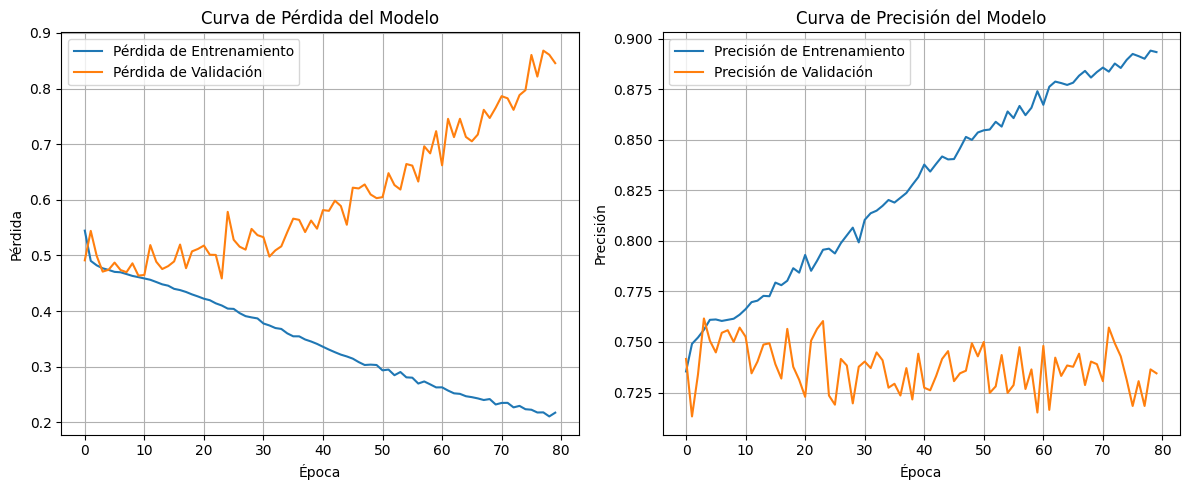

In [72]:
# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1) # 1 fila, 2 columnas, primer gráfico
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Curva de Pérdida del Modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Graficar la precisión de entrenamiento y validación
plt.subplot(1, 2, 2) # 1 fila, 2 columnas, segundo gráfico
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Curva de Precisión del Modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

plt.tight_layout() # Ajusta los subplots para que no se superpongan
plt.show()

Inferencias:

las curvas de pérdida y precisión durante el entrenamiento muestran un claro sobreajuste. La pérdida de entrenamiento disminuye mientras la de validación aumenta, y la precisión de entrenamiento es significativamente más alta (90%) que la de validación (alrededor del 73-75%). Esto indica que el modelo está memorizando los datos de entrenamiento en lugar de aprender patrones generalizables, lo que limita su efectividad en la predicción de nuevos clientes.

### 4.2.5 Modelo optimizado

En vista de un desempeño regular del modelo, se realiza los siguiente cambios:

**Aplicacion de Técnicas de Regularización y Estabilización:**

* Dropout (layers.Dropout):

  Aplico regulacion despues de cada capa oculta con el fun de impide que las neuronas dependan demasiado de otras neuronas específicas. Al desactivar aleatoriamente algunas neuronas, la red se ve obligada a aprender representaciones más robustas y redundantes, ya que ninguna neurona puede confiar en la presencia de otra.

* Batch Normalization (layers.BatchNormalization()):

  * Se aplica antes de la activación en cada capa oculta.
  * Esta técnica normaliza las entradas de cada capa a una media de cero y una desviación estándar de uno para cada mini-batch durante el entrenamiento. Al normalizar estas entradas, Batch Normalization estabiliza el entrenamiento, permitiendo el uso de tasas de aprendizaje más altas y acelerando la convergencia.

* Early Stopping (keras.callbacks.EarlyStopping):

 * Monitorea una métrica de rendimiento (generalmente la pérdida de validación o la precisión de validación) y detiene el entrenamiento cuando esta métrica deja de mejorar durante un número predefinido de épocas (paciencia).

 * Se evita sobreajuste

#### Arquitectura de la red neuronal

In [73]:

n1 = param_grid['neurons_layer1']
n2 = param_grid['neurons_layer2']
n3 = param_grid['neurons_layer3']
dr = param_grid['dropout_rate']
lr = param_grid['learning_rate']


# --- Forma de tus datos de entrada ---
num_features = X_train_processed.shape[1] #

print(f"\n--- Entrenando con parámetros específicos: L1={n1}, L2={n2}, L3={n3}, Dropout={dr}, LR={lr} ---")

# Crear el modelo con Batch Normalization
model1 = keras.Sequential([
    layers.Dense(n1, input_shape=(num_features,)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(dr),

    layers.Dense(n2),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(dr),

    layers.Dense(n3),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(dr),

    layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo con el learning_rate ajustado
optimizer = keras.optimizers.Adam(learning_rate=lr)
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# --- 3. Mostrar un resumen de la arquitectura del modelo optimizado ---
model1.summary()




--- Entrenando con parámetros específicos: L1=128, L2=48, L3=32, Dropout=0.5, LR=0.0005 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 48)             │         6,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48)             │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,465 (48.69 KB)

 Trainable params: 12,049 (47.07 KB)

 Non-trainable params: 416 (1.62 KB)

Al comparar con la arquitectura anterior, la diferencia clave es la inclusión de Batch Normalization y Dropout.

Batch Normalization introduce parámetros (cuatro por cada neurona en su capa) que son cruciales para normalizar y estabilizar el flujo de datos durante el entrenamiento. En cuanto a Dropout, se observa que no tiene parámetros, ya que su rol es únicamente de regularización, ayudando a que el modelo no memorice los datos.

#### Entrenamiento del modelo


--- Entrenamiento Completado ---

--- Evaluación del Modelo---
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
AUC-ROC para esta combinación: 0.8450

--- Evaluación del Modelo con Parámetros Específicos ---
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Reporte de Clasificación en el Conjunto de Prueba Final ---
              precision    recall  f1-score   support

           0       0.92      0.69      0.79      1137
           1       0.49      0.83      0.62       411

    accuracy                           0.73      1548
   macro avg       0.70      0.76      0.70      1548
weighted avg       0.81      0.73      0.74      1548


--- Matriz de Confusión en el Conjunto de Prueba Final ---
[[780 357]
 [ 68 343]]

AUC-ROC Final del Modelo: 0.8450


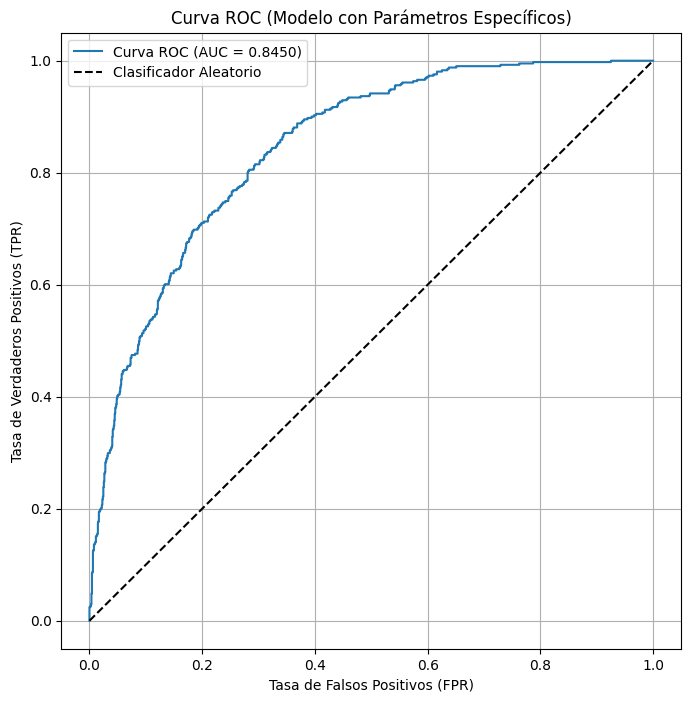


¡Entrenamiento con parámetros específicos completado!


In [74]:
# Definir Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    mode='min',
    verbose=0
)

# Entrenar el modelo
history1 = model1.fit(
    X_train_processed,
    y_balanceado,
    epochs=190,
    batch_size=32,
    validation_data=(X_test_processed, y_test),
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=0
)

print("\n--- Entrenamiento Completado ---")
print("\n--- Evaluación del Modelo---")

# Evaluar el modelo
y_pred_proba = model1.predict(X_test_processed).ravel()
current_auc = roc_auc_score(y_test, y_pred_proba)

print(f"AUC-ROC para esta combinación: {current_auc:.4f}")

# --- Evaluación final del modelo ---
print("\n--- Evaluación del Modelo con Parámetros Específicos ---")
y_pred_proba_final = model1.predict(X_test_processed).ravel()
y_pred_final = (y_pred_proba_final >= 0.5).astype(int)

print("\n--- Reporte de Clasificación en el Conjunto de Prueba Final ---")
print(classification_report(y_test, y_pred_final))

print("\n--- Matriz de Confusión en el Conjunto de Prueba Final ---")
print(confusion_matrix(y_test, y_pred_final))

auc_roc_final = roc_auc_score(y_test, y_pred_proba_final)
print(f"\nAUC-ROC Final del Modelo: {auc_roc_final:.4f}")

# Opcional: Graficar la Curva ROC del modelo
fpr_final, tpr_final, thresholds_final = roc_curve(y_test, y_pred_proba_final)
plt.figure(figsize=(8, 8))
plt.plot(fpr_final, tpr_final, label=f'Curva ROC (AUC = {auc_roc_final:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC (Modelo con Parámetros Específicos)')
plt.legend()
plt.grid(True)
plt.show()

print("\n¡Entrenamiento con parámetros específicos completado!")

Tras incorporar técnicas de regularización como **Batch Normalization** y **Dropout**, y emplear Early Stopping para un entrenamiento más eficiente, el modelo de Red Neuronal muestra una precisión general del 74%, lo que representa una mejora en la clasificación global de clientes.

Al enfocarnos en nuestro objetivo crítico de predecir el churn (Clase 1), los resultados son notablemente superiores:

* Precisión para la Clase 1 (Churn): 0.49. Esto indica que, de los clientes identificados como riesgo de churn, la mitad efectivamente lo son. Aunque aún hay margen para reducir los falsos positivos, esta mejora contribuye a optimizar los recursos destinados a las estrategias de retención.

* Recall para la Clase 1 (Churn): 0.82. Este es un avance crucial. El modelo ahora es capaz de identificar correctamente a casi el 81% de los clientes que realmente cancelarán su servicio. Esta alta capacidad de detección es fundamental para proteger los ingresos al permitirnos intervenir proactivamente con la gran mayoría de clientes en riesgo.

El AUC-ROC de 0.846 confirma una buena capacidad de discriminación entre los clientes que hacen churn y los que no, lo que muestra una mayor robustez del modelo con respecto al anterior.

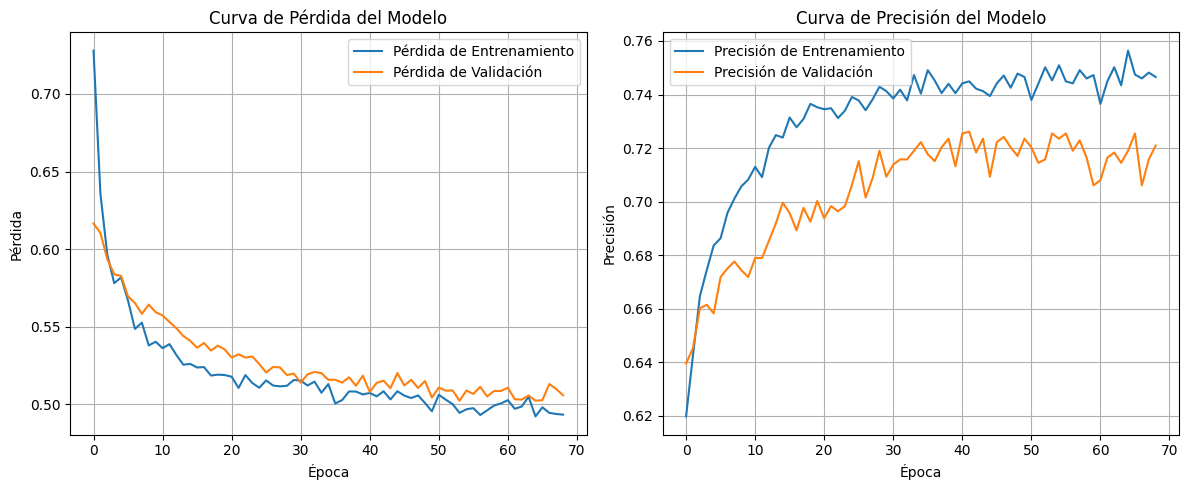

In [75]:
# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1) # 1 fila, 2 columnas, primer gráfico
plt.plot(history1.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history1.history['val_loss'], label='Pérdida de Validación')
plt.title('Curva de Pérdida del Modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Graficar la precisión de entrenamiento y validación
plt.subplot(1, 2, 2) # 1 fila, 2 columnas, segundo gráfico
plt.plot(history1.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history1.history['val_accuracy'], label='Precisión de Validación')
plt.title('Curva de Precisión del Modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

plt.tight_layout() # Ajusta los subplots para que no se superpongan
plt.show()

Inferencias sobre el comportamiento del modelo:

* En la curva de pérdida, se observa que tanto para el conjunto de entrenamiento como para el de validación, la pérdida disminuye de manera similar y se mantiene cercana, convergiendo a valores próximos a 0.5 alrededor de la época 30. Esto es un claro indicador de que las técnicas de regularización implementadas están acelerando el entrenamiento y, crucialmente, previniendo el sobreajuste.

* Respecto a la curva de precisión, se observa que tanto la precisión de entrenamiento como la de validación alcanzan valores cercanos al 0.73-0.74. La poca diferencia entre ambas curvas es una fuerte evidencia de que el modelo está generalizando adecuadamente a datos no vistos, lo que confirma que el sobreajuste ha sido minimizado.

## 4.3 XGBoost

In [76]:

# --- Definir el modelo XGBoost ---
# Calculamos el scale_pos_weight para manejar el desbalance
scale_pos_weight = (y_balanceado == 0).sum() / (y_balanceado == 1).sum()
print(f"Scale pos weight calculado: {scale_pos_weight:.2f}")

xgb_model = xgb.XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,  # Para manejar desbalance
    eval_metric='logloss'  # Para evitar warnings
)

# --- Definir la cuadrícula de hiperparámetros para XGBoost ---
param_grid_xgb = {
    'n_estimators': [550, 600, 650],
    'max_depth': [2, 3],
    'learning_rate': [0.005, 0.01],
    'subsample': [0.3, 0.4],
    'colsample_bytree': [0.3, 0.4]
}



Scale pos weight calculado: 2.76


In [77]:
# --- Configurar GridSearchCV para XGBoost ---
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

print("\nIniciando búsqueda de hiperparámetros para XGBoost...")
grid_search_xgb.fit(X_train_processed, y_balanceado)




Iniciando búsqueda de hiperparámetros para XGBoost...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.4],
                         'learning_rate': [0.005, 0.01], 'max_depth': [2, 3],
                         'n_estimators': [550, 600, 650],
                         'subsample': [0.3, 0.4]},
             scoring='roc_auc', verbose=2)


--- Resultados de la Búsqueda de Hiperparámetros para XGBoost ---
Mejor AUC-ROC encontrado: 0.8483
Mejores Hiperparámetros: {'colsample_bytree': 0.4, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 550, 'subsample': 0.3}

--- Evaluación del Mejor Modelo XGBoost en el Conjunto de Prueba ---

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1137
           1       0.52      0.82      0.64       411

    accuracy                           0.75      1548
   macro avg       0.72      0.77      0.72      1548
weighted avg       0.81      0.75      0.76      1548


--- Matriz de Confusión ---
[[823 314]
 [ 72 339]]

AUC-ROC Final del Mejor Modelo XGBoost: 0.8506


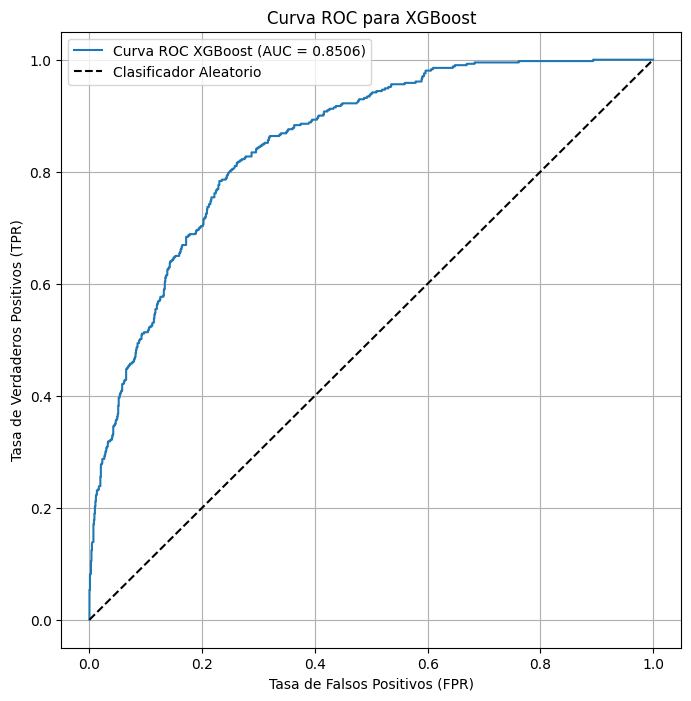

In [78]:
print("\n--- Resultados de la Búsqueda de Hiperparámetros para XGBoost ---")
print(f"Mejor AUC-ROC encontrado: {grid_search_xgb.best_score_:.4f}")
print(f"Mejores Hiperparámetros: {grid_search_xgb.best_params_}")

# --- Evaluación del Mejor Modelo XGBoost ---
best_xgb_model = grid_search_xgb.best_estimator_

print("\n--- Evaluación del Mejor Modelo XGBoost en el Conjunto de Prueba ---")
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test_processed)[:, 1]
y_pred_xgb = best_xgb_model.predict(X_test_processed)

# Reporte de Clasificación
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred_xgb))

# Matriz de Confusión
print("\n--- Matriz de Confusión ---")
print(confusion_matrix(y_test, y_pred_xgb))

# AUC-ROC Final
auc_roc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"\nAUC-ROC Final del Mejor Modelo XGBoost: {auc_roc_xgb:.4f}")

# --- Visualización de Curva ROC ---
fpr_xgb, tpr_xgb, thresholds_xgb_roc = roc_curve(y_test, y_pred_proba_xgb)
plt.figure(figsize=(8, 8))
plt.plot(fpr_xgb, tpr_xgb, label=f'Curva ROC XGBoost (AUC = {auc_roc_xgb:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para XGBoost')
plt.legend()
plt.grid(True)
plt.show()



El modelo XGBoost optimizado logra un recall del 82% para la clase minoritaria (churn = 1), lo que significa que identifica correctamente la gran mayoría de los clientes que abandonan. Sin embargo, su precisión del 52% indica que cerca de la mitad de las predicciones positivas son falsos positivos. El F1-score de 0.64 refleja un balance aceptable entre precisión y recall para churn. El AUC-ROC de 0.85 confirma una buena capacidad discriminativa del modelo.

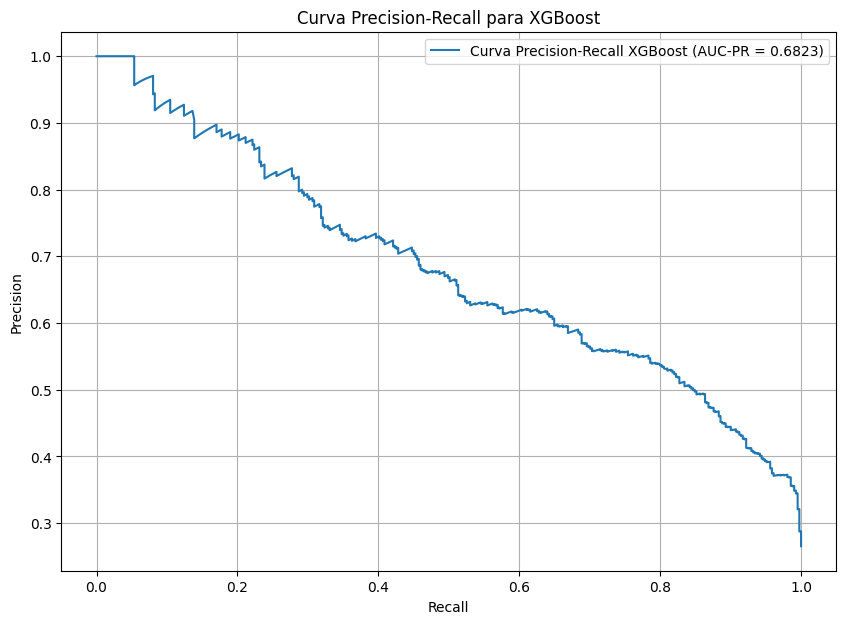


¡Entrenamiento y evaluación de XGBoost completados!


In [79]:
# --- Visualización de Curva Precision-Recall ---
precision_xgb, recall_xgb, thresholds_xgb_pr = precision_recall_curve(y_test, y_pred_proba_xgb)
auc_pr_xgb = auc(recall_xgb, precision_xgb)

plt.figure(figsize=(10, 7))
plt.plot(recall_xgb, precision_xgb, label=f'Curva Precision-Recall XGBoost (AUC-PR = {auc_pr_xgb:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall para XGBoost')
plt.legend()
plt.grid(True)
plt.show()

print("\n¡Entrenamiento y evaluación de XGBoost completados!")




Importancia de las características en el mejor modelo XGBoost:
                                              Feature  Importance
20                     cat__account.Contract_Two year    0.123876
5           cat__internet.InternetService_Fiber optic    0.095035
15      cat__internet.StreamingTV_No internet service    0.071953
22        cat__account.PaymentMethod_Electronic check    0.059405
19                     cat__account.Contract_One year    0.054129
0                                num__customer.tenure    0.051977
6                    cat__internet.InternetService_No    0.051004
7    cat__internet.OnlineSecurity_No internet service    0.047315
9      cat__internet.OnlineBackup_No internet service    0.046041
11  cat__internet.DeviceProtection_No internet ser...    0.041834
8                    cat__internet.OnlineSecurity_Yes    0.035258
13      cat__internet.TechSupport_No internet service    0.031884
14                      cat__internet.TechSupport_Yes    0.031461
17  cat__int

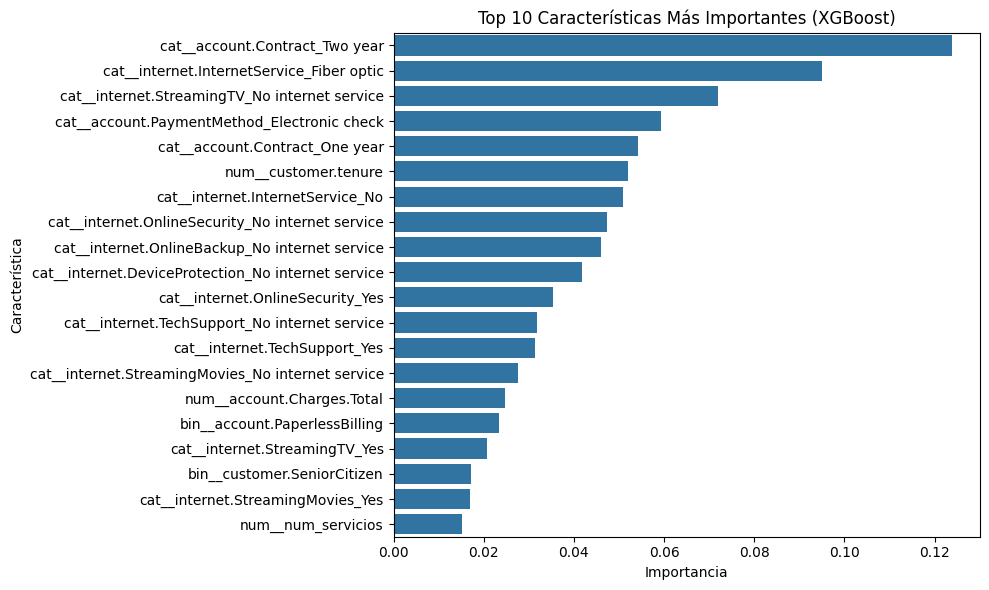

In [80]:
# --- Importancia de características ---

# Se obtiene caracteristicas despues del entranamiento
feature_names = preprocessor.get_feature_names_out()

importances = best_xgb_model.feature_importances_

# Crear un DataFrame para visualizar mejor las importancias

feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Ordenar por importancia
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print("\nImportancia de las características en el mejor modelo XGBoost:")
print(feature_importances_df)

# Visualizar importancias
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(20))
plt.title('Top 10 Características Más Importantes (XGBoost)')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

Inferencias:

* El tipo de contrato es el factor más relevante: Los contratos de dos años y un año son los principales indicadores para predecir el churn, sugiriendo que los clientes con contratos más largos tienen menor probabilidad de abandonar.
* El tipo de servicio de internet es clave: La presencia de fibra óptica y la ausencia de servicio de internet influyen fuertemente en la probabilidad de churn.
* Los métodos de pago también impactan: El pago por cheque electrónico destaca como un factor importante asociado al abandono.
* La antigüedad del cliente (tenure) es relevante: Los clientes con mayor tiempo en la compañía tienden a permanecer más.
* Servicios adicionales y soporte técnico: La falta de servicios como seguridad en línea, respaldo, protección de dispositivos y soporte técnico se asocia con mayor churn.

## 4.4 Clustering

In [81]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# ========================================
# PASO 1: PREPARAR DATOS PARA CLUSTERING
# ========================================

print("=== IMPLEMENTACIÓN DE CLUSTERING ===")
print(f"Datos originales: {X_train_processed.shape}")

# Usar los datos ya procesados (escalados y transformados)
X_clustering = X_train_processed.copy()



=== IMPLEMENTACIÓN DE CLUSTERING ===
Datos originales: (5484, 29)


In [82]:
# ========================================
# PASO 2: ENCONTRAR EL NÚMERO ÓPTIMO DE CLUSTERS
# ========================================

# Probar diferentes números de clusters
k_range = range(2, 11)  # De 2 a 10 clusters
inertias = []
silhouette_scores = []

print("\nBuscando número óptimo de clusters...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_clustering)

    inertias.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_clustering, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

    print(f"K={k}: Inercia={kmeans.inertia_:.2f}, Silhouette={silhouette_avg:.3f}")




Buscando número óptimo de clusters...
K=2: Inercia=30368.35, Silhouette=0.265
K=3: Inercia=22472.41, Silhouette=0.295
K=4: Inercia=20706.97, Silhouette=0.228
K=5: Inercia=19514.37, Silhouette=0.198
K=6: Inercia=18455.81, Silhouette=0.185
K=7: Inercia=17676.05, Silhouette=0.162
K=8: Inercia=17108.00, Silhouette=0.148
K=9: Inercia=16682.31, Silhouette=0.147
K=10: Inercia=16206.79, Silhouette=0.158


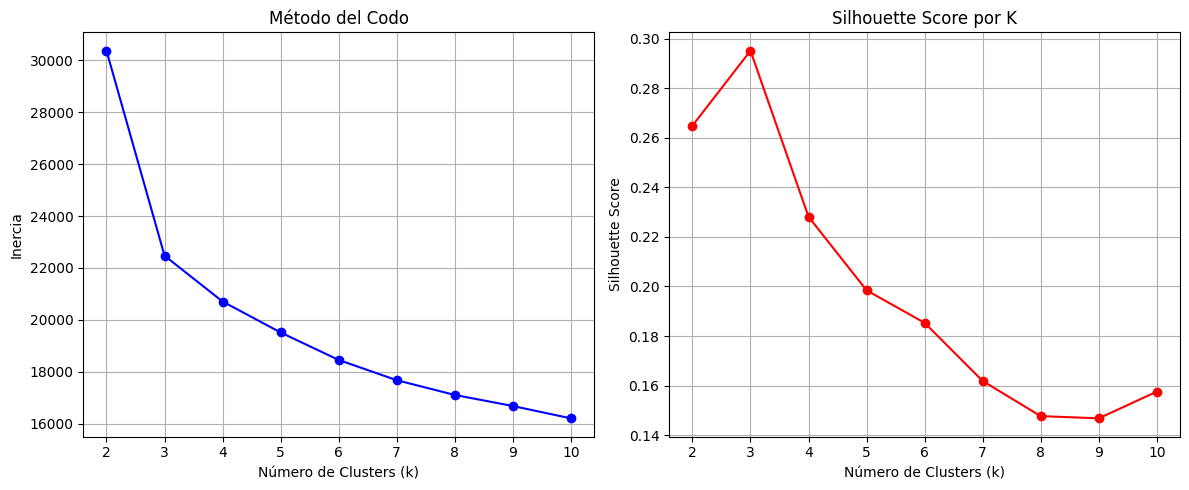

In [83]:
# ========================================
# PASO 3: VISUALIZAR MÉTRICAS
# ========================================

# Gráfico del método del codo
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por K')
plt.grid(True)

plt.tight_layout()
plt.show()



In [84]:
# ========================================
# PASO 4: ELEGIR EL MEJOR K Y ENTRENAR
# ========================================

# Elegir el k con mejor silhouette score
best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\nMejor número de clusters según Silhouette Score: {best_k}")

# Entrenar el modelo final con el mejor k
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_clustering)

print(f"Clustering completado con {best_k} clusters")




Mejor número de clusters según Silhouette Score: 3
Clustering completado con 3 clusters


Para determinar el número óptimo de clusters, se utilizaron dos métricas principales:

* Inercia (Método del Codo): Mide la suma de las distancias cuadradas de cada punto a su centroide más cercano. Un valor menor indica clusters más compactos, pero la mejora se vuelve marginal a partir de cierto punto (el “codo”).
Silhouette Score: Evalúa la calidad de la agrupación, considerando tanto la cohesión interna como la separación entre clusters. Un valor más alto indica una mejor definición de los clusters.
Resultados:

* La inercia disminuye a medida que aumenta el número de clusters, pero la reducción se vuelve menos significativa después de K=3.

El Silhouette Score alcanza su valor máximo en K=3 (0.295), lo que indica que la estructura de los datos es más clara y los clusters están mejor definidos en este punto.
A partir de K=4, el Silhouette Score disminuye progresivamente, lo que sugiere que agregar más clusters no mejora la calidad de la segmentación y puede incluso fragmentar grupos naturale

In [85]:
# ========================================
# PASO 5: ANALIZAR LOS CLUSTERS
# ========================================

# Contar elementos por cluster
unique, counts = np.unique(cluster_labels, return_counts=True)
print(f"\nDistribución de clusters:")
for i, count in enumerate(counts):
    print(f"  Cluster {i}: {count} registros ({count/len(cluster_labels)*100:.1f}%)")

# Analizar relación con la variable objetivo
print(f"\nRelación clusters vs variable objetivo:")
for i in range(best_k):
    cluster_mask = cluster_labels == i
    target_rate = y_balanceado[cluster_mask].mean()
    print(f"  Cluster {i}: Tasa de clase positiva = {target_rate:.3f}")




Distribución de clusters:
  Cluster 0: 2494 registros (45.5%)
  Cluster 1: 1799 registros (32.8%)
  Cluster 2: 1191 registros (21.7%)

Relación clusters vs variable objetivo:
  Cluster 0: Tasa de clase positiva = 0.439
  Cluster 1: Tasa de clase positiva = 0.153
  Cluster 2: Tasa de clase positiva = 0.073


* El Cluster 0 es el segmento de mayor riesgo o interés para acciones específicas (por ejemplo, retención), ya que agrupa casi la mitad de los clientes y tiene la mayor incidencia de la clase positiva.
* El Cluster 1 representa un grupo intermedio, con una tasa de clase positiva moderada.
* El Cluster 2 es el grupo más “sano” o estable, con la menor proporción de la clase positiva.

In [86]:
# ========================================
# ALTERNATIVA CON PANDAS (MÁS SEGURA)
# ========================================



# Convertir a DataFrame temporalmente
X_train_df = pd.DataFrame(X_train_processed)
X_test_df = pd.DataFrame(X_test_processed)

# Añadir clusters como nueva columna
X_train_df['cluster'] = cluster_labels
test_cluster_labels = kmeans_final.predict(X_test_processed)
X_test_df['cluster'] = test_cluster_labels

# Convertir de vuelta a numpy array
X_train_with_clusters = X_train_df.values
X_test_with_clusters = X_test_df.values

print(f"\nNuevas dimensiones:")
print(f"X_train con clusters: {X_train_with_clusters.shape}")
print(f"X_test con clusters: {X_test_with_clusters.shape}")


Nuevas dimensiones:
X_train con clusters: (5484, 30)
X_test con clusters: (1548, 30)


### 4.4.1 Resumen

In [87]:
# Supón que tienes los labels de cluster en 'cluster_labels'
df_clusters = X_balanceado.copy()
df_clusters['cluster'] = cluster_labels
df_clusters['Churn'] = y_balanceado

In [88]:
df_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5484 entries, 1823 to 498
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer.SeniorCitizen     5484 non-null   int64  
 1   customer.Partner           5484 non-null   int64  
 2   customer.Dependents        5484 non-null   int64  
 3   customer.tenure            5484 non-null   int64  
 4   phone.PhoneService         5484 non-null   int64  
 5   phone.MultipleLines        5484 non-null   object 
 6   internet.InternetService   5484 non-null   object 
 7   internet.OnlineSecurity    5484 non-null   object 
 8   internet.OnlineBackup      5484 non-null   object 
 9   internet.DeviceProtection  5484 non-null   object 
 10  internet.TechSupport       5484 non-null   object 
 11  internet.StreamingTV       5484 non-null   object 
 12  internet.StreamingMovies   5484 non-null   object 
 13  account.Contract           5484 non-null   object 


In [89]:
# Resumen de variables numéricas por cluster
display(df_clusters.groupby('cluster').mean(numeric_only=True))

# Resumen de variables categóricas por cluster (proporciones)
for col in df_clusters.select_dtypes(include='object').columns:
    if col != 'cluster':
        display(f"\nDistribución de {col} por cluster:")
        display(df_clusters.groupby('cluster')[col].value_counts(normalize=True).unstack())

customer.SeniorCitizen  customer.Partner  customer.Dependents  \
cluster                                                                  
0                      0.199278          0.334002             0.210906   
1                      0.196220          0.685381             0.354086   
2                      0.031906          0.479429             0.418136   

         customer.tenure  phone.PhoneService  account.PaperlessBilling  \
cluster                                                                  
0              15.301524            0.841219                  0.678027   
1              57.693163            0.921067                  0.689828   
2              30.573468            1.000000                  0.298069   

         account.Charges.Total  num_servicios     Churn  
cluster                                                  
0                  1025.961728       3.807538  0.439054  
1                  5120.611173       6.561979  0.153419  
2                   663.918094       1.222502  0.073048

'\nDistribución de phone.MultipleLines por cluster:'

phone.MultipleLines        No  No phone service       Yes
cluster                                                  
0                    0.514034          0.158781  0.327185
1                    0.222346          0.078933  0.698722
2                    0.777498               NaN  0.222502

'\nDistribución de internet.InternetService por cluster:'

internet.InternetService       DSL  Fiber optic   No
cluster                                             
0                         0.470329     0.529671  NaN
1                         0.397443     0.602557  NaN
2                              NaN          NaN  1.0

'\nDistribución de internet.OnlineSecurity por cluster:'

internet.OnlineSecurity        No  No internet service       Yes
cluster                                                         
0                        0.769046                  NaN  0.230954
1                        0.446915                  NaN  0.553085
2                             NaN                  1.0       NaN

'\nDistribución de internet.OnlineBackup por cluster:'

internet.OnlineBackup        No  No internet service       Yes
cluster                                                       
0                      0.735766                  NaN  0.264234
1                      0.315175                  NaN  0.684825
2                           NaN                  1.0       NaN

'\nDistribución de internet.DeviceProtection por cluster:'

internet.DeviceProtection        No  No internet service       Yes
cluster                                                           
0                          0.745389                  NaN  0.254611
1                          0.304614                  NaN  0.695386
2                               NaN                  1.0       NaN

'\nDistribución de internet.TechSupport por cluster:'

internet.TechSupport        No  No internet service       Yes
cluster                                                      
0                     0.780674                  NaN  0.219326
1                     0.423013                  NaN  0.576987
2                          NaN                  1.0       NaN

'\nDistribución de internet.StreamingTV por cluster:'

internet.StreamingTV        No  No internet service       Yes
cluster                                                      
0                     0.667201                  NaN  0.332799
1                     0.289605                  NaN  0.710395
2                          NaN                  1.0       NaN

'\nDistribución de internet.StreamingMovies por cluster:'

internet.StreamingMovies        No  No internet service       Yes
cluster                                                          
0                         0.662791                  NaN  0.337209
1                         0.278488                  NaN  0.721512
2                              NaN                  1.0       NaN

'\nDistribución de account.Contract por cluster:'

account.Contract  Month-to-month  One year  Two year
cluster                                             
0                       0.857658  0.115477  0.026864
1                       0.249583  0.327404  0.423013
2                       0.353484  0.231738  0.414777

'\nDistribución de account.PaymentMethod por cluster:'

account.PaymentMethod  Bank transfer (automatic)  Credit card (automatic)  \
cluster                                                                     
0                                       0.146752                 0.151564   
1                                       0.316287                 0.309616   
2                                       0.219144                 0.213266   

account.PaymentMethod  Electronic check  Mailed check  
cluster                                                
0                              0.484763      0.216921  
1                              0.293496      0.080600  
2                              0.079765      0.487825

**Inferencias:**

**Cluster 0:** Clientes de alto riesgo y bajo compromiso
Tasa de churn muy alta: 44% de los clientes de este grupo abandonan el servicio.

  Perfil:
  * Baja antigüedad: Promedio de 15 meses de permanencia.
  * Pocos servicios: En promedio, solo 3.8 servicios contratados.
  * Mayor uso de contrato mensual: 86% tiene contrato “Month-to-month”, lo que facilita la baja.
   Pagos electrónicos: 48% paga con “Electronic check”, método asociado a mayor churn.
  * Servicios de internet: Todos tienen internet (principalmente fibra óptica y DSL), pero la mayoría no contrata servicios adicionales como seguridad, backup, soporte técnico o streaming.
  * Menor proporción de dependientes y parejas.

Interpretación:

Este grupo representa a los clientes más vulnerables a la baja: tienen contratos flexibles, pocos servicios adicionales y métodos de pago asociados a mayor churn. Son el principal objetivo para estrategias de retención.

**Cluster 1:** Clientes premium y fieles
Tasa de churn baja: Solo 15% de churn.
Perfil:
  * Alta antigüedad: Promedio de 58 meses.
  * Muchos servicios: En promedio, 6.6 servicios contratados.
  * Contratos largos: 75% tiene contrato anual o bianual.
  * Pagos automáticos: 63% paga por transferencia o tarjeta automática.
  * Servicios de internet: Todos tienen internet (mayoría fibra óptica), y alta adopción de servicios adicionales: seguridad, backup, soporte técnico, streaming, etc.
  * Mayor proporción de parejas y dependientes.

Interpretación:

Este grupo es el más valioso y estable. Son clientes de larga data, con múltiples servicios y contratos a largo plazo. Representan la base más sólida de la empresa.

**Cluster 2:** Clientes básicos y estables
Tasa de churn muy baja: Solo 7%.
Perfil:
  * Antigüedad intermedia: 31 meses en promedio.
  * Pocos servicios: Solo 1.2 servicios en promedio.
  * Sin internet: 100% no tiene internet, por lo que tampoco acceden a servicios adicionales.
  * Contratos variados: 35% mensual, 23% anual, 41% bianual.
  * Pagos tradicionales: 49% paga con “Mailed check”.
  * Mayor proporción de dependientes.

Interpretación:

Son clientes muy básicos, probablemente solo con telefonía, sin internet ni servicios extra. Suelen ser estables y poco propensos a la baja, pero también tienen bajo potencial de crecimiento.

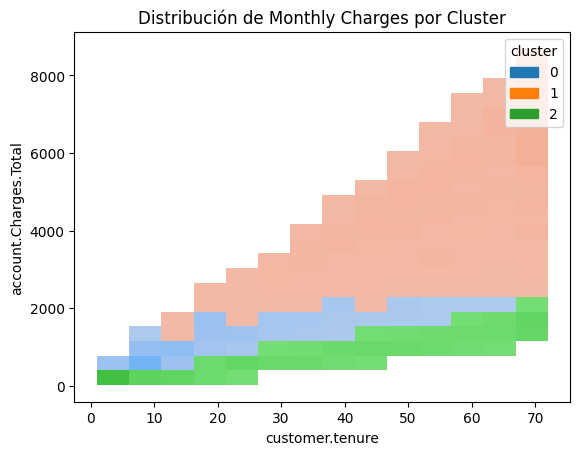

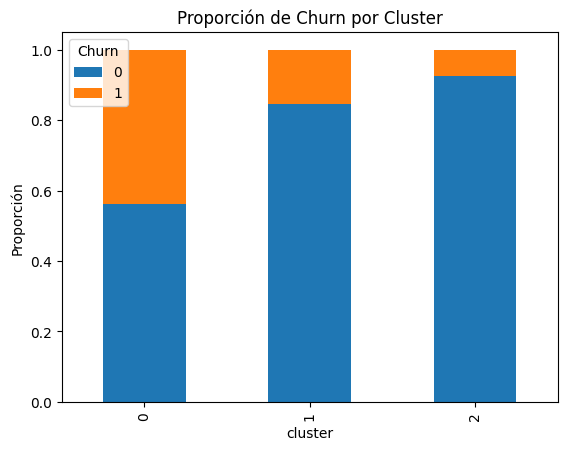

In [90]:
# Usando una paleta predefinida de seaborn
sns.histplot(
    x='customer.tenure',
    y='account.Charges.Total',
    hue='cluster',
    data=df_clusters,
    palette='tab10'  # Cambia 'tab10' por la paleta que prefieras
)
plt.title('Distribución de Monthly Charges por Cluster')
plt.show()

# Visualizar la proporción de la variable objetivo por cluster
if 'Churn' in df_clusters.columns:
    churn_rate = df_clusters.groupby('cluster')['Churn'].value_counts(normalize=True).unstack()
    churn_rate.plot(kind='bar', stacked=True)
    plt.title('Proporción de Churn por Cluster')
    plt.ylabel('Proporción')
    plt.show()

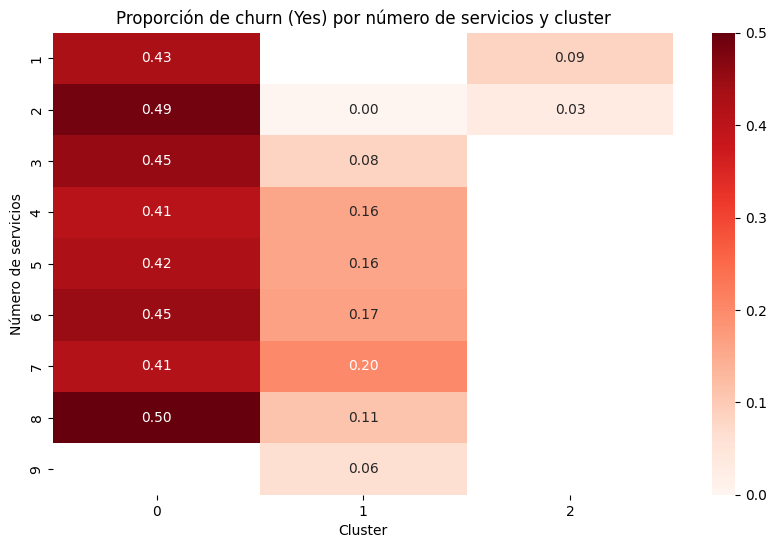

In [91]:

# Crear tabla dinámica: proporción de churn 'Yes' por cluster y num_servicios
pivot = pd.pivot_table(
    df_clusters,
    values='Churn',
    index='num_servicios',
    columns='cluster',
    aggfunc=lambda x: (x == 1).mean() if x.dtype != 'O' else (x == 'Yes').mean()
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Reds")
plt.title('Proporción de churn (Yes) por número de servicios y cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de servicios')
plt.show()